In [ ]:
# BLOCK 1: INSTALL PACKAGES & IMPORTS
import sys
print("Installing required packages...")
print("Note: Dependency warnings are normal in Colab and can be safely ignored")

!pip install librosa==0.10.1 sounddevice soundfile tqdm matplotlib seaborn --quiet --no-warn-conflicts
!apt-get install -y portaudio19-dev -qq > /dev/null 2>&1
!pip install pyaudio --quiet --no-warn-conflicts

# Test librosa installation
try:
    import librosa
    print(f"Librosa {librosa.__version__} installed successfully")
except ImportError:
    print("Librosa installation failed, attempting fix...")
    !pip install --upgrade --force-reinstall librosa==0.10.1 --quiet --no-warn-conflicts
    import librosa
    print(f"Librosa {librosa.__version__} installed after fix")

import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import sounddevice as sd
import soundfile as sf
import os
import glob
import zipfile
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle
import time
import warnings
from tqdm import tqdm
import shutil
warnings.filterwarnings('ignore')

try:
    from google.colab import drive, files
    print("Google Colab environment detected")
    COLAB_ENV = True
except ImportError:
    print("Not in Google Colab environment")
    COLAB_ENV = False

print("TESS Speech Emotion Recognition - Setup Complete")
print("=" * 50)
print("If you see dependency warnings above, they can be safely ignored.")
print("The system will work properly despite version conflicts.")

Installing required packages...
Note: Dependency warnings are normal in Colab and can be safely ignored
Librosa 0.10.1 installed successfully
Google Colab environment detected
TESS Speech Emotion Recognition - Setup Complete
If you see dependency warnings above, they can be safely ignored.
The system will work properly despite version conflicts.


In [ ]:
# BLOCK 2: CONFIGURATION

DRIVE_FOLDER_PATH = "/content/drive/MyDrive/TESS_dataset/"

CONFIG = {
    'sample_rate': 22050,
    'recording_duration': 3,
    'emotions': ['angry', 'disgust', 'fear', 'happy', 'neutral', 'pleasant_surprise', 'sad'],
    'model_filename': 'tess_emotion_model.pkl'
}

print("Configuration loaded")
print(f"Emotions to recognize: {CONFIG['emotions']}")
print(f"Drive folder path: {DRIVE_FOLDER_PATH}")



Configuration loaded
Emotions to recognize: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'pleasant_surprise', 'sad']
Drive folder path: /content/drive/MyDrive/TESS_dataset/


In [ ]:
# BLOCK 3: TESS EMOTION RECOGNIZER CLASS

class TESSEmotionRecognizer:
    def __init__(self):
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.model = None
        self.emotions = CONFIG['emotions']
        self.sample_rate = CONFIG['sample_rate']
        self.duration = CONFIG['recording_duration']

    def extract_features(self, audio_data, sample_rate=22050):
        try:
            if len(audio_data.shape) > 1:
                audio_data = audio_data.flatten()

            if len(audio_data) == 0:
                return None

            if np.max(np.abs(audio_data)) > 0:
                audio_data = audio_data / (np.max(np.abs(audio_data)) + 1e-8)

            features = []

            try:
                mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=13)
                mfcc_mean = np.mean(mfccs.T, axis=0)
                mfcc_std = np.std(mfccs.T, axis=0)
                features.extend(mfcc_mean)
                features.extend(mfcc_std)

                mfcc_delta = librosa.feature.delta(mfccs)
                mfcc_delta_mean = np.mean(mfcc_delta.T, axis=0)
                features.extend(mfcc_delta_mean)
            except Exception as e:
                print(f"MFCC error: {e}")
                features.extend([0.0] * 39)

            try:
                chroma = librosa.feature.chroma(y=audio_data, sr=sample_rate)
                chroma_mean = np.mean(chroma.T, axis=0)
                chroma_std = np.std(chroma.T, axis=0)
                features.extend(chroma_mean)
                features.extend(chroma_std)
            except Exception as e:
                print(f"Chroma error: {e}")
                features.extend([0.0] * 24)

            try:
                spectral_centroid = librosa.feature.spectral_centroid(y=audio_data, sr=sample_rate)
                features.append(np.mean(spectral_centroid))
                features.append(np.std(spectral_centroid))

                spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio_data, sr=sample_rate)
                features.append(np.mean(spectral_bandwidth))
                features.append(np.std(spectral_bandwidth))

                spectral_rolloff = librosa.feature.spectral_rolloff(y=audio_data, sr=sample_rate)
                features.append(np.mean(spectral_rolloff))
                features.append(np.std(spectral_rolloff))
            except Exception as e:
                print(f"Spectral features error: {e}")
                features.extend([0.0] * 6)

            try:
                zcr = librosa.feature.zero_crossing_rate(y=audio_data)
                features.append(np.mean(zcr))
                features.append(np.std(zcr))
            except Exception as e:
                print(f"ZCR error: {e}")
                features.extend([0.0] * 2)

            try:
                rms = librosa.feature.rms(y=audio_data)
                features.append(np.mean(rms))
                features.append(np.std(rms))
            except Exception as e:
                print(f"RMS error: {e}")
                features.extend([0.0] * 2)

            try:
                tempo, beats = librosa.beat.beat_track(y=audio_data, sr=sample_rate)
                features.append(tempo)
            except Exception as e:
                print(f"Tempo error: {e}")
                features.append(120.0)

            try:
                stft = librosa.stft(audio_data)
                pitches = np.abs(stft)
                pitch_mean = np.mean(pitches) if len(pitches) > 0 else 0
                pitch_std = np.std(pitches) if len(pitches) > 0 else 0
                features.extend([pitch_mean, pitch_std])
            except Exception as e:
                print(f"Pitch error: {e}")
                features.extend([0.0, 0.0])

            try:
                mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_mels=13)
                mel_mean = np.mean(mel_spec.T, axis=0)
                features.extend(mel_mean)
            except Exception as e:
                print(f"Mel spectrogram error: {e}")
                features.extend([0.0] * 13)

            feature_array = np.array(features)
            feature_array = np.nan_to_num(feature_array, nan=0.0, posinf=0.0, neginf=0.0)

            return feature_array if len(feature_array) > 0 else None

        except Exception as e:
            print(f"Error extracting features: {e}")
            return np.zeros(89)

    def load_audio_file(self, file_path):
        try:
            print(f"Loading audio file: {os.path.basename(file_path)}")

            audio_data, original_sr = librosa.load(file_path, sr=None)

            if original_sr != self.sample_rate:
                print(f"Resampling from {original_sr}Hz to {self.sample_rate}Hz")
                audio_data = librosa.resample(audio_data, orig_sr=original_sr, target_sr=self.sample_rate)

            duration = len(audio_data) / self.sample_rate
            print(f"Audio duration: {duration:.2f} seconds")
            print(f"Sample rate: {self.sample_rate}Hz")
            print(f"Audio shape: {audio_data.shape}")

            return audio_data

        except Exception as e:
            print(f"Error loading audio file: {e}")
            return None

    def predict_emotion(self, audio_data):
        if self.model is None:
            print("Model not trained! Please train the model first.")
            return None, None

        try:
            features = self.extract_features(audio_data, self.sample_rate)
            if features is None:
                return None, None

            features = features.reshape(1, -1)
            scaled_features = self.scaler.transform(features)

            prediction = self.model.predict(scaled_features)[0]
            probabilities = self.model.predict_proba(scaled_features)[0]

            emotion = self.label_encoder.inverse_transform([prediction])[0]
            emotion_scores = dict(zip(self.label_encoder.classes_, probabilities))

            return emotion, emotion_scores

        except Exception as e:
            print(f"Prediction error: {e}")
            return None, None

    def analyze_uploaded_audio(self, file_path):
        print("\nAudio File Emotion Analysis")
        print("=" * 40)

        audio_data = self.load_audio_file(file_path)
        if audio_data is None:
            print("Failed to load audio file")
            return None, None

        self.visualize_audio(audio_data, file_path)

        print("\nAnalyzing emotion...")
        emotion, scores = self.predict_emotion(audio_data)

        if emotion and scores:
            self.display_emotion_results(emotion, scores, file_path)
            return emotion, scores
        else:
            print("Could not analyze the audio emotion")
            return None, None

    def visualize_audio(self, audio_data, file_path):
        try:
            filename = os.path.basename(file_path)

            fig, axes = plt.subplots(2, 2, figsize=(16, 12))
            fig.suptitle(f'Audio Analysis: {filename}', fontsize=16, fontweight='bold')

            time = np.linspace(0, len(audio_data)/self.sample_rate, len(audio_data))
            axes[0, 0].plot(time, audio_data, color='steelblue', linewidth=0.8)
            axes[0, 0].set_title('Audio Waveform', fontsize=14)
            axes[0, 0].set_xlabel('Time (seconds)')
            axes[0, 0].set_ylabel('Amplitude')
            axes[0, 0].grid(True, alpha=0.3)
            axes[0, 0].set_facecolor('#f8f9fa')

            D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data)), ref=np.max)
            img1 = librosa.display.specshow(D, y_axis='hz', x_axis='time', sr=self.sample_rate, ax=axes[0, 1], cmap='viridis')
            axes[0, 1].set_title('Spectrogram', fontsize=14)
            plt.colorbar(img1, ax=axes[0, 1], format='%+2.0f dB')

            mfccs = librosa.feature.mfcc(y=audio_data, sr=self.sample_rate, n_mfcc=13)
            img2 = librosa.display.specshow(mfccs, x_axis='time', ax=axes[1, 0], cmap='RdYlBu_r')
            axes[1, 0].set_title('MFCC Features', fontsize=14)
            axes[1, 0].set_ylabel('MFCC Coefficients')
            plt.colorbar(img2, ax=axes[1, 0])

            chroma = librosa.feature.chroma(y=audio_data, sr=self.sample_rate)
            img3 = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=axes[1, 1], cmap='plasma')
            axes[1, 1].set_title('Chroma Features', fontsize=14)
            plt.colorbar(img3, ax=axes[1, 1])

            plt.tight_layout()
            plt.show()

            self.create_emotion_confidence_chart(None, None, show_preview=True)

        except Exception as e:
            print(f"Could not create visualizations: {e}")

    def display_emotion_results(self, emotion, scores, file_path):
        filename = os.path.basename(file_path)

        print(f"\nEMOTION ANALYSIS RESULTS")
        print("=" * 50)
        print(f"File: {filename}")
        print(f"Predicted Emotion: {emotion.upper()}")

        max_confidence = max(scores.values())
        print(f"Confidence: {max_confidence:.3f} ({max_confidence*100:.1f}%)")

        print(f"\nAll Emotion Scores:")
        print("-" * 50)
        sorted_emotions = sorted(scores.items(), key=lambda x: x[1], reverse=True)

        for i, (emo, score) in enumerate(sorted_emotions):
            bar_length = int(score * 40)
            bar = "█" * bar_length + "░" * (40 - bar_length)
            rank = f"{i+1}."
            print(f"  {rank:3} {emo:18} {score:.3f} |{bar}| {score*100:.1f}%")

        print(f"\nAnalysis Summary:")
        if max_confidence > 0.8:
            print(f"   High confidence: Strong {emotion.upper()} emotion detected")
        elif max_confidence > 0.6:
            print(f"   Good confidence: {emotion.upper()} emotion likely")
        elif max_confidence > 0.4:
            print(f"   Moderate confidence: {emotion.upper()} emotion possible")
        else:
            print(f"   Low confidence: Emotion unclear, consider audio quality")

        second_highest = sorted_emotions[1] if len(sorted_emotions) > 1 else None
        if second_highest and second_highest[1] > 0.3:
            print(f"   Secondary emotion: {second_highest[0]} ({second_highest[1]*100:.1f}%)")

        self.create_emotion_confidence_chart(emotion, scores)

    def create_emotion_confidence_chart(self, predicted_emotion, scores, show_preview=False):
        if show_preview:
            emotions = CONFIG['emotions']
            dummy_scores = np.random.dirichlet(np.ones(len(emotions)), size=1)[0]
            scores = dict(zip(emotions, dummy_scores))
            predicted_emotion = emotions[np.argmax(dummy_scores)]

        if scores:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

            sorted_emotions = sorted(scores.items(), key=lambda x: x[1], reverse=True)
            emotions, confidences = zip(*sorted_emotions)

            colors = plt.cm.Set3(np.linspace(0, 1, len(emotions)))
            bars = ax1.barh(emotions, confidences, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

            ax1.set_xlabel('Confidence Score', fontsize=12)
            ax1.set_title('Emotion Recognition Confidence Scores', fontsize=14, fontweight='bold')
            ax1.set_xlim(0, 1)
            ax1.grid(axis='x', alpha=0.3)

            for i, (bar, conf) in enumerate(zip(bars, confidences)):
                ax1.text(conf + 0.01, bar.get_y() + bar.get_height()/2,
                        f'{conf:.3f}', va='center', fontsize=10, fontweight='bold')
                if emotions[i] == predicted_emotion:
                    bar.set_edgecolor('red')
                    bar.set_linewidth(3)

            wedges, texts, autotexts = ax2.pie(confidences, labels=emotions, autopct='%1.1f%%',
                                              colors=colors, startangle=90,
                                              explode=[0.1 if emo == predicted_emotion else 0 for emo in emotions])

            ax2.set_title('Emotion Distribution', fontsize=14, fontweight='bold')

            for autotext in autotexts:
                autotext.set_color('white')
                autotext.set_fontweight('bold')
                autotext.set_fontsize(10)

            if not show_preview:
                fig.suptitle(f'Predicted Emotion: {predicted_emotion.upper()}', fontsize=16, fontweight='bold', y=1.02)
            else:
                fig.suptitle('Audio Analysis Visualization Preview', fontsize=16, fontweight='bold', y=1.02)

            plt.tight_layout()
            plt.show()

print("TESSEmotionRecognizer class loaded with file upload capabilities")



TESSEmotionRecognizer class loaded with file upload capabilities


In [ ]:
# BLOCK 4: GOOGLE DRIVE SETUP & DATA LOADING

def setup_google_drive():
    if COLAB_ENV:
        print("Mounting Google Drive...")
        drive.mount('/content/drive')
        print("Google Drive mounted successfully")
        return True
    else:
        print("Not in Google Colab environment")
        return False

def find_tess_files(folder_path):
    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        return {}

    print(f"Searching for TESS files in: {folder_path}")

    wav_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.wav'):
                wav_files.append(os.path.join(root, file))

    print(f"Found {len(wav_files)} .wav files")

    emotion_files = {emotion: [] for emotion in CONFIG['emotions']}

    emotion_mapping = {
        'angry': 'angry',
        'disgust': 'disgust',
        'fear': 'fear',
        'happy': 'happy',
        'neutral': 'neutral',
        'ps': 'pleasant_surprise',
        'pleasant_surprise': 'pleasant_surprise',
        'sad': 'sad'
    }

    for file_path in wav_files:
        filename = os.path.basename(file_path).lower()

        emotion_found = False
        for emotion_key, emotion_name in emotion_mapping.items():
            if emotion_key in filename:
                if emotion_name in emotion_files:
                    emotion_files[emotion_name].append(file_path)
                    emotion_found = True
                    break

        if not emotion_found:
            print(f"Could not identify emotion for: {filename}")

    print("\nFile distribution by emotion:")
    total_files = 0
    for emotion, files in emotion_files.items():
        count = len(files)
        total_files += count
        print(f"  {emotion}: {count} files")

    print(f"\nTotal organized files: {total_files}")

    return emotion_files

def load_tess_dataset_from_drive(recognizer, folder_path):
    emotion_files = find_tess_files(folder_path)

    if not any(emotion_files.values()):
        print("No TESS files found! Check your folder path and file structure.")
        return np.array([]), np.array([])

    features = []
    labels = []

    total_files = sum(len(files) for files in emotion_files.values())
    print(f"\nProcessing {total_files} audio files...")

    processed_count = 0
    error_count = 0

    for emotion, file_list in emotion_files.items():
        if not file_list:
            continue

        print(f"\nProcessing {emotion}: {len(file_list)} files")

        for file_path in tqdm(file_list, desc=f"Processing {emotion}"):
            try:
                audio_data, sr = librosa.load(file_path, sr=recognizer.sample_rate)
                feature_vector = recognizer.extract_features(audio_data, sr)

                if feature_vector is not None:
                    features.append(feature_vector)
                    labels.append(emotion)
                    processed_count += 1
                else:
                    error_count += 1

            except Exception as e:
                print(f"Error processing {os.path.basename(file_path)}: {e}")
                error_count += 1
                continue

    features = np.array(features)
    labels = np.array(labels)

    print(f"\nDataset loaded successfully")
    print(f"Successfully processed: {processed_count} files")
    print(f"Errors: {error_count} files")
    print(f"Feature dimensions: {features.shape[1] if len(features) > 0 else 0}")

    if len(labels) > 0:
        unique_emotions, counts = np.unique(labels, return_counts=True)
        print("\nFinal emotion distribution:")
        for emotion, count in zip(unique_emotions, counts):
            print(f"  {emotion}: {count} samples")

    return features, labels

print("Google Drive and data loading functions ready")


Google Drive and data loading functions ready


In [ ]:
# BLOCK 5: MODEL TRAINING & EVALUATION

def train_model(recognizer, features, labels):
    if len(features) == 0:
        print("No features to train on")
        return None

    print(f"\nTraining model...")
    print(f"Dataset shape: {features.shape}")

    encoded_labels = recognizer.label_encoder.fit_transform(labels)
    scaled_features = recognizer.scaler.fit_transform(features)

    X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, encoded_labels,
        test_size=0.2, random_state=42,
        stratify=encoded_labels
    )

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    recognizer.model = RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        random_state=42,
        n_jobs=-1
    )

    print("Training in progress...")
    recognizer.model.fit(X_train, y_train)

    y_pred = recognizer.model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"\nModel Performance:")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

    print(f"\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred,
                              target_names=recognizer.label_encoder.classes_))

    plot_confusion_matrix(y_test, y_pred, recognizer.label_encoder.classes_)

    return accuracy

def plot_confusion_matrix(y_test, y_pred, class_names):
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names,
               yticklabels=class_names)
    plt.title('TESS Emotion Recognition - Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted Emotion', fontsize=12)
    plt.ylabel('Actual Emotion', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def save_model(recognizer, filepath=None):
    if recognizer.model is None:
        print("No model to save")
        return False

    if filepath is None:
        filepath = f"/content/{CONFIG['model_filename']}"

    model_data = {
        'model': recognizer.model,
        'scaler': recognizer.scaler,
        'label_encoder': recognizer.label_encoder,
        'emotions': recognizer.emotions,
        'config': CONFIG
    }

    try:
        with open(filepath, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"Model saved to {filepath}")
        return True
    except Exception as e:
        print(f"Error saving model: {e}")
        return False

def load_model(recognizer, filepath=None):
    if filepath is None:
        filepath = f"/content/{CONFIG['model_filename']}"

    try:
        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)

        recognizer.model = model_data['model']
        recognizer.scaler = model_data['scaler']
        recognizer.label_encoder = model_data['label_encoder']
        recognizer.emotions = model_data.get('emotions', recognizer.emotions)

        print(f"Model loaded from {filepath}")
        return True
    except FileNotFoundError:
        print(f"Model file {filepath} not found")
        return False
    except Exception as e:
        print(f"Error loading model: {e}")
        return False

print("Training and model functions ready")


Training and model functions ready


In [ ]:
# BLOCK 6: FILE UPLOAD & ANALYSIS FUNCTIONS

def upload_and_analyze_audio(recognizer):
    if recognizer is None or recognizer.model is None:
        print("No trained model available")
        return

    print("\nAudio File Upload & Analysis")
    print("=" * 40)

    if COLAB_ENV:
        print("Upload your audio file using the file browser below...")
        uploaded = files.upload()

        if not uploaded:
            print("No file uploaded")
            return

        for filename, data in uploaded.items():
            print(f"\nProcessing uploaded file: {filename}")

            temp_path = f"/content/{filename}"
            with open(temp_path, 'wb') as f:
                f.write(data)

            emotion, scores = recognizer.analyze_uploaded_audio(temp_path)

            if os.path.exists(temp_path):
                os.remove(temp_path)

    else:
        file_path = input("Enter the path to your audio file: ").strip()
        if os.path.exists(file_path):
            emotion, scores = recognizer.analyze_uploaded_audio(file_path)
        else:
            print(f"File not found: {file_path}")

def analyze_audio_from_path(recognizer, file_path):
    if recognizer is None or recognizer.model is None:
        print("No trained model available")
        return None, None

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None, None

    return recognizer.analyze_uploaded_audio(file_path)

def batch_analyze_audio_files(recognizer, folder_path):
    if recognizer is None or recognizer.model is None:
        print("No trained model available")
        return

    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        return

    print(f"\nBatch Analysis: {folder_path}")
    print("=" * 50)

    audio_extensions = ['.wav', '.mp3', '.m4a', '.flac', '.ogg']
    audio_files = []

    for ext in audio_extensions:
        audio_files.extend(glob.glob(os.path.join(folder_path, f"*{ext}")))
        audio_files.extend(glob.glob(os.path.join(folder_path, f"*{ext.upper()}")))

    if not audio_files:
        print("No audio files found in the folder")
        return

    print(f"Found {len(audio_files)} audio files")

    results = []
    for file_path in tqdm(audio_files, desc="Analyzing files"):
        try:
            emotion, scores = recognizer.analyze_uploaded_audio(file_path)
            if emotion and scores:
                results.append({
                    'filename': os.path.basename(file_path),
                    'emotion': emotion,
                    'confidence': max(scores.values()),
                    'scores': scores
                })
        except Exception as e:
            print(f"Error analyzing {os.path.basename(file_path)}: {e}")

    if results:
        print(f"\nBatch Analysis Summary:")
        print("=" * 50)

        df = pd.DataFrame(results)

        emotion_counts = df['emotion'].value_counts()
        print(f"\nEmotion Distribution:")
        for emotion, count in emotion_counts.items():
            percentage = (count / len(results)) * 100
            print(f"  {emotion}: {count} files ({percentage:.1f}%)")

        print(f"\nAverage Confidence by Emotion:")
        avg_confidence = df.groupby('emotion')['confidence'].mean().sort_values(ascending=False)
        for emotion, conf in avg_confidence.items():
            print(f"  {emotion}: {conf:.3f} ({conf*100:.1f}%)")

        create_batch_analysis_visualization(results)

def create_batch_analysis_visualization(results):
    df = pd.DataFrame(results)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Batch Audio Analysis Results', fontsize=16, fontweight='bold')

    emotion_counts = df['emotion'].value_counts()
    colors = plt.cm.Set3(np.linspace(0, 1, len(emotion_counts)))

    bars = ax1.bar(emotion_counts.index, emotion_counts.values, color=colors, alpha=0.8, edgecolor='black')
    ax1.set_title('Emotion Distribution', fontsize=14)
    ax1.set_xlabel('Emotions')
    ax1.set_ylabel('Number of Files')
    ax1.tick_params(axis='x', rotation=45)

    for bar, count in zip(bars, emotion_counts.values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                str(count), ha='center', va='bottom', fontweight='bold')

    ax2.pie(emotion_counts.values, labels=emotion_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90)
    ax2.set_title('Emotion Percentage Distribution', fontsize=14)

    avg_confidence = df.groupby('emotion')['confidence'].mean().sort_values(ascending=False)
    bars2 = ax3.barh(avg_confidence.index, avg_confidence.values, color=colors[:len(avg_confidence)], alpha=0.8)
    ax3.set_title('Average Confidence by Emotion', fontsize=14)
    ax3.set_xlabel('Average Confidence Score')
    ax3.set_xlim(0, 1)

    for bar, conf in zip(bars2, avg_confidence.values):
        ax3.text(conf + 0.01, bar.get_y() + bar.get_height()/2,
                f'{conf:.3f}', va='center', fontweight='bold')

    confidence_bins = [0.0, 0.4, 0.6, 0.8, 1.0]
    confidence_labels = ['Low (0-0.4)', 'Moderate (0.4-0.6)', 'Good (0.6-0.8)', 'High (0.8-1.0)']
    df['confidence_category'] = pd.cut(df['confidence'], bins=confidence_bins, labels=confidence_labels, include_lowest=True)

    confidence_dist = df['confidence_category'].value_counts()
    ax4.bar(range(len(confidence_dist)), confidence_dist.values,
            color=['red', 'orange', 'lightgreen', 'darkgreen'], alpha=0.8, edgecolor='black')
    ax4.set_title('Confidence Level Distribution', fontsize=14)
    ax4.set_xlabel('Confidence Categories')
    ax4.set_ylabel('Number of Files')
    ax4.set_xticks(range(len(confidence_dist)))
    ax4.set_xticklabels(confidence_dist.index, rotation=45)

    for i, count in enumerate(confidence_dist.values):
        ax4.text(i, count + 0.1, str(count), ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

print("File upload and analysis functions ready")

File upload and analysis functions ready


In [ ]:
# Define COLAB_ENV before it's used
try:
    from google.colab import drive, files
    print("Google Colab environment detected")
    COLAB_ENV = True
except ImportError:
    print("Not in Google Colab environment")
    COLAB_ENV = False

Google Colab environment detected


All functions loaded! Ready to run!

TO START:
1. Update DRIVE_FOLDER_PATH in Block 2 with your actual folder path
2. Run: main()
TESS Speech Emotion Recognition System
Configuration Check:
  Drive folder: /content/drive/MyDrive/TESS_dataset/
  Emotions: 7 configured

Folder not found: /content/drive/MyDrive/TESS_dataset/
Let's help you find your TESS dataset...
TESS Dataset Setup Assistant
Let's find your TESS dataset folder...

Browsing your Google Drive structure:

Contents of /content/drive/MyDrive:
Folders:
  1. Colab Notebooks
  2. Google Photos
  3. TESS_Dataset

Files: 30 files found

Searching for TESS-related folders in: /content/drive/MyDrive
Found potential TESS folder: /content/drive/MyDrive/TESS_Dataset
Found potential TESS folder: /content/drive/MyDrive/TESS_Dataset/TESS Toronto emotional speech set data
Found potential TESS folder: /content/drive/MyDrive/TESS_Dataset/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data

Found 3 potential TESS da

Processing angry:   0%|          | 1/400 [00:00<06:29,  1.02it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:   0%|          | 2/400 [00:01<03:59,  1.66it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:   1%|          | 4/400 [00:03<04:41,  1.40it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:   2%|▏         | 8/400 [00:03<01:38,  3.99it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:   2%|▎         | 10/400 [00:03<01:13,  5.32it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:   4%|▎         | 14/400 [00:03<00:49,  7.73it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:   4%|▍         | 16/400 [00:04<00:46,  8.19it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:   4%|▍         | 18/400 [00:04<00:42,  9.06it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:   6%|▌         | 22/400 [00:04<00:36, 10.26it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:   6%|▌         | 24/400 [00:04<00:35, 10.63it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:   6%|▋         | 26/400 [00:05<00:34, 10.88it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:   7%|▋         | 28/400 [00:05<00:36, 10.15it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:   8%|▊         | 32/400 [00:05<00:32, 11.22it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:   8%|▊         | 34/400 [00:05<00:30, 11.98it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  10%|▉         | 38/400 [00:06<00:28, 12.49it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  10%|█         | 40/400 [00:06<00:28, 12.62it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  10%|█         | 42/400 [00:06<00:30, 11.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  12%|█▏        | 46/400 [00:06<00:28, 12.31it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  12%|█▏        | 48/400 [00:06<00:28, 12.52it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  13%|█▎        | 52/400 [00:07<00:26, 12.89it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  14%|█▎        | 54/400 [00:07<00:27, 12.67it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  14%|█▍        | 58/400 [00:07<00:26, 13.02it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  15%|█▌        | 60/400 [00:07<00:25, 13.19it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  16%|█▌        | 64/400 [00:08<00:26, 12.49it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  16%|█▋        | 66/400 [00:08<00:34,  9.55it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  17%|█▋        | 68/400 [00:08<00:42,  7.90it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  17%|█▋        | 69/400 [00:08<00:44,  7.39it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  18%|█▊        | 70/400 [00:09<00:52,  6.34it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  18%|█▊        | 71/400 [00:09<00:54,  6.05it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  18%|█▊        | 73/400 [00:09<00:50,  6.43it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  18%|█▊        | 74/400 [00:09<00:49,  6.57it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  19%|█▉        | 76/400 [00:10<00:56,  5.75it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  19%|█▉        | 77/400 [00:10<01:03,  5.07it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  20%|█▉        | 79/400 [00:10<01:00,  5.34it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  20%|██        | 80/400 [00:11<01:04,  4.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  20%|██        | 81/400 [00:11<01:07,  4.75it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  20%|██        | 82/400 [00:11<01:04,  4.92it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  21%|██        | 84/400 [00:11<00:53,  5.92it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  21%|██▏       | 85/400 [00:12<00:59,  5.26it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  22%|██▏       | 86/400 [00:12<00:58,  5.40it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  22%|██▏       | 88/400 [00:12<01:02,  4.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  22%|██▏       | 89/400 [00:12<00:58,  5.34it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  23%|██▎       | 91/400 [00:13<00:50,  6.11it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  23%|██▎       | 93/400 [00:13<00:47,  6.45it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  24%|██▍       | 95/400 [00:13<00:36,  8.47it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  25%|██▍       | 99/400 [00:13<00:28, 10.40it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  25%|██▌       | 101/400 [00:14<00:26, 11.26it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  26%|██▋       | 105/400 [00:14<00:23, 12.33it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  27%|██▋       | 107/400 [00:14<00:23, 12.51it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  28%|██▊       | 111/400 [00:14<00:22, 12.80it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  28%|██▊       | 113/400 [00:14<00:23, 12.42it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  29%|██▉       | 117/400 [00:15<00:22, 12.80it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  30%|██▉       | 119/400 [00:15<00:21, 13.08it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  31%|███       | 123/400 [00:15<00:20, 13.46it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  31%|███▏      | 125/400 [00:15<00:20, 13.62it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  32%|███▏      | 129/400 [00:16<00:20, 12.95it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  33%|███▎      | 131/400 [00:16<00:20, 12.83it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  34%|███▍      | 135/400 [00:16<00:20, 12.83it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  34%|███▍      | 137/400 [00:16<00:20, 12.89it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  35%|███▌      | 141/400 [00:17<00:20, 12.51it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  36%|███▌      | 143/400 [00:17<00:20, 12.78it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  37%|███▋      | 147/400 [00:17<00:19, 13.17it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  37%|███▋      | 149/400 [00:17<00:18, 13.26it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  38%|███▊      | 153/400 [00:17<00:18, 13.47it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  39%|███▉      | 155/400 [00:18<00:19, 12.82it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  40%|███▉      | 159/400 [00:18<00:18, 13.24it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  40%|████      | 161/400 [00:18<00:17, 13.33it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  41%|████▏     | 165/400 [00:18<00:17, 13.60it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  42%|████▏     | 167/400 [00:19<00:17, 13.24it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  43%|████▎     | 171/400 [00:19<00:18, 12.29it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  43%|████▎     | 173/400 [00:19<00:18, 12.45it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  44%|████▍     | 177/400 [00:19<00:17, 12.70it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  45%|████▍     | 179/400 [00:20<00:17, 12.93it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  46%|████▌     | 183/400 [00:20<00:17, 12.71it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  46%|████▋     | 185/400 [00:20<00:16, 12.84it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  47%|████▋     | 189/400 [00:20<00:16, 12.85it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  48%|████▊     | 191/400 [00:20<00:16, 12.81it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma


Processing angry:  48%|████▊     | 193/400 [00:21<00:16, 12.83it/s]

Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  49%|████▉     | 197/400 [00:21<00:16, 12.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  50%|████▉     | 199/400 [00:21<00:16, 12.37it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  50%|█████     | 201/400 [00:22<00:24,  8.06it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  51%|█████     | 203/400 [00:22<00:32,  6.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  51%|█████     | 204/400 [00:22<00:36,  5.30it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  51%|█████▏    | 205/400 [00:23<00:42,  4.58it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  52%|█████▏    | 206/400 [00:23<00:47,  4.10it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  52%|█████▏    | 207/400 [00:23<00:52,  3.71it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  52%|█████▏    | 208/400 [00:24<01:01,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  52%|█████▏    | 209/400 [00:24<00:59,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  52%|█████▎    | 210/400 [00:25<01:06,  2.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  53%|█████▎    | 211/400 [00:25<01:02,  3.02it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  53%|█████▎    | 212/400 [00:25<01:07,  2.80it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  53%|█████▎    | 213/400 [00:26<01:03,  2.93it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  54%|█████▎    | 214/400 [00:26<01:01,  3.00it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  54%|█████▍    | 215/400 [00:26<01:08,  2.68it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  54%|█████▍    | 216/400 [00:27<01:04,  2.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  54%|█████▍    | 217/400 [00:27<01:01,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  55%|█████▍    | 218/400 [00:27<00:57,  3.18it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  55%|█████▍    | 219/400 [00:28<00:55,  3.25it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  55%|█████▌    | 220/400 [00:28<00:54,  3.30it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  55%|█████▌    | 221/400 [00:28<00:57,  3.09it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  56%|█████▌    | 222/400 [00:28<00:54,  3.29it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  56%|█████▌    | 223/400 [00:29<00:51,  3.43it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  56%|█████▌    | 224/400 [00:29<00:58,  3.00it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  56%|█████▋    | 225/400 [00:30<00:59,  2.96it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  56%|█████▋    | 226/400 [00:30<00:55,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  57%|█████▋    | 227/400 [00:30<00:53,  3.26it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  57%|█████▋    | 228/400 [00:30<00:50,  3.38it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  57%|█████▋    | 229/400 [00:31<00:48,  3.54it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  57%|█████▊    | 230/400 [00:31<00:46,  3.67it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  58%|█████▊    | 231/400 [00:31<00:46,  3.62it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  58%|█████▊    | 232/400 [00:31<00:45,  3.66it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  58%|█████▊    | 233/400 [00:32<00:48,  3.43it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  58%|█████▊    | 234/400 [00:32<00:50,  3.28it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  59%|█████▉    | 235/400 [00:32<00:48,  3.41it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  59%|█████▉    | 236/400 [00:33<00:45,  3.57it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  59%|█████▉    | 237/400 [00:33<00:52,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  60%|█████▉    | 238/400 [00:33<00:50,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  60%|█████▉    | 239/400 [00:34<00:54,  2.98it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  60%|██████    | 240/400 [00:34<00:54,  2.92it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  60%|██████    | 241/400 [00:34<00:51,  3.07it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  60%|██████    | 242/400 [00:35<00:49,  3.20it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  61%|██████    | 243/400 [00:35<00:49,  3.15it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  61%|██████    | 244/400 [00:35<00:46,  3.34it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  61%|██████▏   | 245/400 [00:36<00:46,  3.33it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  62%|██████▏   | 246/400 [00:36<00:44,  3.43it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  62%|██████▏   | 247/400 [00:36<00:43,  3.52it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  62%|██████▏   | 248/400 [00:36<00:46,  3.28it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  62%|██████▏   | 249/400 [00:37<00:45,  3.33it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  62%|██████▎   | 250/400 [00:37<00:53,  2.82it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  63%|██████▎   | 251/400 [00:38<00:51,  2.87it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  63%|██████▎   | 252/400 [00:38<00:50,  2.94it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  63%|██████▎   | 253/400 [00:38<00:50,  2.89it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  64%|██████▎   | 254/400 [00:39<00:54,  2.66it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  64%|██████▍   | 255/400 [00:39<00:51,  2.79it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  64%|██████▍   | 256/400 [00:39<00:53,  2.67it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  64%|██████▍   | 257/400 [00:40<00:53,  2.68it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  64%|██████▍   | 258/400 [00:40<00:50,  2.83it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  65%|██████▍   | 259/400 [00:40<00:47,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  65%|██████▌   | 260/400 [00:41<00:55,  2.54it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  65%|██████▌   | 261/400 [00:41<00:49,  2.83it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  66%|██████▌   | 262/400 [00:41<00:49,  2.78it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  66%|██████▌   | 263/400 [00:42<00:51,  2.67it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  66%|██████▌   | 264/400 [00:42<00:45,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  66%|██████▋   | 265/400 [00:42<00:41,  3.22it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  66%|██████▋   | 266/400 [00:43<00:40,  3.35it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  67%|██████▋   | 267/400 [00:43<00:37,  3.58it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  67%|██████▋   | 268/400 [00:43<00:36,  3.66it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  67%|██████▋   | 269/400 [00:43<00:33,  3.94it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  68%|██████▊   | 270/400 [00:44<00:34,  3.81it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  68%|██████▊   | 271/400 [00:44<00:37,  3.44it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  68%|██████▊   | 272/400 [00:44<00:40,  3.20it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  68%|██████▊   | 273/400 [00:45<00:39,  3.24it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  68%|██████▊   | 274/400 [00:45<00:37,  3.35it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  69%|██████▉   | 275/400 [00:45<00:35,  3.48it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  69%|██████▉   | 276/400 [00:46<00:38,  3.21it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  69%|██████▉   | 277/400 [00:46<00:40,  3.07it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  70%|██████▉   | 278/400 [00:46<00:36,  3.37it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  70%|██████▉   | 279/400 [00:47<00:37,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  70%|███████   | 280/400 [00:47<00:39,  3.07it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  70%|███████   | 281/400 [00:47<00:42,  2.81it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  70%|███████   | 282/400 [00:48<00:38,  3.06it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  71%|███████   | 283/400 [00:48<00:41,  2.81it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  71%|███████   | 284/400 [00:48<00:44,  2.62it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  71%|███████▏  | 285/400 [00:49<00:42,  2.73it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  72%|███████▏  | 286/400 [00:49<00:38,  2.94it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  72%|███████▏  | 287/400 [00:49<00:36,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  72%|███████▏  | 288/400 [00:50<00:41,  2.73it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  72%|███████▏  | 289/400 [00:50<00:36,  3.07it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  72%|███████▎  | 290/400 [00:50<00:34,  3.21it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  73%|███████▎  | 291/400 [00:51<00:33,  3.25it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  73%|███████▎  | 292/400 [00:51<00:35,  3.05it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  73%|███████▎  | 293/400 [00:51<00:35,  2.99it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  74%|███████▎  | 294/400 [00:52<00:38,  2.79it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  74%|███████▍  | 295/400 [00:52<00:41,  2.54it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  74%|███████▍  | 296/400 [00:53<00:38,  2.72it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  74%|███████▍  | 297/400 [00:53<00:39,  2.64it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  74%|███████▍  | 298/400 [00:53<00:39,  2.58it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  75%|███████▍  | 299/400 [00:54<00:38,  2.62it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  75%|███████▌  | 300/400 [00:54<00:43,  2.29it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  75%|███████▌  | 301/400 [00:55<00:42,  2.36it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  76%|███████▌  | 302/400 [00:55<00:36,  2.65it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  76%|███████▌  | 303/400 [00:55<00:32,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  76%|███████▌  | 304/400 [00:55<00:29,  3.25it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  76%|███████▋  | 305/400 [00:56<00:28,  3.34it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  76%|███████▋  | 306/400 [00:56<00:27,  3.45it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  77%|███████▋  | 307/400 [00:56<00:28,  3.28it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  77%|███████▋  | 308/400 [00:57<00:28,  3.27it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  77%|███████▋  | 309/400 [00:57<00:25,  3.51it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  78%|███████▊  | 310/400 [00:57<00:23,  3.79it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  78%|███████▊  | 311/400 [00:57<00:24,  3.69it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  78%|███████▊  | 312/400 [00:58<00:23,  3.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  78%|███████▊  | 313/400 [00:58<00:23,  3.67it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  78%|███████▊  | 314/400 [00:58<00:24,  3.47it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  79%|███████▉  | 315/400 [00:58<00:24,  3.47it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  79%|███████▉  | 316/400 [00:59<00:24,  3.38it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  79%|███████▉  | 317/400 [00:59<00:24,  3.34it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  80%|███████▉  | 318/400 [00:59<00:24,  3.41it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  80%|███████▉  | 319/400 [01:00<00:22,  3.53it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  80%|████████  | 320/400 [01:00<00:22,  3.59it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  80%|████████  | 321/400 [01:00<00:21,  3.59it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  80%|████████  | 322/400 [01:01<00:23,  3.30it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  81%|████████  | 323/400 [01:01<00:23,  3.28it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  81%|████████  | 324/400 [01:01<00:22,  3.34it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  81%|████████▏ | 325/400 [01:01<00:21,  3.41it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  82%|████████▏ | 326/400 [01:02<00:21,  3.40it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  82%|████████▏ | 327/400 [01:02<00:21,  3.41it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  82%|████████▏ | 328/400 [01:02<00:21,  3.40it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  82%|████████▏ | 329/400 [01:03<00:20,  3.53it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  82%|████████▎ | 330/400 [01:03<00:31,  2.21it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  83%|████████▎ | 331/400 [01:04<00:29,  2.37it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  83%|████████▎ | 332/400 [01:04<00:24,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  83%|████████▎ | 333/400 [01:04<00:22,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  84%|████████▎ | 334/400 [01:05<00:20,  3.16it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  84%|████████▍ | 335/400 [01:05<00:21,  3.01it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  84%|████████▍ | 336/400 [01:05<00:20,  3.09it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  84%|████████▍ | 337/400 [01:06<00:22,  2.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  84%|████████▍ | 338/400 [01:06<00:23,  2.68it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  85%|████████▍ | 339/400 [01:06<00:21,  2.90it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  85%|████████▌ | 340/400 [01:07<00:20,  2.89it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  85%|████████▌ | 341/400 [01:07<00:22,  2.62it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  86%|████████▌ | 342/400 [01:08<00:22,  2.59it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  86%|████████▌ | 343/400 [01:08<00:21,  2.67it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  86%|████████▌ | 344/400 [01:08<00:20,  2.75it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  86%|████████▋ | 345/400 [01:09<00:19,  2.84it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  86%|████████▋ | 346/400 [01:09<00:19,  2.81it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  87%|████████▋ | 347/400 [01:09<00:16,  3.17it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  87%|████████▋ | 348/400 [01:09<00:15,  3.45it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  87%|████████▋ | 349/400 [01:10<00:17,  2.90it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  88%|████████▊ | 350/400 [01:10<00:15,  3.15it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  88%|████████▊ | 351/400 [01:10<00:14,  3.35it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  88%|████████▊ | 352/400 [01:11<00:14,  3.26it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  88%|████████▊ | 353/400 [01:11<00:14,  3.34it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  88%|████████▊ | 354/400 [01:11<00:13,  3.38it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  89%|████████▉ | 355/400 [01:12<00:14,  3.18it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  89%|████████▉ | 356/400 [01:12<00:16,  2.73it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  89%|████████▉ | 357/400 [01:12<00:14,  2.92it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  90%|████████▉ | 358/400 [01:13<00:13,  3.09it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  90%|████████▉ | 359/400 [01:13<00:14,  2.79it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  90%|█████████ | 360/400 [01:13<00:13,  2.94it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  90%|█████████ | 361/400 [01:14<00:11,  3.28it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  90%|█████████ | 362/400 [01:14<00:11,  3.33it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  91%|█████████ | 363/400 [01:14<00:11,  3.26it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  91%|█████████ | 364/400 [01:15<00:10,  3.35it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  91%|█████████▏| 365/400 [01:15<00:10,  3.50it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  92%|█████████▏| 366/400 [01:15<00:09,  3.47it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  92%|█████████▏| 367/400 [01:15<00:09,  3.50it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  92%|█████████▏| 368/400 [01:16<00:09,  3.50it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  92%|█████████▏| 369/400 [01:16<00:08,  3.50it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  92%|█████████▎| 370/400 [01:16<00:08,  3.63it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  93%|█████████▎| 371/400 [01:16<00:07,  3.72it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  93%|█████████▎| 372/400 [01:17<00:07,  3.69it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  93%|█████████▎| 373/400 [01:17<00:08,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  94%|█████████▎| 374/400 [01:17<00:08,  3.01it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  94%|█████████▍| 375/400 [01:18<00:08,  3.09it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  94%|█████████▍| 376/400 [01:18<00:07,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  94%|█████████▍| 377/400 [01:18<00:07,  3.27it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  94%|█████████▍| 378/400 [01:19<00:06,  3.33it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  95%|█████████▍| 379/400 [01:19<00:06,  3.36it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  95%|█████████▌| 380/400 [01:19<00:07,  2.72it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  95%|█████████▌| 381/400 [01:20<00:07,  2.49it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  96%|█████████▌| 382/400 [01:20<00:07,  2.49it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  96%|█████████▌| 383/400 [01:21<00:06,  2.50it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  96%|█████████▌| 384/400 [01:21<00:06,  2.66it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  96%|█████████▋| 385/400 [01:21<00:05,  2.68it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  96%|█████████▋| 386/400 [01:22<00:04,  2.83it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  97%|█████████▋| 387/400 [01:22<00:04,  2.89it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  97%|█████████▋| 388/400 [01:22<00:04,  2.73it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  97%|█████████▋| 389/400 [01:23<00:04,  2.62it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  98%|█████████▊| 390/400 [01:23<00:03,  2.80it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  98%|█████████▊| 391/400 [01:23<00:03,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  98%|█████████▊| 392/400 [01:24<00:02,  3.11it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  98%|█████████▊| 393/400 [01:24<00:02,  2.76it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  98%|█████████▊| 394/400 [01:25<00:02,  2.99it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  99%|█████████▉| 395/400 [01:25<00:01,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  99%|█████████▉| 396/400 [01:25<00:01,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry:  99%|█████████▉| 397/400 [01:25<00:00,  3.05it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry: 100%|█████████▉| 398/400 [01:26<00:00,  3.11it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry: 100%|█████████▉| 399/400 [01:26<00:00,  3.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing angry: 100%|██████████| 400/400 [01:26<00:00,  4.61it/s]


Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'

Processing disgust: 400 files


Processing disgust:   0%|          | 1/400 [00:00<02:28,  2.68it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   0%|          | 2/400 [00:00<02:11,  3.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   1%|          | 3/400 [00:00<01:52,  3.53it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   1%|          | 4/400 [00:01<01:59,  3.32it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   1%|▏         | 5/400 [00:01<01:57,  3.36it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   2%|▏         | 6/400 [00:01<02:12,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   2%|▏         | 7/400 [00:02<02:13,  2.94it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   2%|▏         | 8/400 [00:02<02:02,  3.20it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   2%|▏         | 9/400 [00:02<02:02,  3.20it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   2%|▎         | 10/400 [00:03<02:10,  2.99it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   3%|▎         | 11/400 [00:03<02:07,  3.06it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   3%|▎         | 12/400 [00:03<02:05,  3.09it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   3%|▎         | 13/400 [00:04<02:06,  3.06it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   4%|▎         | 14/400 [00:04<02:00,  3.21it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   4%|▍         | 15/400 [00:04<02:20,  2.73it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   4%|▍         | 16/400 [00:05<02:18,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   4%|▍         | 17/400 [00:05<02:18,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   4%|▍         | 18/400 [00:06<02:22,  2.69it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   5%|▍         | 19/400 [00:06<02:14,  2.84it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   5%|▌         | 21/400 [00:07<02:41,  2.34it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   6%|▌         | 22/400 [00:07<02:57,  2.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   6%|▌         | 23/400 [00:08<03:05,  2.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   6%|▌         | 24/400 [00:09<03:07,  2.01it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   6%|▋         | 25/400 [00:09<02:48,  2.22it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   6%|▋         | 26/400 [00:09<02:59,  2.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   7%|▋         | 27/400 [00:10<02:42,  2.30it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   7%|▋         | 28/400 [00:10<02:36,  2.38it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   7%|▋         | 29/400 [00:10<02:20,  2.64it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   8%|▊         | 30/400 [00:11<02:24,  2.57it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   8%|▊         | 31/400 [00:11<02:21,  2.61it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   8%|▊         | 32/400 [00:12<02:18,  2.66it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   8%|▊         | 33/400 [00:12<02:27,  2.49it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   8%|▊         | 34/400 [00:12<02:20,  2.61it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   9%|▉         | 35/400 [00:13<02:13,  2.73it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   9%|▉         | 36/400 [00:13<02:17,  2.65it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:   9%|▉         | 37/400 [00:13<02:21,  2.56it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  10%|▉         | 38/400 [00:14<02:16,  2.64it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  10%|▉         | 39/400 [00:14<02:18,  2.60it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  10%|█         | 40/400 [00:15<02:13,  2.69it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  10%|█         | 41/400 [00:15<02:06,  2.84it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  10%|█         | 42/400 [00:15<02:15,  2.65it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  11%|█         | 43/400 [00:16<02:06,  2.82it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  11%|█         | 44/400 [00:16<02:05,  2.84it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  11%|█▏        | 45/400 [00:16<02:00,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  12%|█▏        | 46/400 [00:17<02:07,  2.78it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  12%|█▏        | 47/400 [00:17<01:58,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  12%|█▏        | 48/400 [00:17<01:53,  3.09it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  12%|█▏        | 49/400 [00:18<01:52,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  12%|█▎        | 50/400 [00:18<01:49,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  13%|█▎        | 51/400 [00:18<01:52,  3.10it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  13%|█▎        | 52/400 [00:19<01:55,  3.01it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  13%|█▎        | 53/400 [00:19<01:54,  3.02it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  14%|█▎        | 54/400 [00:19<01:51,  3.11it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  14%|█▍        | 55/400 [00:19<01:44,  3.30it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  14%|█▍        | 57/400 [00:21<02:26,  2.35it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  14%|█▍        | 58/400 [00:21<02:16,  2.51it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  15%|█▍        | 59/400 [00:21<02:13,  2.56it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  15%|█▌        | 61/400 [00:22<02:20,  2.41it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  16%|█▌        | 62/400 [00:23<02:36,  2.16it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  16%|█▌        | 63/400 [00:23<02:20,  2.40it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  16%|█▋        | 65/400 [00:24<02:11,  2.55it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  16%|█▋        | 66/400 [00:24<02:16,  2.45it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  17%|█▋        | 67/400 [00:25<02:08,  2.59it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  17%|█▋        | 68/400 [00:25<02:01,  2.73it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  17%|█▋        | 69/400 [00:25<02:10,  2.54it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  18%|█▊        | 70/400 [00:26<02:07,  2.59it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  18%|█▊        | 71/400 [00:26<01:57,  2.79it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  18%|█▊        | 72/400 [00:26<02:06,  2.59it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  18%|█▊        | 73/400 [00:27<02:00,  2.72it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  18%|█▊        | 74/400 [00:27<02:03,  2.65it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  19%|█▉        | 75/400 [00:28<01:55,  2.81it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  19%|█▉        | 76/400 [00:28<01:57,  2.75it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  19%|█▉        | 77/400 [00:28<01:55,  2.79it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  20%|█▉        | 78/400 [00:29<01:56,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  20%|█▉        | 79/400 [00:29<01:54,  2.79it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  20%|██        | 80/400 [00:29<01:55,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  20%|██        | 81/400 [00:30<01:49,  2.92it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  20%|██        | 82/400 [00:30<01:40,  3.16it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  21%|██        | 83/400 [00:30<01:54,  2.78it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  21%|██        | 84/400 [00:31<02:00,  2.63it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  21%|██▏       | 85/400 [00:31<01:55,  2.73it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  22%|██▏       | 86/400 [00:31<01:50,  2.84it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  22%|██▏       | 87/400 [00:32<01:50,  2.84it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  22%|██▏       | 88/400 [00:32<01:51,  2.80it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  22%|██▏       | 89/400 [00:32<01:42,  3.05it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  22%|██▎       | 90/400 [00:33<01:48,  2.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  23%|██▎       | 91/400 [00:33<01:39,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  23%|██▎       | 92/400 [00:33<01:39,  3.09it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  23%|██▎       | 93/400 [00:34<01:49,  2.79it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  24%|██▎       | 94/400 [00:34<02:03,  2.48it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  24%|██▍       | 96/400 [00:35<02:07,  2.38it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  24%|██▍       | 97/400 [00:36<02:25,  2.09it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  25%|██▍       | 99/400 [00:37<02:05,  2.40it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  25%|██▌       | 100/400 [00:37<02:02,  2.45it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  25%|██▌       | 101/400 [00:37<01:59,  2.49it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  26%|██▌       | 102/400 [00:38<01:55,  2.59it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  26%|██▌       | 103/400 [00:38<01:45,  2.81it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  26%|██▌       | 104/400 [00:38<01:40,  2.94it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  26%|██▋       | 105/400 [00:39<02:03,  2.39it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  26%|██▋       | 106/400 [00:39<01:53,  2.60it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  27%|██▋       | 107/400 [00:39<01:42,  2.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  27%|██▋       | 108/400 [00:40<01:45,  2.76it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  27%|██▋       | 109/400 [00:40<01:44,  2.79it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  28%|██▊       | 110/400 [00:41<01:43,  2.81it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  28%|██▊       | 111/400 [00:41<01:44,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  28%|██▊       | 112/400 [00:41<01:36,  2.98it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  28%|██▊       | 113/400 [00:42<01:40,  2.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  28%|██▊       | 114/400 [00:42<01:35,  2.98it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  29%|██▉       | 115/400 [00:42<01:29,  3.18it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  29%|██▉       | 116/400 [00:42<01:25,  3.31it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  29%|██▉       | 117/400 [00:43<01:29,  3.15it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  30%|██▉       | 118/400 [00:43<01:24,  3.34it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  30%|██▉       | 119/400 [00:43<01:27,  3.21it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  30%|███       | 120/400 [00:44<01:27,  3.22it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  30%|███       | 121/400 [00:44<01:30,  3.07it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  30%|███       | 122/400 [00:44<01:26,  3.23it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  31%|███       | 123/400 [00:45<01:23,  3.32it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  31%|███       | 124/400 [00:45<01:23,  3.31it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  31%|███▏      | 125/400 [00:45<01:29,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  32%|███▏      | 126/400 [00:46<01:30,  3.04it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  32%|███▏      | 127/400 [00:46<01:28,  3.09it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  32%|███▏      | 128/400 [00:46<01:27,  3.09it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  32%|███▏      | 129/400 [00:47<01:23,  3.26it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  32%|███▎      | 130/400 [00:47<01:28,  3.04it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  33%|███▎      | 131/400 [00:47<01:30,  2.98it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  33%|███▎      | 132/400 [00:48<01:35,  2.81it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  33%|███▎      | 133/400 [00:48<01:30,  2.94it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  34%|███▍      | 135/400 [00:49<01:47,  2.47it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  34%|███▍      | 136/400 [00:49<01:45,  2.49it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  34%|███▍      | 137/400 [00:50<01:42,  2.56it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  34%|███▍      | 138/400 [00:50<01:37,  2.68it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  35%|███▍      | 139/400 [00:50<01:37,  2.68it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  35%|███▌      | 140/400 [00:51<01:30,  2.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  35%|███▌      | 141/400 [00:51<01:30,  2.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  36%|███▌      | 142/400 [00:51<01:37,  2.65it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  36%|███▌      | 143/400 [00:52<01:35,  2.69it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  36%|███▌      | 144/400 [00:52<01:33,  2.74it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  36%|███▋      | 145/400 [00:53<01:29,  2.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  36%|███▋      | 146/400 [00:53<01:25,  2.98it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  37%|███▋      | 147/400 [00:53<01:21,  3.09it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  37%|███▋      | 148/400 [00:53<01:17,  3.25it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  37%|███▋      | 149/400 [00:54<01:19,  3.18it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  38%|███▊      | 150/400 [00:54<01:14,  3.35it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  38%|███▊      | 151/400 [00:54<01:14,  3.36it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  38%|███▊      | 152/400 [00:55<01:15,  3.27it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  38%|███▊      | 153/400 [00:55<01:13,  3.38it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  38%|███▊      | 154/400 [00:55<01:08,  3.59it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  39%|███▉      | 155/400 [00:55<01:13,  3.33it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  39%|███▉      | 156/400 [00:56<01:17,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  39%|███▉      | 157/400 [00:56<01:15,  3.22it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  40%|███▉      | 158/400 [00:56<01:14,  3.25it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  40%|███▉      | 159/400 [00:57<01:18,  3.06it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  40%|████      | 160/400 [00:57<01:16,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  40%|████      | 161/400 [00:57<01:12,  3.29it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  40%|████      | 162/400 [00:58<01:19,  3.01it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  41%|████      | 163/400 [00:58<01:16,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  41%|████      | 164/400 [00:58<01:16,  3.09it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  41%|████▏     | 165/400 [00:59<01:14,  3.17it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  42%|████▏     | 166/400 [00:59<01:13,  3.18it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  42%|████▏     | 167/400 [00:59<01:16,  3.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  42%|████▏     | 168/400 [01:00<01:20,  2.88it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  42%|████▏     | 169/400 [01:00<01:21,  2.83it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  42%|████▎     | 170/400 [01:01<01:27,  2.63it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  43%|████▎     | 171/400 [01:01<01:20,  2.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  43%|████▎     | 172/400 [01:01<01:16,  2.99it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  43%|████▎     | 173/400 [01:01<01:14,  3.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  44%|████▎     | 174/400 [01:02<01:11,  3.17it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  44%|████▍     | 175/400 [01:02<01:15,  2.98it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  44%|████▍     | 176/400 [01:02<01:10,  3.16it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  44%|████▍     | 178/400 [01:03<01:27,  2.55it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  45%|████▍     | 179/400 [01:04<01:29,  2.47it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  45%|████▌     | 180/400 [01:04<01:34,  2.32it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  45%|████▌     | 181/400 [01:05<01:51,  1.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  46%|████▌     | 183/400 [01:06<01:42,  2.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  46%|████▌     | 184/400 [01:06<01:45,  2.04it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  46%|████▋     | 185/400 [01:07<01:35,  2.25it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  46%|████▋     | 186/400 [01:07<01:24,  2.54it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  47%|████▋     | 187/400 [01:07<01:21,  2.61it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  47%|████▋     | 188/400 [01:08<01:13,  2.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  47%|████▋     | 189/400 [01:08<01:11,  2.93it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  48%|████▊     | 190/400 [01:08<01:14,  2.80it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  48%|████▊     | 191/400 [01:09<01:11,  2.93it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  48%|████▊     | 192/400 [01:09<01:10,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  48%|████▊     | 193/400 [01:09<01:07,  3.07it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  48%|████▊     | 194/400 [01:09<01:01,  3.34it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  49%|████▉     | 195/400 [01:10<00:57,  3.54it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  49%|████▉     | 196/400 [01:10<00:57,  3.54it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  49%|████▉     | 197/400 [01:10<01:03,  3.18it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  50%|████▉     | 198/400 [01:11<01:04,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  50%|████▉     | 199/400 [01:11<01:27,  2.30it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  50%|█████     | 200/400 [01:12<01:20,  2.49it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  50%|█████     | 201/400 [01:12<01:21,  2.44it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  50%|█████     | 202/400 [01:12<01:12,  2.74it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  51%|█████     | 203/400 [01:13<01:09,  2.82it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  51%|█████     | 204/400 [01:13<01:04,  3.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  51%|█████▏    | 205/400 [01:14<01:19,  2.44it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  52%|█████▏    | 206/400 [01:14<01:12,  2.69it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  52%|█████▏    | 207/400 [01:14<01:15,  2.57it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  52%|█████▏    | 208/400 [01:15<01:16,  2.52it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  52%|█████▏    | 209/400 [01:15<01:12,  2.65it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  52%|█████▎    | 210/400 [01:15<01:06,  2.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  53%|█████▎    | 211/400 [01:16<01:07,  2.80it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  53%|█████▎    | 212/400 [01:16<01:02,  3.00it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  53%|█████▎    | 213/400 [01:16<01:03,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  54%|█████▍    | 215/400 [01:17<01:18,  2.34it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  54%|█████▍    | 216/400 [01:18<01:17,  2.39it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  54%|█████▍    | 217/400 [01:18<01:10,  2.59it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  55%|█████▍    | 218/400 [01:19<01:12,  2.52it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  55%|█████▌    | 220/400 [01:19<01:13,  2.43it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  55%|█████▌    | 221/400 [01:20<01:21,  2.20it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  56%|█████▌    | 222/400 [01:20<01:18,  2.28it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  56%|█████▌    | 223/400 [01:21<01:08,  2.60it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  56%|█████▌    | 224/400 [01:21<01:04,  2.74it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  56%|█████▋    | 225/400 [01:21<01:00,  2.91it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  56%|█████▋    | 226/400 [01:22<01:03,  2.75it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  57%|█████▋    | 227/400 [01:22<00:59,  2.90it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  57%|█████▋    | 228/400 [01:22<00:56,  3.07it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  57%|█████▋    | 229/400 [01:23<00:54,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  57%|█████▊    | 230/400 [01:23<00:53,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  58%|█████▊    | 231/400 [01:23<01:00,  2.81it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  58%|█████▊    | 232/400 [01:24<00:58,  2.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  58%|█████▊    | 233/400 [01:24<00:55,  3.02it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  58%|█████▊    | 234/400 [01:24<00:53,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  59%|█████▉    | 235/400 [01:25<00:52,  3.16it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  59%|█████▉    | 236/400 [01:25<00:57,  2.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  59%|█████▉    | 237/400 [01:25<00:54,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  60%|█████▉    | 238/400 [01:26<00:55,  2.92it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  60%|█████▉    | 239/400 [01:26<00:54,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  60%|██████    | 240/400 [01:26<00:55,  2.87it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  60%|██████    | 241/400 [01:27<00:50,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  60%|██████    | 242/400 [01:27<00:52,  3.01it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  61%|██████    | 243/400 [01:27<00:50,  3.10it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  61%|██████    | 244/400 [01:27<00:47,  3.32it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  61%|██████▏   | 245/400 [01:28<00:45,  3.39it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  62%|██████▏   | 246/400 [01:28<00:49,  3.11it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  62%|██████▏   | 247/400 [01:29<00:55,  2.75it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  62%|██████▏   | 248/400 [01:29<01:03,  2.39it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  62%|██████▏   | 249/400 [01:29<00:56,  2.66it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  62%|██████▎   | 250/400 [01:30<00:54,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  63%|██████▎   | 251/400 [01:30<00:52,  2.84it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  63%|██████▎   | 252/400 [01:30<00:49,  3.00it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  64%|██████▎   | 254/400 [01:31<01:04,  2.26it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  64%|██████▍   | 255/400 [01:32<01:04,  2.26it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  64%|██████▍   | 256/400 [01:32<01:03,  2.28it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  64%|██████▍   | 257/400 [01:33<01:04,  2.22it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  64%|██████▍   | 258/400 [01:33<01:01,  2.31it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  65%|██████▍   | 259/400 [01:34<00:59,  2.35it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  65%|██████▌   | 260/400 [01:34<01:00,  2.33it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  65%|██████▌   | 261/400 [01:34<00:54,  2.56it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  66%|██████▌   | 262/400 [01:35<00:54,  2.52it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  66%|██████▌   | 263/400 [01:35<00:49,  2.76it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  66%|██████▌   | 264/400 [01:35<00:45,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  66%|██████▋   | 265/400 [01:36<00:43,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  66%|██████▋   | 266/400 [01:36<00:43,  3.06it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  67%|██████▋   | 267/400 [01:36<00:47,  2.80it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  67%|██████▋   | 268/400 [01:37<00:44,  2.99it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  67%|██████▋   | 269/400 [01:37<00:42,  3.10it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  68%|██████▊   | 270/400 [01:37<00:49,  2.63it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  68%|██████▊   | 271/400 [01:38<00:47,  2.71it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  68%|██████▊   | 272/400 [01:38<00:47,  2.70it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  68%|██████▊   | 273/400 [01:38<00:45,  2.82it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  68%|██████▊   | 274/400 [01:39<00:42,  2.99it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  69%|██████▉   | 275/400 [01:39<00:40,  3.07it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  69%|██████▉   | 276/400 [01:39<00:38,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  69%|██████▉   | 277/400 [01:40<00:37,  3.24it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  70%|██████▉   | 278/400 [01:40<00:38,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  70%|██████▉   | 279/400 [01:40<00:39,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  70%|███████   | 280/400 [01:41<00:41,  2.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  70%|███████   | 281/400 [01:41<00:40,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  70%|███████   | 282/400 [01:41<00:41,  2.87it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  71%|███████   | 283/400 [01:42<00:42,  2.78it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  71%|███████   | 284/400 [01:42<00:38,  3.00it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  71%|███████▏  | 285/400 [01:42<00:39,  2.93it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  72%|███████▏  | 286/400 [01:43<00:38,  2.92it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  72%|███████▏  | 287/400 [01:43<00:40,  2.76it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  72%|███████▏  | 288/400 [01:44<00:42,  2.63it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  72%|███████▏  | 289/400 [01:44<00:39,  2.79it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  72%|███████▎  | 290/400 [01:44<00:40,  2.71it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  73%|███████▎  | 292/400 [01:45<00:46,  2.35it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  73%|███████▎  | 293/400 [01:46<00:43,  2.47it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  74%|███████▍  | 295/400 [01:47<00:47,  2.20it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  74%|███████▍  | 296/400 [01:47<00:42,  2.45it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  74%|███████▍  | 297/400 [01:47<00:42,  2.43it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  74%|███████▍  | 298/400 [01:48<00:43,  2.33it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  75%|███████▍  | 299/400 [01:48<00:39,  2.57it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  75%|███████▌  | 300/400 [01:48<00:37,  2.64it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  75%|███████▌  | 301/400 [01:49<00:35,  2.80it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  76%|███████▌  | 302/400 [01:49<00:32,  3.01it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  76%|███████▌  | 303/400 [01:49<00:32,  3.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  76%|███████▌  | 304/400 [01:50<00:31,  3.05it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  76%|███████▋  | 305/400 [01:50<00:32,  2.94it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  76%|███████▋  | 306/400 [01:50<00:30,  3.07it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  77%|███████▋  | 307/400 [01:51<00:30,  3.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  77%|███████▋  | 308/400 [01:51<00:31,  2.93it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  77%|███████▋  | 309/400 [01:51<00:31,  2.88it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  78%|███████▊  | 310/400 [01:52<00:34,  2.63it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  78%|███████▊  | 311/400 [01:52<00:34,  2.59it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  78%|███████▊  | 312/400 [01:53<00:32,  2.69it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  78%|███████▊  | 313/400 [01:53<00:30,  2.84it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  78%|███████▊  | 314/400 [01:53<00:28,  2.98it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  79%|███████▉  | 315/400 [01:54<00:27,  3.06it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  79%|███████▉  | 316/400 [01:54<00:26,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  79%|███████▉  | 317/400 [01:54<00:25,  3.21it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  80%|███████▉  | 318/400 [01:54<00:26,  3.15it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  80%|███████▉  | 319/400 [01:55<00:26,  3.11it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  80%|████████  | 320/400 [01:55<00:23,  3.38it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  80%|████████  | 321/400 [01:55<00:25,  3.10it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  80%|████████  | 322/400 [01:56<00:25,  3.06it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  81%|████████  | 323/400 [01:56<00:28,  2.67it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  81%|████████  | 324/400 [01:57<00:31,  2.43it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  81%|████████▏ | 325/400 [01:57<00:33,  2.24it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  82%|████████▏ | 326/400 [01:58<00:30,  2.42it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  82%|████████▏ | 327/400 [01:58<00:29,  2.50it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  82%|████████▏ | 328/400 [01:59<00:31,  2.26it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  82%|████████▎ | 330/400 [01:59<00:29,  2.38it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  83%|████████▎ | 331/400 [02:00<00:29,  2.34it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  83%|████████▎ | 333/400 [02:01<00:31,  2.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  84%|████████▎ | 334/400 [02:01<00:29,  2.22it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  84%|████████▍ | 335/400 [02:02<00:27,  2.37it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  84%|████████▍ | 336/400 [02:02<00:25,  2.47it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  84%|████████▍ | 337/400 [02:02<00:24,  2.62it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  84%|████████▍ | 338/400 [02:03<00:21,  2.82it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  85%|████████▍ | 339/400 [02:03<00:21,  2.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  85%|████████▌ | 340/400 [02:03<00:22,  2.72it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  85%|████████▌ | 341/400 [02:04<00:20,  2.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  86%|████████▌ | 342/400 [02:04<00:21,  2.73it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  86%|████████▌ | 343/400 [02:04<00:21,  2.65it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  86%|████████▌ | 344/400 [02:05<00:20,  2.76it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  86%|████████▋ | 345/400 [02:05<00:20,  2.66it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  86%|████████▋ | 346/400 [02:06<00:21,  2.51it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  87%|████████▋ | 347/400 [02:06<00:21,  2.41it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  87%|████████▋ | 348/400 [02:06<00:19,  2.62it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  87%|████████▋ | 349/400 [02:07<00:18,  2.78it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  88%|████████▊ | 350/400 [02:07<00:16,  3.02it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  88%|████████▊ | 351/400 [02:07<00:16,  3.00it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  88%|████████▊ | 352/400 [02:08<00:15,  3.16it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  88%|████████▊ | 353/400 [02:08<00:14,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  88%|████████▊ | 354/400 [02:08<00:14,  3.16it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  89%|████████▉ | 355/400 [02:09<00:15,  2.87it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  89%|████████▉ | 356/400 [02:09<00:17,  2.58it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  89%|████████▉ | 357/400 [02:09<00:16,  2.61it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  90%|████████▉ | 358/400 [02:10<00:15,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  90%|████████▉ | 359/400 [02:10<00:13,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  90%|█████████ | 360/400 [02:10<00:12,  3.11it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  90%|█████████ | 361/400 [02:11<00:12,  3.09it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  90%|█████████ | 362/400 [02:11<00:12,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  91%|█████████ | 363/400 [02:11<00:11,  3.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  91%|█████████ | 364/400 [02:12<00:11,  3.20it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  91%|█████████▏| 365/400 [02:12<00:11,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  92%|█████████▏| 367/400 [02:13<00:13,  2.51it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  92%|█████████▏| 368/400 [02:13<00:13,  2.39it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  92%|█████████▏| 369/400 [02:14<00:12,  2.55it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  92%|█████████▎| 370/400 [02:14<00:12,  2.43it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  93%|█████████▎| 371/400 [02:14<00:10,  2.68it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  93%|█████████▎| 372/400 [02:15<00:10,  2.66it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  93%|█████████▎| 373/400 [02:15<00:10,  2.60it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  94%|█████████▎| 374/400 [02:16<00:09,  2.82it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  94%|█████████▍| 375/400 [02:16<00:08,  2.84it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  94%|█████████▍| 376/400 [02:16<00:08,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  94%|█████████▍| 377/400 [02:17<00:07,  2.98it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  94%|█████████▍| 378/400 [02:17<00:07,  3.06it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  95%|█████████▍| 379/400 [02:17<00:06,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  95%|█████████▌| 380/400 [02:18<00:06,  2.94it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  95%|█████████▌| 381/400 [02:18<00:05,  3.26it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  96%|█████████▌| 382/400 [02:18<00:06,  2.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  96%|█████████▌| 383/400 [02:18<00:05,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  96%|█████████▌| 384/400 [02:19<00:05,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  96%|█████████▋| 385/400 [02:19<00:04,  3.34it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  96%|█████████▋| 386/400 [02:19<00:04,  3.39it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  97%|█████████▋| 387/400 [02:20<00:04,  2.88it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  97%|█████████▋| 388/400 [02:20<00:04,  2.90it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  97%|█████████▋| 389/400 [02:20<00:03,  3.01it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  98%|█████████▊| 390/400 [02:21<00:03,  2.70it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  98%|█████████▊| 391/400 [02:21<00:03,  2.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  98%|█████████▊| 392/400 [02:21<00:02,  3.06it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  98%|█████████▊| 393/400 [02:22<00:02,  3.17it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  98%|█████████▊| 394/400 [02:22<00:01,  3.17it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  99%|█████████▉| 395/400 [02:22<00:01,  3.02it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  99%|█████████▉| 396/400 [02:23<00:01,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust:  99%|█████████▉| 397/400 [02:23<00:00,  3.26it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust: 100%|█████████▉| 398/400 [02:23<00:00,  3.26it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust: 100%|█████████▉| 399/400 [02:24<00:00,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing disgust: 100%|██████████| 400/400 [02:24<00:00,  2.77it/s]


Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'

Processing fear: 400 files


Processing fear:   0%|          | 1/400 [00:00<01:44,  3.83it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   0%|          | 2/400 [00:00<01:56,  3.41it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   1%|          | 3/400 [00:00<01:48,  3.67it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   1%|          | 4/400 [00:01<01:50,  3.59it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   1%|▏         | 5/400 [00:01<01:42,  3.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   2%|▏         | 6/400 [00:01<01:53,  3.48it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   2%|▏         | 7/400 [00:01<01:51,  3.52it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   2%|▏         | 8/400 [00:02<01:58,  3.30it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   2%|▎         | 10/400 [00:03<02:23,  2.72it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   3%|▎         | 11/400 [00:03<02:30,  2.58it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   3%|▎         | 12/400 [00:04<02:37,  2.46it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   3%|▎         | 13/400 [00:04<02:47,  2.31it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   4%|▎         | 14/400 [00:04<02:43,  2.37it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   4%|▍         | 15/400 [00:05<02:29,  2.57it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   4%|▍         | 16/400 [00:05<02:21,  2.72it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   4%|▍         | 17/400 [00:05<02:25,  2.63it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   4%|▍         | 18/400 [00:06<02:32,  2.51it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   5%|▍         | 19/400 [00:06<02:17,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   5%|▌         | 20/400 [00:07<02:19,  2.72it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   5%|▌         | 21/400 [00:07<02:07,  2.98it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   6%|▌         | 22/400 [00:07<02:04,  3.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   6%|▌         | 23/400 [00:07<01:57,  3.20it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   6%|▌         | 24/400 [00:08<01:55,  3.24it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   6%|▋         | 25/400 [00:08<01:51,  3.37it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   6%|▋         | 26/400 [00:08<01:54,  3.28it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   7%|▋         | 27/400 [00:09<01:50,  3.36it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   7%|▋         | 28/400 [00:09<01:41,  3.65it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   7%|▋         | 29/400 [00:09<02:01,  3.05it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   8%|▊         | 30/400 [00:10<02:04,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   8%|▊         | 31/400 [00:10<01:52,  3.29it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   8%|▊         | 32/400 [00:10<01:50,  3.34it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   8%|▊         | 33/400 [00:10<01:54,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   8%|▊         | 34/400 [00:11<02:12,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   9%|▉         | 35/400 [00:11<02:08,  2.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   9%|▉         | 36/400 [00:12<02:06,  2.87it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:   9%|▉         | 37/400 [00:12<02:07,  2.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  10%|▉         | 38/400 [00:12<02:04,  2.90it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  10%|▉         | 39/400 [00:13<02:27,  2.46it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  10%|█         | 40/400 [00:13<02:21,  2.55it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  10%|█         | 41/400 [00:13<02:03,  2.91it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  10%|█         | 42/400 [00:14<01:53,  3.15it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  11%|█         | 43/400 [00:14<01:52,  3.18it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  11%|█         | 44/400 [00:14<01:42,  3.46it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  11%|█▏        | 45/400 [00:15<02:02,  2.90it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  12%|█▏        | 46/400 [00:15<02:01,  2.92it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  12%|█▏        | 47/400 [00:15<01:56,  3.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  12%|█▏        | 48/400 [00:16<02:03,  2.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  12%|█▏        | 49/400 [00:16<02:06,  2.79it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  12%|█▎        | 50/400 [00:17<02:29,  2.35it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  13%|█▎        | 51/400 [00:17<02:32,  2.29it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  13%|█▎        | 52/400 [00:18<02:35,  2.23it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  13%|█▎        | 53/400 [00:18<02:27,  2.36it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  14%|█▎        | 54/400 [00:18<02:23,  2.41it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  14%|█▍        | 55/400 [00:19<02:13,  2.58it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  14%|█▍        | 56/400 [00:19<02:12,  2.60it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  14%|█▍        | 57/400 [00:19<01:55,  2.98it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  14%|█▍        | 58/400 [00:20<01:57,  2.92it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  15%|█▍        | 59/400 [00:20<01:59,  2.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  15%|█▌        | 60/400 [00:20<02:00,  2.81it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  15%|█▌        | 61/400 [00:21<01:55,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  16%|█▌        | 62/400 [00:21<01:57,  2.88it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  16%|█▌        | 63/400 [00:21<01:56,  2.88it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  16%|█▌        | 64/400 [00:22<01:49,  3.07it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  16%|█▋        | 65/400 [00:22<01:56,  2.88it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  16%|█▋        | 66/400 [00:22<01:44,  3.20it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  17%|█▋        | 67/400 [00:23<01:55,  2.87it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  17%|█▋        | 68/400 [00:23<01:51,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  17%|█▋        | 69/400 [00:23<01:46,  3.11it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  18%|█▊        | 70/400 [00:24<01:50,  2.98it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  18%|█▊        | 71/400 [00:24<01:48,  3.02it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  18%|█▊        | 72/400 [00:24<01:48,  3.02it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  18%|█▊        | 73/400 [00:25<01:50,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  18%|█▊        | 74/400 [00:25<01:54,  2.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  19%|█▉        | 75/400 [00:25<01:48,  3.00it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  19%|█▉        | 76/400 [00:26<01:40,  3.23it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  19%|█▉        | 77/400 [00:26<01:35,  3.37it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  20%|█▉        | 78/400 [00:26<01:33,  3.44it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  20%|█▉        | 79/400 [00:26<01:31,  3.53it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  20%|██        | 80/400 [00:27<01:37,  3.27it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  20%|██        | 81/400 [00:27<01:37,  3.28it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  20%|██        | 82/400 [00:27<01:38,  3.23it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  21%|██        | 83/400 [00:28<01:44,  3.05it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  21%|██        | 84/400 [00:28<01:53,  2.78it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  21%|██▏       | 85/400 [00:29<01:52,  2.81it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  22%|██▏       | 86/400 [00:29<02:03,  2.54it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  22%|██▏       | 87/400 [00:29<02:02,  2.56it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  22%|██▏       | 88/400 [00:30<02:21,  2.20it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  22%|██▏       | 89/400 [00:30<02:04,  2.50it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  22%|██▎       | 90/400 [00:31<02:02,  2.54it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  23%|██▎       | 91/400 [00:31<02:26,  2.11it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  23%|██▎       | 92/400 [00:32<02:16,  2.25it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  23%|██▎       | 93/400 [00:32<02:06,  2.42it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  24%|██▎       | 94/400 [00:33<02:12,  2.32it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  24%|██▍       | 95/400 [00:33<01:59,  2.54it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  24%|██▍       | 96/400 [00:33<01:51,  2.74it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  24%|██▍       | 97/400 [00:33<01:40,  3.01it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  24%|██▍       | 98/400 [00:34<01:41,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  25%|██▍       | 99/400 [00:34<01:41,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  25%|██▌       | 100/400 [00:34<01:36,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  25%|██▌       | 101/400 [00:35<01:33,  3.21it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  26%|██▌       | 102/400 [00:35<01:31,  3.25it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  26%|██▌       | 103/400 [00:35<01:34,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  26%|██▌       | 104/400 [00:36<01:29,  3.31it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  26%|██▋       | 105/400 [00:36<01:33,  3.17it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  26%|██▋       | 106/400 [00:36<01:42,  2.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  27%|██▋       | 107/400 [00:37<01:40,  2.92it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  27%|██▋       | 108/400 [00:37<01:33,  3.11it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  27%|██▋       | 109/400 [00:37<01:35,  3.04it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  28%|██▊       | 110/400 [00:38<01:30,  3.22it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  28%|██▊       | 111/400 [00:38<01:32,  3.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  28%|██▊       | 112/400 [00:38<01:36,  2.98it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  28%|██▊       | 113/400 [00:39<01:34,  3.02it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  28%|██▊       | 114/400 [00:39<01:31,  3.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  29%|██▉       | 115/400 [00:39<01:26,  3.29it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  29%|██▉       | 116/400 [00:39<01:24,  3.36it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  29%|██▉       | 117/400 [00:40<01:30,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  30%|██▉       | 118/400 [00:40<01:28,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  30%|██▉       | 119/400 [00:40<01:29,  3.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  30%|███       | 120/400 [00:41<01:30,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  30%|███       | 121/400 [00:41<01:28,  3.17it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  30%|███       | 122/400 [00:42<01:33,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  31%|███       | 123/400 [00:42<01:37,  2.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  31%|███       | 124/400 [00:42<01:34,  2.92it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  31%|███▏      | 125/400 [00:42<01:27,  3.15it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  32%|███▏      | 126/400 [00:43<01:28,  3.09it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  32%|███▏      | 128/400 [00:44<01:50,  2.47it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  32%|███▏      | 129/400 [00:44<02:00,  2.25it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  33%|███▎      | 131/400 [00:45<02:03,  2.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  33%|███▎      | 132/400 [00:46<01:53,  2.36it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  33%|███▎      | 133/400 [00:46<01:45,  2.53it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  34%|███▎      | 134/400 [00:46<01:43,  2.57it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  34%|███▍      | 135/400 [00:47<01:35,  2.78it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  34%|███▍      | 136/400 [00:47<01:26,  3.05it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  34%|███▍      | 137/400 [00:47<01:25,  3.07it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  34%|███▍      | 138/400 [00:47<01:18,  3.33it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  35%|███▍      | 139/400 [00:48<01:18,  3.31it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  35%|███▌      | 140/400 [00:48<01:22,  3.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  35%|███▌      | 141/400 [00:48<01:19,  3.25it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  36%|███▌      | 142/400 [00:49<01:16,  3.35it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  36%|███▌      | 143/400 [00:49<01:42,  2.51it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  36%|███▌      | 144/400 [00:50<01:37,  2.63it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  36%|███▋      | 145/400 [00:50<01:37,  2.61it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  36%|███▋      | 146/400 [00:50<01:32,  2.74it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  37%|███▋      | 147/400 [00:51<01:28,  2.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  37%|███▋      | 148/400 [00:51<01:26,  2.92it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  37%|███▋      | 149/400 [00:51<01:23,  3.00it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  38%|███▊      | 150/400 [00:52<01:25,  2.92it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  38%|███▊      | 151/400 [00:52<01:29,  2.80it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  38%|███▊      | 152/400 [00:52<01:20,  3.07it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  38%|███▊      | 153/400 [00:53<01:30,  2.72it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  38%|███▊      | 154/400 [00:53<01:33,  2.63it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  39%|███▉      | 155/400 [00:53<01:30,  2.70it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  39%|███▉      | 156/400 [00:54<01:30,  2.69it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  39%|███▉      | 157/400 [00:54<01:23,  2.91it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  40%|███▉      | 158/400 [00:54<01:16,  3.18it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  40%|███▉      | 159/400 [00:55<01:16,  3.16it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  40%|████      | 160/400 [00:55<01:12,  3.29it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  40%|████      | 161/400 [00:55<01:15,  3.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  40%|████      | 162/400 [00:56<01:15,  3.17it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  41%|████      | 163/400 [00:56<01:12,  3.29it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  41%|████      | 164/400 [00:56<01:10,  3.36it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  41%|████▏     | 165/400 [00:56<01:09,  3.40it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  42%|████▏     | 166/400 [00:57<01:05,  3.55it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  42%|████▏     | 167/400 [00:57<01:21,  2.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  42%|████▏     | 168/400 [00:58<01:45,  2.20it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  42%|████▏     | 169/400 [00:58<01:40,  2.29it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  42%|████▎     | 170/400 [00:59<01:39,  2.31it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  43%|████▎     | 171/400 [00:59<01:32,  2.48it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  43%|████▎     | 172/400 [00:59<01:29,  2.54it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  43%|████▎     | 173/400 [01:00<01:21,  2.78it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  44%|████▎     | 174/400 [01:00<01:28,  2.55it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  44%|████▍     | 175/400 [01:00<01:19,  2.82it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  44%|████▍     | 176/400 [01:01<01:14,  3.02it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  44%|████▍     | 177/400 [01:01<01:10,  3.16it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  44%|████▍     | 178/400 [01:01<01:15,  2.93it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  45%|████▍     | 179/400 [01:02<01:17,  2.87it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  45%|████▌     | 180/400 [01:02<01:23,  2.64it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  45%|████▌     | 181/400 [01:03<01:22,  2.64it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  46%|████▌     | 182/400 [01:03<01:14,  2.93it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  46%|████▌     | 183/400 [01:03<01:08,  3.15it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  46%|████▌     | 184/400 [01:04<01:17,  2.80it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  46%|████▋     | 185/400 [01:04<01:10,  3.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  46%|████▋     | 186/400 [01:04<01:07,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  47%|████▋     | 187/400 [01:04<01:08,  3.11it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  47%|████▋     | 188/400 [01:05<01:01,  3.43it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  47%|████▋     | 189/400 [01:05<01:02,  3.37it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  48%|████▊     | 190/400 [01:05<01:04,  3.24it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  48%|████▊     | 191/400 [01:06<01:03,  3.28it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  48%|████▊     | 192/400 [01:06<01:07,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  48%|████▊     | 193/400 [01:06<01:05,  3.18it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  48%|████▊     | 194/400 [01:07<01:06,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  49%|████▉     | 195/400 [01:07<01:04,  3.18it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  49%|████▉     | 196/400 [01:07<01:02,  3.27it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  49%|████▉     | 197/400 [01:08<01:07,  2.99it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  50%|████▉     | 198/400 [01:08<01:13,  2.74it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  50%|████▉     | 199/400 [01:08<01:08,  2.94it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  50%|█████     | 200/400 [01:09<01:17,  2.58it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  50%|█████     | 201/400 [01:09<01:12,  2.74it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  50%|█████     | 202/400 [01:09<01:06,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  51%|█████     | 203/400 [01:10<01:04,  3.07it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  51%|█████     | 204/400 [01:10<01:07,  2.92it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  51%|█████▏    | 205/400 [01:10<01:01,  3.15it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  52%|█████▏    | 206/400 [01:11<01:01,  3.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  52%|█████▏    | 207/400 [01:11<01:02,  3.07it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  52%|█████▏    | 208/400 [01:12<01:17,  2.47it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  52%|█████▏    | 209/400 [01:12<01:20,  2.38it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  52%|█████▎    | 210/400 [01:13<01:22,  2.29it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  53%|█████▎    | 211/400 [01:13<01:13,  2.57it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  53%|█████▎    | 212/400 [01:13<01:17,  2.42it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  53%|█████▎    | 213/400 [01:14<01:16,  2.45it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  54%|█████▎    | 214/400 [01:14<01:19,  2.33it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  54%|█████▍    | 215/400 [01:15<01:15,  2.46it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  54%|█████▍    | 216/400 [01:15<01:03,  2.90it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  54%|█████▍    | 217/400 [01:15<01:01,  2.98it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  55%|█████▍    | 218/400 [01:15<00:56,  3.20it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  55%|█████▍    | 219/400 [01:16<01:01,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  55%|█████▌    | 220/400 [01:16<01:02,  2.89it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  55%|█████▌    | 221/400 [01:16<01:01,  2.91it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  56%|█████▌    | 222/400 [01:17<01:01,  2.90it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  56%|█████▌    | 223/400 [01:18<01:22,  2.15it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  56%|█████▌    | 224/400 [01:18<01:12,  2.44it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  56%|█████▋    | 225/400 [01:18<01:09,  2.52it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  56%|█████▋    | 226/400 [01:18<01:01,  2.82it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  57%|█████▋    | 227/400 [01:19<00:57,  3.02it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  57%|█████▋    | 228/400 [01:19<00:55,  3.10it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  57%|█████▋    | 229/400 [01:19<00:53,  3.18it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  57%|█████▊    | 230/400 [01:20<00:50,  3.40it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  58%|█████▊    | 231/400 [01:20<00:49,  3.41it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  58%|█████▊    | 232/400 [01:20<00:48,  3.46it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  58%|█████▊    | 233/400 [01:20<00:48,  3.47it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  58%|█████▊    | 234/400 [01:21<00:47,  3.51it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  59%|█████▉    | 235/400 [01:21<00:44,  3.70it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  59%|█████▉    | 236/400 [01:21<00:42,  3.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  59%|█████▉    | 237/400 [01:21<00:44,  3.67it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  60%|█████▉    | 238/400 [01:22<00:46,  3.47it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  60%|█████▉    | 239/400 [01:22<00:49,  3.25it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  60%|██████    | 240/400 [01:22<00:46,  3.42it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  60%|██████    | 241/400 [01:23<00:48,  3.27it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  60%|██████    | 242/400 [01:23<00:46,  3.38it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  61%|██████    | 243/400 [01:23<00:44,  3.55it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  61%|██████    | 244/400 [01:23<00:41,  3.79it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  61%|██████▏   | 245/400 [01:24<00:43,  3.52it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  62%|██████▏   | 246/400 [01:24<00:42,  3.61it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  62%|██████▏   | 247/400 [01:24<00:40,  3.78it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  62%|██████▏   | 248/400 [01:25<00:43,  3.46it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  62%|██████▏   | 249/400 [01:25<00:49,  3.07it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  62%|██████▎   | 250/400 [01:25<00:52,  2.84it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  63%|██████▎   | 251/400 [01:26<01:20,  1.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  63%|██████▎   | 252/400 [01:27<01:14,  1.98it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  63%|██████▎   | 253/400 [01:28<01:21,  1.80it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  64%|██████▎   | 254/400 [01:28<01:14,  1.96it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  64%|██████▍   | 255/400 [01:28<01:06,  2.18it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  64%|██████▍   | 256/400 [01:29<00:57,  2.49it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  64%|██████▍   | 257/400 [01:29<00:50,  2.81it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  64%|██████▍   | 258/400 [01:29<00:46,  3.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  65%|██████▍   | 259/400 [01:29<00:45,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  65%|██████▌   | 260/400 [01:30<00:44,  3.16it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  65%|██████▌   | 261/400 [01:30<00:39,  3.48it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  66%|██████▌   | 262/400 [01:30<00:39,  3.50it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  66%|██████▌   | 263/400 [01:31<00:43,  3.16it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  66%|██████▌   | 264/400 [01:31<00:42,  3.23it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  66%|██████▋   | 265/400 [01:31<00:41,  3.26it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  66%|██████▋   | 266/400 [01:31<00:40,  3.35it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  67%|██████▋   | 267/400 [01:32<00:42,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  67%|██████▋   | 268/400 [01:32<00:39,  3.38it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  67%|██████▋   | 269/400 [01:32<00:41,  3.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  68%|██████▊   | 270/400 [01:33<00:40,  3.17it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  68%|██████▊   | 271/400 [01:33<00:38,  3.38it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  68%|██████▊   | 272/400 [01:33<00:37,  3.39it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  68%|██████▊   | 273/400 [01:34<00:37,  3.34it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  68%|██████▊   | 274/400 [01:34<00:36,  3.49it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  69%|██████▉   | 275/400 [01:34<00:34,  3.62it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  69%|██████▉   | 276/400 [01:34<00:33,  3.66it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  69%|██████▉   | 277/400 [01:35<00:34,  3.56it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  70%|██████▉   | 278/400 [01:35<00:34,  3.55it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  70%|██████▉   | 279/400 [01:35<00:35,  3.39it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  70%|███████   | 280/400 [01:36<00:34,  3.50it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  70%|███████   | 281/400 [01:36<00:34,  3.49it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  70%|███████   | 282/400 [01:36<00:35,  3.29it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  71%|███████   | 283/400 [01:36<00:34,  3.42it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  71%|███████   | 284/400 [01:37<00:35,  3.27it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  71%|███████▏  | 285/400 [01:37<00:45,  2.53it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  72%|███████▏  | 286/400 [01:38<00:41,  2.76it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  72%|███████▏  | 287/400 [01:38<00:38,  2.96it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  72%|███████▏  | 288/400 [01:38<00:35,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  72%|███████▏  | 289/400 [01:39<00:39,  2.78it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  72%|███████▎  | 290/400 [01:39<00:43,  2.55it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  73%|███████▎  | 291/400 [01:40<00:42,  2.55it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  73%|███████▎  | 292/400 [01:40<00:51,  2.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  73%|███████▎  | 293/400 [01:41<00:47,  2.26it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  74%|███████▎  | 294/400 [01:41<00:44,  2.36it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  74%|███████▍  | 295/400 [01:41<00:41,  2.53it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  74%|███████▍  | 296/400 [01:42<00:42,  2.44it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  74%|███████▍  | 297/400 [01:42<00:42,  2.44it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  74%|███████▍  | 298/400 [01:42<00:38,  2.66it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  75%|███████▍  | 299/400 [01:43<00:37,  2.69it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  75%|███████▌  | 300/400 [01:43<00:42,  2.35it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  75%|███████▌  | 301/400 [01:44<00:38,  2.56it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  76%|███████▌  | 302/400 [01:44<00:34,  2.81it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  76%|███████▌  | 303/400 [01:44<00:32,  2.96it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  76%|███████▌  | 304/400 [01:44<00:30,  3.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  76%|███████▋  | 305/400 [01:45<00:30,  3.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  76%|███████▋  | 306/400 [01:45<00:31,  2.98it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  77%|███████▋  | 307/400 [01:46<00:31,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  77%|███████▋  | 308/400 [01:46<00:30,  3.05it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  77%|███████▋  | 309/400 [01:46<00:29,  3.04it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  78%|███████▊  | 310/400 [01:47<00:30,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  78%|███████▊  | 311/400 [01:47<00:32,  2.75it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  78%|███████▊  | 312/400 [01:47<00:33,  2.61it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  78%|███████▊  | 313/400 [01:48<00:32,  2.72it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  78%|███████▊  | 314/400 [01:48<00:29,  2.92it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  79%|███████▉  | 315/400 [01:48<00:27,  3.05it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  79%|███████▉  | 316/400 [01:49<00:26,  3.15it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  79%|███████▉  | 317/400 [01:49<00:25,  3.31it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  80%|███████▉  | 318/400 [01:49<00:24,  3.37it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  80%|███████▉  | 319/400 [01:49<00:23,  3.43it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  80%|████████  | 320/400 [01:50<00:24,  3.30it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  80%|████████  | 321/400 [01:50<00:23,  3.39it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  80%|████████  | 322/400 [01:50<00:23,  3.33it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  81%|████████  | 323/400 [01:51<00:23,  3.30it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  81%|████████  | 324/400 [01:51<00:22,  3.38it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  81%|████████▏ | 325/400 [01:51<00:22,  3.30it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  82%|████████▏ | 326/400 [01:52<00:23,  3.11it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  82%|████████▏ | 327/400 [01:52<00:22,  3.30it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  82%|████████▏ | 328/400 [01:52<00:21,  3.33it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  82%|████████▏ | 329/400 [01:52<00:21,  3.26it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  82%|████████▎ | 330/400 [01:53<00:24,  2.88it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  83%|████████▎ | 331/400 [01:53<00:22,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  83%|████████▎ | 332/400 [01:53<00:21,  3.22it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  83%|████████▎ | 333/400 [01:54<00:24,  2.74it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  84%|████████▎ | 334/400 [01:54<00:27,  2.42it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  84%|████████▍ | 335/400 [01:55<00:25,  2.60it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  84%|████████▍ | 336/400 [01:55<00:24,  2.59it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  84%|████████▍ | 337/400 [01:55<00:22,  2.76it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  84%|████████▍ | 338/400 [01:56<00:22,  2.82it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  85%|████████▍ | 339/400 [01:56<00:22,  2.67it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  85%|████████▌ | 340/400 [01:57<00:21,  2.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  85%|████████▌ | 341/400 [01:57<00:18,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  86%|████████▌ | 342/400 [01:57<00:18,  3.22it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  86%|████████▌ | 343/400 [01:57<00:17,  3.27it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  86%|████████▌ | 344/400 [01:58<00:16,  3.44it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  86%|████████▋ | 345/400 [01:58<00:17,  3.15it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  86%|████████▋ | 346/400 [01:58<00:17,  3.09it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  87%|████████▋ | 347/400 [01:59<00:16,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  87%|████████▋ | 348/400 [01:59<00:17,  3.01it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  87%|████████▋ | 349/400 [01:59<00:18,  2.79it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  88%|████████▊ | 350/400 [02:00<00:16,  3.00it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  88%|████████▊ | 351/400 [02:00<00:15,  3.25it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  88%|████████▊ | 352/400 [02:00<00:15,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  88%|████████▊ | 353/400 [02:01<00:14,  3.20it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  88%|████████▊ | 354/400 [02:01<00:13,  3.37it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  89%|████████▉ | 355/400 [02:01<00:13,  3.39it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  89%|████████▉ | 356/400 [02:01<00:12,  3.53it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  89%|████████▉ | 357/400 [02:02<00:11,  3.71it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  90%|████████▉ | 358/400 [02:02<00:13,  3.05it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  90%|████████▉ | 359/400 [02:02<00:13,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  90%|█████████ | 360/400 [02:03<00:12,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  90%|█████████ | 361/400 [02:03<00:11,  3.26it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  90%|█████████ | 362/400 [02:03<00:11,  3.34it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  91%|█████████ | 363/400 [02:04<00:10,  3.42it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  91%|█████████ | 364/400 [02:04<00:11,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  91%|█████████▏| 365/400 [02:04<00:12,  2.84it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  92%|█████████▏| 366/400 [02:05<00:11,  2.89it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  92%|█████████▏| 367/400 [02:05<00:11,  2.87it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  92%|█████████▏| 368/400 [02:05<00:10,  3.05it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  92%|█████████▏| 369/400 [02:06<00:10,  2.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  92%|█████████▎| 370/400 [02:06<00:10,  3.00it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  93%|█████████▎| 371/400 [02:06<00:09,  3.18it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  93%|█████████▎| 372/400 [02:07<00:08,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  93%|█████████▎| 373/400 [02:07<00:10,  2.65it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  94%|█████████▎| 374/400 [02:08<00:09,  2.69it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  94%|█████████▍| 375/400 [02:08<00:08,  2.80it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  94%|█████████▍| 376/400 [02:08<00:08,  2.72it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  94%|█████████▍| 377/400 [02:09<00:10,  2.22it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  94%|█████████▍| 378/400 [02:09<00:09,  2.39it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  95%|█████████▍| 379/400 [02:10<00:07,  2.66it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  95%|█████████▌| 380/400 [02:10<00:08,  2.42it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  95%|█████████▌| 381/400 [02:10<00:07,  2.63it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  96%|█████████▌| 382/400 [02:11<00:06,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  96%|█████████▌| 383/400 [02:11<00:05,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  96%|█████████▌| 384/400 [02:11<00:05,  2.81it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  96%|█████████▋| 385/400 [02:12<00:05,  2.93it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  96%|█████████▋| 386/400 [02:12<00:04,  3.21it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  97%|█████████▋| 387/400 [02:12<00:03,  3.44it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  97%|█████████▋| 388/400 [02:13<00:03,  3.06it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  97%|█████████▋| 389/400 [02:13<00:03,  2.96it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  98%|█████████▊| 390/400 [02:13<00:03,  2.90it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  98%|█████████▊| 391/400 [02:14<00:03,  2.64it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  98%|█████████▊| 392/400 [02:14<00:02,  2.84it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  98%|█████████▊| 393/400 [02:14<00:02,  3.10it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  98%|█████████▊| 394/400 [02:15<00:01,  3.05it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  99%|█████████▉| 395/400 [02:15<00:01,  3.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  99%|█████████▉| 396/400 [02:15<00:01,  3.18it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear:  99%|█████████▉| 397/400 [02:16<00:01,  2.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear: 100%|█████████▉| 398/400 [02:16<00:00,  3.05it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear: 100%|█████████▉| 399/400 [02:16<00:00,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing fear: 100%|██████████| 400/400 [02:17<00:00,  2.92it/s]


Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'

Processing happy: 400 files


Processing happy:   0%|          | 1/400 [00:00<02:22,  2.81it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   0%|          | 2/400 [00:00<02:27,  2.69it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   1%|          | 3/400 [00:01<02:16,  2.92it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   1%|          | 4/400 [00:01<02:16,  2.90it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   1%|▏         | 5/400 [00:01<02:25,  2.71it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   2%|▏         | 6/400 [00:02<02:14,  2.93it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   2%|▏         | 7/400 [00:02<02:06,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   2%|▏         | 8/400 [00:02<02:03,  3.18it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   2%|▏         | 9/400 [00:03<02:09,  3.02it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   2%|▎         | 10/400 [00:03<02:24,  2.70it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   3%|▎         | 11/400 [00:03<02:19,  2.79it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   3%|▎         | 12/400 [00:04<02:32,  2.55it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   3%|▎         | 13/400 [00:04<02:32,  2.54it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   4%|▎         | 14/400 [00:04<02:17,  2.80it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   4%|▍         | 15/400 [00:05<02:26,  2.63it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   4%|▍         | 16/400 [00:05<02:34,  2.48it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   4%|▍         | 17/400 [00:06<02:32,  2.52it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   4%|▍         | 18/400 [00:06<02:34,  2.46it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   5%|▍         | 19/400 [00:07<02:29,  2.55it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   5%|▌         | 20/400 [00:07<02:31,  2.51it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   5%|▌         | 21/400 [00:07<02:36,  2.42it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   6%|▌         | 22/400 [00:08<02:34,  2.44it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   6%|▌         | 23/400 [00:08<02:18,  2.72it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   6%|▌         | 24/400 [00:08<02:15,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   6%|▋         | 25/400 [00:09<02:16,  2.74it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   6%|▋         | 26/400 [00:09<02:07,  2.94it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   7%|▋         | 27/400 [00:09<02:03,  3.02it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   7%|▋         | 28/400 [00:10<02:07,  2.92it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   7%|▋         | 29/400 [00:10<01:59,  3.10it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   8%|▊         | 30/400 [00:10<01:58,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   8%|▊         | 31/400 [00:11<01:58,  3.10it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   8%|▊         | 32/400 [00:11<01:51,  3.30it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   8%|▊         | 33/400 [00:11<01:54,  3.21it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   8%|▊         | 34/400 [00:12<02:26,  2.50it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   9%|▉         | 35/400 [00:12<02:30,  2.43it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   9%|▉         | 36/400 [00:13<02:16,  2.67it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:   9%|▉         | 37/400 [00:13<02:16,  2.67it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  10%|▉         | 38/400 [00:13<02:06,  2.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  10%|▉         | 39/400 [00:14<01:57,  3.06it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  10%|█         | 40/400 [00:14<01:55,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  10%|█         | 41/400 [00:14<01:54,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  10%|█         | 42/400 [00:14<01:52,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  11%|█         | 43/400 [00:15<01:54,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  11%|█         | 44/400 [00:15<01:49,  3.27it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  11%|█▏        | 45/400 [00:15<01:55,  3.07it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  12%|█▏        | 46/400 [00:16<02:05,  2.83it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  12%|█▏        | 47/400 [00:16<01:57,  3.01it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  12%|█▏        | 48/400 [00:17<02:05,  2.81it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  12%|█▏        | 49/400 [00:17<01:59,  2.94it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  12%|█▎        | 50/400 [00:17<01:56,  3.01it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  13%|█▎        | 51/400 [00:17<01:47,  3.25it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  13%|█▎        | 52/400 [00:18<01:48,  3.22it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  13%|█▎        | 53/400 [00:18<02:07,  2.73it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  14%|█▎        | 54/400 [00:19<02:09,  2.68it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  14%|█▍        | 55/400 [00:19<02:15,  2.55it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  14%|█▍        | 56/400 [00:19<02:20,  2.44it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  14%|█▍        | 57/400 [00:20<02:15,  2.53it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  14%|█▍        | 58/400 [00:20<02:12,  2.59it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  15%|█▍        | 59/400 [00:21<02:02,  2.79it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  15%|█▌        | 60/400 [00:21<02:05,  2.71it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  15%|█▌        | 61/400 [00:21<01:57,  2.89it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  16%|█▌        | 62/400 [00:22<01:56,  2.89it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  16%|█▌        | 63/400 [00:22<01:50,  3.04it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  16%|█▌        | 64/400 [00:22<01:47,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  16%|█▋        | 65/400 [00:22<01:40,  3.34it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  16%|█▋        | 66/400 [00:23<01:58,  2.82it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  17%|█▋        | 67/400 [00:23<01:53,  2.93it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  17%|█▋        | 68/400 [00:23<01:50,  3.00it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  17%|█▋        | 69/400 [00:24<01:49,  3.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  18%|█▊        | 70/400 [00:24<01:48,  3.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  18%|█▊        | 71/400 [00:25<01:51,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  18%|█▊        | 72/400 [00:25<02:03,  2.65it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  18%|█▊        | 73/400 [00:25<01:56,  2.80it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  18%|█▊        | 74/400 [00:26<01:50,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  19%|█▉        | 75/400 [00:26<01:44,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  19%|█▉        | 76/400 [00:26<01:38,  3.30it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  19%|█▉        | 77/400 [00:26<01:38,  3.27it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  20%|█▉        | 78/400 [00:27<01:46,  3.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  20%|█▉        | 79/400 [00:27<01:43,  3.10it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  20%|██        | 80/400 [00:27<01:37,  3.29it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  20%|██        | 81/400 [00:28<01:32,  3.45it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  20%|██        | 82/400 [00:28<01:50,  2.88it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  21%|██        | 83/400 [00:28<01:43,  3.06it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  21%|██        | 84/400 [00:29<01:35,  3.31it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  21%|██▏       | 85/400 [00:29<01:35,  3.30it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  22%|██▏       | 86/400 [00:29<01:27,  3.59it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  22%|██▏       | 87/400 [00:30<01:36,  3.24it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  22%|██▏       | 88/400 [00:30<01:37,  3.22it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  22%|██▏       | 89/400 [00:30<01:37,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  22%|██▎       | 90/400 [00:30<01:33,  3.31it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  23%|██▎       | 91/400 [00:31<01:41,  3.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  23%|██▎       | 92/400 [00:31<01:31,  3.35it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  23%|██▎       | 93/400 [00:31<01:37,  3.16it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  24%|██▎       | 94/400 [00:32<01:48,  2.82it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  24%|██▍       | 95/400 [00:32<01:52,  2.71it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  24%|██▍       | 96/400 [00:33<01:54,  2.67it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  24%|██▍       | 97/400 [00:33<01:55,  2.63it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  24%|██▍       | 98/400 [00:34<02:03,  2.45it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  25%|██▍       | 99/400 [00:34<02:01,  2.49it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  25%|██▌       | 100/400 [00:34<02:09,  2.33it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  25%|██▌       | 101/400 [00:35<01:57,  2.55it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  26%|██▌       | 102/400 [00:35<02:03,  2.41it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  26%|██▌       | 103/400 [00:36<01:55,  2.57it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  26%|██▌       | 104/400 [00:36<01:45,  2.82it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  26%|██▋       | 105/400 [00:36<01:48,  2.72it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  26%|██▋       | 106/400 [00:36<01:40,  2.91it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  27%|██▋       | 107/400 [00:37<01:42,  2.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  27%|██▋       | 108/400 [00:37<01:45,  2.78it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  27%|██▋       | 109/400 [00:38<01:39,  2.92it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  28%|██▊       | 110/400 [00:38<01:35,  3.04it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  28%|██▊       | 111/400 [00:38<01:33,  3.10it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  28%|██▊       | 112/400 [00:38<01:32,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  28%|██▊       | 113/400 [00:39<01:26,  3.32it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  28%|██▊       | 114/400 [00:39<01:21,  3.49it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  29%|██▉       | 115/400 [00:39<01:26,  3.31it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  29%|██▉       | 116/400 [00:40<01:27,  3.23it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  29%|██▉       | 117/400 [00:40<01:26,  3.26it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  30%|██▉       | 118/400 [00:40<01:24,  3.35it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  30%|██▉       | 119/400 [00:40<01:19,  3.53it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  30%|███       | 120/400 [00:41<01:22,  3.37it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  30%|███       | 121/400 [00:41<01:21,  3.41it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  30%|███       | 122/400 [00:41<01:21,  3.41it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  31%|███       | 123/400 [00:42<01:34,  2.94it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  31%|███       | 124/400 [00:42<01:29,  3.09it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  31%|███▏      | 125/400 [00:42<01:25,  3.20it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  32%|███▏      | 126/400 [00:43<01:35,  2.87it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  32%|███▏      | 127/400 [00:43<01:30,  3.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  32%|███▏      | 128/400 [00:43<01:33,  2.90it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  32%|███▏      | 129/400 [00:44<01:31,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  32%|███▎      | 130/400 [00:44<01:29,  3.01it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  33%|███▎      | 131/400 [00:44<01:26,  3.10it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  33%|███▎      | 132/400 [00:45<01:26,  3.09it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  33%|███▎      | 133/400 [00:45<01:24,  3.15it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  34%|███▎      | 134/400 [00:45<01:23,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  34%|███▍      | 135/400 [00:46<01:26,  3.06it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  34%|███▍      | 136/400 [00:46<01:24,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  34%|███▍      | 138/400 [00:47<01:40,  2.60it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  35%|███▍      | 139/400 [00:47<01:36,  2.71it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  35%|███▌      | 140/400 [00:48<01:30,  2.88it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  35%|███▌      | 141/400 [00:48<01:39,  2.60it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  36%|███▌      | 142/400 [00:48<01:40,  2.57it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  36%|███▌      | 143/400 [00:49<01:43,  2.49it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  36%|███▌      | 144/400 [00:49<01:35,  2.69it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  36%|███▋      | 145/400 [00:50<01:39,  2.55it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  36%|███▋      | 146/400 [00:50<01:32,  2.73it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  37%|███▋      | 147/400 [00:50<01:32,  2.73it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  37%|███▋      | 148/400 [00:51<01:29,  2.80it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  37%|███▋      | 149/400 [00:51<01:25,  2.92it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  38%|███▊      | 150/400 [00:51<01:33,  2.67it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  38%|███▊      | 151/400 [00:52<01:29,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  38%|███▊      | 152/400 [00:52<01:23,  2.96it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  38%|███▊      | 153/400 [00:52<01:24,  2.93it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  38%|███▊      | 154/400 [00:53<01:30,  2.72it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  39%|███▉      | 155/400 [00:53<01:38,  2.49it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  39%|███▉      | 156/400 [00:54<01:30,  2.70it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  39%|███▉      | 157/400 [00:54<01:28,  2.76it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  40%|███▉      | 158/400 [00:54<01:26,  2.79it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  40%|███▉      | 159/400 [00:54<01:19,  3.01it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  40%|████      | 160/400 [00:55<01:15,  3.16it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  40%|████      | 161/400 [00:55<01:12,  3.30it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  40%|████      | 162/400 [00:55<01:10,  3.35it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  41%|████      | 163/400 [00:56<01:17,  3.06it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  41%|████      | 164/400 [00:56<01:11,  3.31it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  41%|████▏     | 165/400 [00:56<01:13,  3.20it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  42%|████▏     | 166/400 [00:57<01:09,  3.39it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  42%|████▏     | 167/400 [00:57<01:14,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  42%|████▏     | 168/400 [00:57<01:10,  3.30it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  42%|████▏     | 169/400 [00:58<01:10,  3.29it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  42%|████▎     | 170/400 [00:58<01:11,  3.21it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  43%|████▎     | 171/400 [00:58<01:11,  3.22it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  43%|████▎     | 172/400 [00:59<01:24,  2.69it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  43%|████▎     | 173/400 [00:59<01:19,  2.84it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  44%|████▎     | 174/400 [00:59<01:12,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  44%|████▍     | 175/400 [01:00<01:20,  2.80it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  44%|████▍     | 176/400 [01:00<01:15,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  44%|████▍     | 177/400 [01:00<01:23,  2.67it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  45%|████▍     | 179/400 [01:01<01:28,  2.49it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  45%|████▌     | 180/400 [01:02<01:17,  2.82it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  45%|████▌     | 181/400 [01:02<01:20,  2.70it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  46%|████▌     | 182/400 [01:02<01:18,  2.78it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  46%|████▌     | 184/400 [01:03<01:23,  2.58it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  46%|████▋     | 185/400 [01:04<01:25,  2.52it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  46%|████▋     | 186/400 [01:04<01:26,  2.47it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  47%|████▋     | 187/400 [01:04<01:24,  2.53it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  47%|████▋     | 188/400 [01:05<01:18,  2.70it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  47%|████▋     | 189/400 [01:05<01:31,  2.31it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  48%|████▊     | 190/400 [01:06<01:26,  2.42it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  48%|████▊     | 191/400 [01:06<01:16,  2.72it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  48%|████▊     | 192/400 [01:06<01:15,  2.76it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  48%|████▊     | 193/400 [01:06<01:10,  2.92it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  48%|████▊     | 194/400 [01:07<01:09,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  49%|████▉     | 195/400 [01:07<01:12,  2.81it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  49%|████▉     | 196/400 [01:08<01:13,  2.78it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  49%|████▉     | 197/400 [01:08<01:09,  2.90it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  50%|████▉     | 198/400 [01:08<01:06,  3.05it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  50%|████▉     | 199/400 [01:08<01:03,  3.16it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  50%|█████     | 200/400 [01:09<01:00,  3.30it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  50%|█████     | 201/400 [01:09<01:04,  3.07it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  50%|█████     | 202/400 [01:09<01:04,  3.05it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  51%|█████     | 203/400 [01:10<01:06,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  51%|█████     | 204/400 [01:10<01:03,  3.09it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  51%|█████▏    | 205/400 [01:10<01:04,  3.04it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  52%|█████▏    | 206/400 [01:11<01:03,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  52%|█████▏    | 207/400 [01:11<01:08,  2.81it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  52%|█████▏    | 208/400 [01:12<01:14,  2.56it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  52%|█████▏    | 209/400 [01:12<01:07,  2.83it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  52%|█████▎    | 210/400 [01:12<01:06,  2.87it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  53%|█████▎    | 211/400 [01:13<01:04,  2.94it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  53%|█████▎    | 212/400 [01:13<01:01,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  53%|█████▎    | 213/400 [01:13<01:00,  3.10it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  54%|█████▎    | 214/400 [01:13<00:58,  3.20it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  54%|█████▍    | 215/400 [01:14<01:02,  2.94it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  54%|█████▍    | 216/400 [01:15<01:18,  2.33it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  54%|█████▍    | 217/400 [01:15<01:26,  2.11it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  55%|█████▍    | 218/400 [01:16<01:29,  2.04it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  55%|█████▍    | 219/400 [01:16<01:30,  2.01it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  55%|█████▌    | 220/400 [01:17<01:29,  2.00it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  55%|█████▌    | 221/400 [01:17<01:31,  1.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  56%|█████▌    | 222/400 [01:18<01:23,  2.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  56%|█████▌    | 223/400 [01:18<01:19,  2.23it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  56%|█████▌    | 224/400 [01:18<01:09,  2.53it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  56%|█████▋    | 225/400 [01:19<01:20,  2.18it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  56%|█████▋    | 226/400 [01:19<01:16,  2.26it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  57%|█████▋    | 227/400 [01:19<01:05,  2.64it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  57%|█████▋    | 228/400 [01:20<00:59,  2.87it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  57%|█████▋    | 229/400 [01:20<00:54,  3.17it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  57%|█████▊    | 230/400 [01:20<00:50,  3.37it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  58%|█████▊    | 231/400 [01:21<00:50,  3.32it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  58%|█████▊    | 232/400 [01:21<00:50,  3.35it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  58%|█████▊    | 233/400 [01:21<00:55,  2.99it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  58%|█████▊    | 234/400 [01:22<00:52,  3.16it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  59%|█████▉    | 235/400 [01:22<00:51,  3.22it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  59%|█████▉    | 236/400 [01:22<00:52,  3.10it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  59%|█████▉    | 237/400 [01:23<01:01,  2.67it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  60%|█████▉    | 238/400 [01:23<01:00,  2.67it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  60%|█████▉    | 239/400 [01:23<00:56,  2.82it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  60%|██████    | 240/400 [01:24<00:55,  2.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  60%|██████    | 241/400 [01:24<00:55,  2.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  60%|██████    | 242/400 [01:25<01:03,  2.47it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  61%|██████    | 243/400 [01:25<01:03,  2.49it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  61%|██████    | 244/400 [01:25<01:01,  2.53it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  61%|██████▏   | 245/400 [01:26<00:57,  2.71it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  62%|██████▏   | 246/400 [01:26<00:53,  2.89it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  62%|██████▏   | 247/400 [01:26<00:52,  2.89it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  62%|██████▏   | 248/400 [01:27<00:50,  2.99it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  62%|██████▏   | 249/400 [01:27<00:47,  3.17it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  62%|██████▎   | 250/400 [01:27<00:48,  3.11it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  63%|██████▎   | 251/400 [01:28<00:49,  3.04it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  63%|██████▎   | 252/400 [01:28<00:50,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  63%|██████▎   | 253/400 [01:28<00:47,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  64%|██████▎   | 254/400 [01:29<00:47,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  64%|██████▍   | 256/400 [01:30<00:58,  2.47it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  64%|██████▍   | 257/400 [01:30<00:58,  2.44it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  65%|██████▍   | 259/400 [01:31<01:04,  2.20it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  65%|██████▌   | 260/400 [01:31<01:03,  2.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  65%|██████▌   | 261/400 [01:32<01:00,  2.31it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  66%|██████▌   | 262/400 [01:32<00:53,  2.58it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  66%|██████▌   | 263/400 [01:33<00:57,  2.37it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  66%|██████▌   | 264/400 [01:33<00:51,  2.64it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  66%|██████▋   | 265/400 [01:33<00:47,  2.87it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  66%|██████▋   | 266/400 [01:33<00:44,  3.00it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  67%|██████▋   | 267/400 [01:34<00:43,  3.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  67%|██████▋   | 268/400 [01:34<00:44,  3.00it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  67%|██████▋   | 269/400 [01:34<00:43,  3.04it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  68%|██████▊   | 270/400 [01:35<00:41,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  68%|██████▊   | 271/400 [01:35<00:39,  3.24it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  68%|██████▊   | 272/400 [01:35<00:39,  3.23it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  68%|██████▊   | 273/400 [01:36<00:44,  2.88it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  68%|██████▊   | 274/400 [01:36<00:44,  2.81it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  69%|██████▉   | 275/400 [01:36<00:43,  2.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  69%|██████▉   | 276/400 [01:37<00:44,  2.80it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  69%|██████▉   | 277/400 [01:37<00:42,  2.87it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  70%|██████▉   | 278/400 [01:37<00:42,  2.88it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  70%|██████▉   | 279/400 [01:38<00:40,  3.00it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  70%|███████   | 280/400 [01:38<00:39,  3.07it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  70%|███████   | 281/400 [01:38<00:37,  3.20it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  70%|███████   | 282/400 [01:39<00:37,  3.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  71%|███████   | 283/400 [01:39<00:39,  2.93it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  71%|███████   | 284/400 [01:39<00:36,  3.16it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  71%|███████▏  | 285/400 [01:40<00:37,  3.07it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  72%|███████▏  | 286/400 [01:40<00:35,  3.17it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  72%|███████▏  | 287/400 [01:40<00:41,  2.70it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  72%|███████▏  | 288/400 [01:41<00:41,  2.68it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  72%|███████▏  | 289/400 [01:41<00:38,  2.91it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  72%|███████▎  | 290/400 [01:41<00:37,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  73%|███████▎  | 291/400 [01:42<00:37,  2.92it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  73%|███████▎  | 292/400 [01:42<00:35,  3.06it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  73%|███████▎  | 293/400 [01:42<00:36,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  74%|███████▎  | 294/400 [01:43<00:35,  3.01it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  74%|███████▍  | 296/400 [01:44<00:40,  2.58it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  74%|███████▍  | 297/400 [01:44<00:39,  2.63it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  74%|███████▍  | 298/400 [01:44<00:39,  2.61it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  75%|███████▍  | 299/400 [01:45<00:40,  2.52it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  75%|███████▌  | 300/400 [01:45<00:37,  2.65it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  75%|███████▌  | 301/400 [01:46<00:37,  2.61it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  76%|███████▌  | 302/400 [01:46<00:35,  2.76it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  76%|███████▌  | 303/400 [01:46<00:36,  2.68it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  76%|███████▌  | 304/400 [01:47<00:39,  2.42it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  76%|███████▋  | 305/400 [01:47<00:37,  2.52it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  76%|███████▋  | 306/400 [01:48<00:38,  2.43it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  77%|███████▋  | 307/400 [01:48<00:36,  2.57it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  77%|███████▋  | 308/400 [01:48<00:33,  2.75it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  77%|███████▋  | 309/400 [01:49<00:35,  2.55it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  78%|███████▊  | 310/400 [01:49<00:32,  2.73it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  78%|███████▊  | 311/400 [01:49<00:31,  2.87it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  78%|███████▊  | 312/400 [01:50<00:32,  2.73it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  78%|███████▊  | 313/400 [01:50<00:31,  2.76it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  78%|███████▊  | 314/400 [01:50<00:32,  2.68it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  79%|███████▉  | 315/400 [01:51<00:30,  2.80it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  79%|███████▉  | 316/400 [01:51<00:31,  2.69it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  79%|███████▉  | 317/400 [01:52<00:32,  2.56it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  80%|███████▉  | 318/400 [01:52<00:28,  2.90it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  80%|███████▉  | 319/400 [01:52<00:29,  2.78it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  80%|████████  | 320/400 [01:53<00:27,  2.93it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  80%|████████  | 321/400 [01:53<00:26,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  80%|████████  | 322/400 [01:53<00:25,  3.11it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  81%|████████  | 323/400 [01:53<00:23,  3.22it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  81%|████████  | 324/400 [01:54<00:22,  3.44it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  81%|████████▏ | 325/400 [01:54<00:23,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  82%|████████▏ | 326/400 [01:54<00:22,  3.24it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  82%|████████▏ | 327/400 [01:55<00:21,  3.33it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  82%|████████▏ | 328/400 [01:55<00:21,  3.41it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  82%|████████▏ | 329/400 [01:55<00:23,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  82%|████████▎ | 330/400 [01:56<00:22,  3.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  83%|████████▎ | 331/400 [01:56<00:22,  3.04it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  83%|████████▎ | 332/400 [01:56<00:22,  3.05it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  83%|████████▎ | 333/400 [01:57<00:22,  3.00it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  84%|████████▎ | 334/400 [01:57<00:24,  2.75it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  84%|████████▍ | 335/400 [01:57<00:22,  2.89it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  84%|████████▍ | 336/400 [01:58<00:21,  2.98it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  84%|████████▍ | 337/400 [01:58<00:21,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  84%|████████▍ | 338/400 [01:58<00:19,  3.21it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  85%|████████▍ | 339/400 [01:59<00:18,  3.34it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  85%|████████▌ | 340/400 [01:59<00:17,  3.47it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  85%|████████▌ | 341/400 [01:59<00:18,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  86%|████████▌ | 342/400 [02:00<00:19,  3.01it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  86%|████████▌ | 343/400 [02:00<00:18,  3.10it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  86%|████████▌ | 344/400 [02:00<00:18,  2.96it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  86%|████████▋ | 345/400 [02:01<00:21,  2.61it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  86%|████████▋ | 346/400 [02:01<00:21,  2.54it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  87%|████████▋ | 347/400 [02:02<00:21,  2.47it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  87%|████████▋ | 348/400 [02:02<00:20,  2.51it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  87%|████████▋ | 349/400 [02:02<00:19,  2.62it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  88%|████████▊ | 350/400 [02:03<00:19,  2.61it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  88%|████████▊ | 351/400 [02:03<00:19,  2.49it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  88%|████████▊ | 352/400 [02:03<00:18,  2.65it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  88%|████████▊ | 353/400 [02:04<00:17,  2.69it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  88%|████████▊ | 354/400 [02:04<00:15,  2.91it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  89%|████████▉ | 355/400 [02:05<00:16,  2.67it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  89%|████████▉ | 356/400 [02:05<00:14,  2.98it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  89%|████████▉ | 357/400 [02:05<00:13,  3.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  90%|████████▉ | 358/400 [02:05<00:13,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  90%|████████▉ | 359/400 [02:06<00:13,  3.05it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  90%|█████████ | 360/400 [02:06<00:14,  2.78it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  90%|█████████ | 361/400 [02:07<00:13,  2.92it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  90%|█████████ | 362/400 [02:07<00:12,  2.94it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  91%|█████████ | 363/400 [02:07<00:12,  2.89it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  91%|█████████ | 364/400 [02:07<00:11,  3.10it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  91%|█████████▏| 365/400 [02:08<00:11,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  92%|█████████▏| 366/400 [02:08<00:10,  3.22it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  92%|█████████▏| 367/400 [02:08<00:10,  3.20it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  92%|█████████▏| 368/400 [02:09<00:10,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  92%|█████████▏| 369/400 [02:09<00:10,  2.93it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  92%|█████████▎| 370/400 [02:09<00:10,  2.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  93%|█████████▎| 371/400 [02:10<00:09,  2.96it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  93%|█████████▎| 372/400 [02:10<00:09,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  93%|█████████▎| 373/400 [02:10<00:09,  2.99it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  94%|█████████▎| 374/400 [02:11<00:08,  3.00it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  94%|█████████▍| 375/400 [02:11<00:08,  3.02it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  94%|█████████▍| 376/400 [02:11<00:07,  3.28it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  94%|█████████▍| 377/400 [02:12<00:08,  2.80it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  94%|█████████▍| 378/400 [02:12<00:07,  3.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  95%|█████████▍| 379/400 [02:12<00:07,  2.90it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  95%|█████████▌| 380/400 [02:13<00:09,  2.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  95%|█████████▌| 381/400 [02:14<00:08,  2.17it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  96%|█████████▌| 382/400 [02:14<00:07,  2.32it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  96%|█████████▌| 383/400 [02:14<00:06,  2.53it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  96%|█████████▌| 384/400 [02:15<00:06,  2.45it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  96%|█████████▋| 385/400 [02:15<00:05,  2.57it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  96%|█████████▋| 386/400 [02:15<00:05,  2.73it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  97%|█████████▋| 387/400 [02:16<00:04,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  97%|█████████▋| 388/400 [02:16<00:04,  2.91it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  97%|█████████▋| 389/400 [02:16<00:03,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  98%|█████████▊| 390/400 [02:17<00:03,  3.00it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  98%|█████████▊| 391/400 [02:17<00:03,  2.53it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  98%|█████████▊| 392/400 [02:18<00:02,  2.71it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  98%|█████████▊| 393/400 [02:18<00:02,  2.44it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  98%|█████████▊| 394/400 [02:18<00:02,  2.74it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  99%|█████████▉| 395/400 [02:19<00:01,  3.04it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  99%|█████████▉| 396/400 [02:19<00:01,  3.17it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy:  99%|█████████▉| 397/400 [02:19<00:00,  3.30it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy: 100%|█████████▉| 398/400 [02:19<00:00,  3.34it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy: 100%|█████████▉| 399/400 [02:20<00:00,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing happy: 100%|██████████| 400/400 [02:20<00:00,  2.84it/s]


Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'

Processing neutral: 400 files


Processing neutral:   0%|          | 1/400 [00:00<02:10,  3.05it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   0%|          | 2/400 [00:00<02:08,  3.10it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   1%|          | 3/400 [00:00<02:06,  3.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   1%|          | 4/400 [00:01<02:05,  3.16it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   1%|▏         | 5/400 [00:01<02:05,  3.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   2%|▏         | 6/400 [00:01<02:04,  3.16it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   2%|▏         | 7/400 [00:02<01:59,  3.29it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   2%|▏         | 8/400 [00:02<01:49,  3.56it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   2%|▏         | 9/400 [00:02<01:54,  3.43it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   2%|▎         | 10/400 [00:03<01:55,  3.37it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   3%|▎         | 11/400 [00:03<01:53,  3.41it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   3%|▎         | 12/400 [00:03<01:52,  3.46it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   3%|▎         | 13/400 [00:03<01:53,  3.40it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   4%|▎         | 14/400 [00:04<01:53,  3.41it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   4%|▍         | 15/400 [00:04<01:52,  3.41it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   4%|▍         | 16/400 [00:04<01:48,  3.54it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   4%|▍         | 17/400 [00:05<01:55,  3.30it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   5%|▍         | 19/400 [00:06<02:26,  2.60it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   5%|▌         | 20/400 [00:06<02:18,  2.73it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   5%|▌         | 21/400 [00:06<02:22,  2.66it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   6%|▌         | 22/400 [00:07<02:35,  2.43it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   6%|▌         | 23/400 [00:07<02:29,  2.52it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   6%|▌         | 24/400 [00:08<02:31,  2.48it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   6%|▋         | 25/400 [00:08<02:37,  2.38it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   6%|▋         | 26/400 [00:08<02:26,  2.56it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   7%|▋         | 27/400 [00:09<02:25,  2.56it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   7%|▋         | 28/400 [00:09<02:15,  2.75it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   7%|▋         | 29/400 [00:09<02:15,  2.73it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   8%|▊         | 30/400 [00:10<02:08,  2.87it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   8%|▊         | 31/400 [00:10<02:08,  2.88it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   8%|▊         | 32/400 [00:10<02:02,  3.01it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   8%|▊         | 33/400 [00:11<01:55,  3.17it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   8%|▊         | 34/400 [00:11<02:01,  3.02it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   9%|▉         | 35/400 [00:11<02:00,  3.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   9%|▉         | 36/400 [00:12<01:54,  3.17it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:   9%|▉         | 37/400 [00:12<01:51,  3.25it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  10%|▉         | 38/400 [00:12<01:44,  3.46it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  10%|▉         | 39/400 [00:12<01:38,  3.66it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  10%|█         | 40/400 [00:13<01:39,  3.62it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  10%|█         | 41/400 [00:13<01:40,  3.56it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  10%|█         | 42/400 [00:13<01:39,  3.60it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  11%|█         | 43/400 [00:13<01:37,  3.68it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  11%|█         | 44/400 [00:14<01:39,  3.57it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  11%|█▏        | 45/400 [00:14<01:56,  3.05it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  12%|█▏        | 46/400 [00:15<01:54,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  12%|█▏        | 47/400 [00:15<01:49,  3.23it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  12%|█▏        | 48/400 [00:15<02:03,  2.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  12%|█▏        | 49/400 [00:16<01:55,  3.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  12%|█▎        | 50/400 [00:16<02:12,  2.64it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  13%|█▎        | 51/400 [00:16<02:16,  2.56it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  13%|█▎        | 52/400 [00:17<02:06,  2.76it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  13%|█▎        | 53/400 [00:17<01:59,  2.90it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  14%|█▎        | 54/400 [00:17<01:53,  3.04it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  14%|█▍        | 55/400 [00:18<01:56,  2.96it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  14%|█▍        | 56/400 [00:18<01:53,  3.02it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  14%|█▍        | 57/400 [00:18<01:46,  3.23it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  14%|█▍        | 58/400 [00:19<01:44,  3.28it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  15%|█▍        | 59/400 [00:19<01:46,  3.21it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  15%|█▌        | 60/400 [00:19<01:42,  3.31it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  15%|█▌        | 61/400 [00:20<01:47,  3.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  16%|█▌        | 62/400 [00:20<02:23,  2.36it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  16%|█▌        | 63/400 [00:21<02:20,  2.40it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  16%|█▌        | 64/400 [00:21<02:22,  2.36it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  16%|█▋        | 65/400 [00:21<02:13,  2.50it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  16%|█▋        | 66/400 [00:22<02:24,  2.32it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  17%|█▋        | 67/400 [00:22<02:27,  2.26it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  17%|█▋        | 68/400 [00:23<02:26,  2.26it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  17%|█▋        | 69/400 [00:23<02:30,  2.21it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  18%|█▊        | 70/400 [00:24<02:22,  2.32it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  18%|█▊        | 71/400 [00:24<02:12,  2.49it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  18%|█▊        | 72/400 [00:24<01:55,  2.84it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  18%|█▊        | 73/400 [00:25<01:57,  2.78it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  18%|█▊        | 74/400 [00:25<02:01,  2.69it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  19%|█▉        | 75/400 [00:25<01:53,  2.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  19%|█▉        | 76/400 [00:26<01:48,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  19%|█▉        | 77/400 [00:26<01:46,  3.04it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  20%|█▉        | 78/400 [00:26<01:37,  3.31it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  20%|█▉        | 79/400 [00:26<01:35,  3.35it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  20%|██        | 80/400 [00:27<01:36,  3.32it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  20%|██        | 81/400 [00:27<01:36,  3.30it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  20%|██        | 82/400 [00:27<01:34,  3.37it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  21%|██        | 83/400 [00:28<01:37,  3.24it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  21%|██        | 84/400 [00:28<01:34,  3.36it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  21%|██▏       | 85/400 [00:28<01:31,  3.44it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  22%|██▏       | 86/400 [00:29<01:32,  3.40it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  22%|██▏       | 87/400 [00:29<01:28,  3.53it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  22%|██▏       | 88/400 [00:29<01:25,  3.64it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  22%|██▏       | 89/400 [00:29<01:33,  3.33it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  22%|██▎       | 90/400 [00:30<02:00,  2.58it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  23%|██▎       | 91/400 [00:30<01:51,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  23%|██▎       | 92/400 [00:31<01:41,  3.04it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  23%|██▎       | 93/400 [00:31<01:36,  3.18it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  24%|██▎       | 94/400 [00:31<01:34,  3.23it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  24%|██▍       | 95/400 [00:31<01:31,  3.34it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  24%|██▍       | 96/400 [00:32<01:34,  3.22it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  24%|██▍       | 97/400 [00:32<01:30,  3.34it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  24%|██▍       | 98/400 [00:32<01:28,  3.42it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  25%|██▍       | 99/400 [00:33<01:35,  3.15it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  25%|██▌       | 100/400 [00:33<01:43,  2.89it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  25%|██▌       | 101/400 [00:33<01:36,  3.09it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  26%|██▌       | 102/400 [00:34<01:38,  3.04it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  26%|██▌       | 103/400 [00:34<01:49,  2.70it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  26%|██▌       | 104/400 [00:35<02:04,  2.38it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  26%|██▋       | 106/400 [00:36<02:18,  2.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  27%|██▋       | 107/400 [00:36<02:09,  2.27it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  27%|██▋       | 108/400 [00:37<02:08,  2.27it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  27%|██▋       | 109/400 [00:37<02:10,  2.23it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  28%|██▊       | 110/400 [00:37<02:03,  2.35it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  28%|██▊       | 111/400 [00:38<01:52,  2.56it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  28%|██▊       | 112/400 [00:38<02:01,  2.38it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  28%|██▊       | 113/400 [00:39<01:59,  2.41it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  28%|██▊       | 114/400 [00:39<01:46,  2.69it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  29%|██▉       | 115/400 [00:39<01:42,  2.79it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  29%|██▉       | 116/400 [00:40<01:37,  2.91it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  29%|██▉       | 117/400 [00:40<01:29,  3.15it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  30%|██▉       | 118/400 [00:40<01:29,  3.15it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  30%|██▉       | 119/400 [00:40<01:23,  3.35it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  30%|███       | 120/400 [00:41<01:20,  3.46it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  30%|███       | 121/400 [00:41<01:37,  2.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  30%|███       | 122/400 [00:42<01:40,  2.76it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  31%|███       | 123/400 [00:42<01:36,  2.87it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  31%|███       | 124/400 [00:42<01:39,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  31%|███▏      | 125/400 [00:43<01:35,  2.87it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  32%|███▏      | 126/400 [00:43<01:32,  2.96it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  32%|███▏      | 127/400 [00:43<01:27,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  32%|███▏      | 128/400 [00:44<01:40,  2.70it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  32%|███▏      | 129/400 [00:44<01:39,  2.72it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  32%|███▎      | 130/400 [00:45<01:59,  2.26it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  33%|███▎      | 131/400 [00:45<01:50,  2.43it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  33%|███▎      | 132/400 [00:45<01:54,  2.35it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  33%|███▎      | 133/400 [00:46<01:43,  2.59it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  34%|███▎      | 134/400 [00:46<01:32,  2.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  34%|███▍      | 135/400 [00:46<01:29,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  34%|███▍      | 136/400 [00:47<01:21,  3.23it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  34%|███▍      | 137/400 [00:47<01:21,  3.21it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  34%|███▍      | 138/400 [00:47<01:16,  3.44it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  35%|███▍      | 139/400 [00:47<01:15,  3.45it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  35%|███▌      | 140/400 [00:48<01:22,  3.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  35%|███▌      | 141/400 [00:48<01:18,  3.28it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  36%|███▌      | 142/400 [00:49<01:30,  2.84it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  36%|███▌      | 143/400 [00:49<01:37,  2.63it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  36%|███▌      | 144/400 [00:49<01:35,  2.67it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  36%|███▋      | 145/400 [00:50<01:41,  2.52it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  36%|███▋      | 146/400 [00:50<01:43,  2.44it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  37%|███▋      | 147/400 [00:51<01:40,  2.53it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  37%|███▋      | 148/400 [00:51<01:43,  2.42it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  37%|███▋      | 149/400 [00:51<01:40,  2.50it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  38%|███▊      | 150/400 [00:52<01:34,  2.66it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  38%|███▊      | 151/400 [00:52<01:25,  2.90it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  38%|███▊      | 152/400 [00:52<01:22,  3.01it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  38%|███▊      | 153/400 [00:53<01:17,  3.17it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  38%|███▊      | 154/400 [00:53<01:17,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  39%|███▉      | 155/400 [00:53<01:11,  3.42it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  39%|███▉      | 156/400 [00:53<01:17,  3.16it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  39%|███▉      | 157/400 [00:54<01:18,  3.09it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  40%|███▉      | 158/400 [00:54<01:15,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  40%|███▉      | 159/400 [00:54<01:10,  3.40it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  40%|████      | 160/400 [00:55<01:10,  3.40it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  40%|████      | 161/400 [00:55<01:20,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  40%|████      | 162/400 [00:55<01:12,  3.27it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  41%|████      | 163/400 [00:56<01:18,  3.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  41%|████      | 164/400 [00:56<01:25,  2.76it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  41%|████▏     | 165/400 [00:56<01:18,  3.00it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  42%|████▏     | 166/400 [00:57<01:11,  3.26it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  42%|████▏     | 167/400 [00:57<01:09,  3.37it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  42%|████▏     | 168/400 [00:57<01:09,  3.31it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  42%|████▏     | 169/400 [00:58<01:14,  3.11it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  42%|████▎     | 170/400 [00:58<01:09,  3.32it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  43%|████▎     | 171/400 [00:58<01:13,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  43%|████▎     | 172/400 [00:59<01:19,  2.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  43%|████▎     | 173/400 [00:59<01:13,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  44%|████▎     | 174/400 [00:59<01:11,  3.16it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  44%|████▍     | 175/400 [01:00<01:15,  2.98it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  44%|████▍     | 176/400 [01:00<01:13,  3.07it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  44%|████▍     | 177/400 [01:00<01:11,  3.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  44%|████▍     | 178/400 [01:00<01:05,  3.36it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  45%|████▍     | 179/400 [01:01<01:05,  3.36it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  45%|████▌     | 180/400 [01:01<01:09,  3.18it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  45%|████▌     | 181/400 [01:01<01:04,  3.38it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  46%|████▌     | 182/400 [01:02<01:02,  3.47it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  46%|████▌     | 183/400 [01:02<01:02,  3.50it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  46%|████▌     | 184/400 [01:03<01:23,  2.58it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  46%|████▋     | 185/400 [01:03<01:40,  2.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  46%|████▋     | 186/400 [01:04<01:35,  2.24it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  47%|████▋     | 188/400 [01:04<01:29,  2.38it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  47%|████▋     | 189/400 [01:05<01:22,  2.54it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  48%|████▊     | 190/400 [01:05<01:26,  2.43it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  48%|████▊     | 191/400 [01:05<01:20,  2.60it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  48%|████▊     | 192/400 [01:06<01:14,  2.78it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  48%|████▊     | 193/400 [01:06<01:13,  2.83it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  48%|████▊     | 194/400 [01:07<01:14,  2.76it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  49%|████▉     | 195/400 [01:07<01:14,  2.75it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  49%|████▉     | 196/400 [01:07<01:12,  2.82it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  49%|████▉     | 197/400 [01:08<01:08,  2.98it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  50%|████▉     | 198/400 [01:08<01:07,  2.99it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  50%|████▉     | 199/400 [01:08<01:03,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  50%|█████     | 200/400 [01:08<01:00,  3.30it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  50%|█████     | 201/400 [01:09<00:59,  3.32it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  50%|█████     | 202/400 [01:09<00:56,  3.53it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  51%|█████     | 203/400 [01:09<00:58,  3.37it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  51%|█████     | 204/400 [01:10<01:00,  3.23it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  51%|█████▏    | 205/400 [01:10<01:06,  2.92it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  52%|█████▏    | 206/400 [01:11<01:27,  2.23it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  52%|█████▏    | 207/400 [01:11<01:17,  2.50it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  52%|█████▏    | 208/400 [01:11<01:07,  2.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  52%|█████▏    | 209/400 [01:12<01:03,  3.01it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  52%|█████▎    | 210/400 [01:12<01:01,  3.07it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  53%|█████▎    | 211/400 [01:12<00:59,  3.17it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  53%|█████▎    | 212/400 [01:12<00:59,  3.15it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  53%|█████▎    | 213/400 [01:13<00:56,  3.32it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  54%|█████▎    | 214/400 [01:13<00:54,  3.44it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  54%|█████▍    | 215/400 [01:13<00:55,  3.31it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  54%|█████▍    | 216/400 [01:14<00:54,  3.38it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  54%|█████▍    | 217/400 [01:14<00:56,  3.25it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  55%|█████▍    | 218/400 [01:14<00:57,  3.18it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  55%|█████▍    | 219/400 [01:15<00:54,  3.33it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  55%|█████▌    | 220/400 [01:15<00:55,  3.27it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  55%|█████▌    | 221/400 [01:15<00:54,  3.28it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  56%|█████▌    | 222/400 [01:16<00:59,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  56%|█████▌    | 223/400 [01:16<00:57,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  56%|█████▌    | 224/400 [01:16<00:57,  3.04it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  56%|█████▋    | 225/400 [01:17<00:57,  3.05it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  56%|█████▋    | 226/400 [01:17<00:53,  3.22it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  57%|█████▋    | 227/400 [01:17<00:53,  3.26it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  57%|█████▋    | 228/400 [01:17<00:50,  3.41it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  57%|█████▋    | 229/400 [01:18<01:08,  2.50it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  57%|█████▊    | 230/400 [01:18<01:05,  2.58it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  58%|█████▊    | 231/400 [01:19<01:01,  2.76it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  58%|█████▊    | 232/400 [01:19<00:59,  2.83it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  58%|█████▊    | 233/400 [01:19<01:00,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  58%|█████▊    | 234/400 [01:20<00:54,  3.02it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  59%|█████▉    | 235/400 [01:20<00:56,  2.92it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  59%|█████▉    | 236/400 [01:20<00:52,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  59%|█████▉    | 237/400 [01:21<00:55,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  60%|█████▉    | 238/400 [01:21<00:51,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  60%|█████▉    | 239/400 [01:21<00:52,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  60%|██████    | 240/400 [01:22<00:49,  3.23it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  60%|██████    | 241/400 [01:22<00:50,  3.15it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  60%|██████    | 242/400 [01:22<00:46,  3.37it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  61%|██████    | 243/400 [01:22<00:50,  3.10it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  61%|██████    | 244/400 [01:23<00:47,  3.30it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  61%|██████▏   | 245/400 [01:23<00:48,  3.21it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  62%|██████▏   | 246/400 [01:23<00:43,  3.51it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  62%|██████▏   | 247/400 [01:24<00:47,  3.21it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  62%|██████▏   | 248/400 [01:24<00:46,  3.27it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  62%|██████▏   | 249/400 [01:24<00:46,  3.25it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  62%|██████▎   | 250/400 [01:25<00:45,  3.33it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  63%|██████▎   | 251/400 [01:25<00:42,  3.52it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  63%|██████▎   | 252/400 [01:25<00:41,  3.59it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  63%|██████▎   | 253/400 [01:25<00:39,  3.72it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  64%|██████▎   | 254/400 [01:26<00:42,  3.42it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  64%|██████▍   | 255/400 [01:26<00:43,  3.33it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  64%|██████▍   | 256/400 [01:26<00:42,  3.39it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  64%|██████▍   | 257/400 [01:27<00:44,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  64%|██████▍   | 258/400 [01:27<00:45,  3.09it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  65%|██████▍   | 259/400 [01:27<00:47,  2.99it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  65%|██████▌   | 260/400 [01:28<00:45,  3.10it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  65%|██████▌   | 261/400 [01:28<00:46,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  66%|██████▌   | 262/400 [01:28<00:42,  3.23it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  66%|██████▌   | 263/400 [01:29<00:49,  2.78it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  66%|██████▌   | 264/400 [01:29<00:52,  2.58it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  66%|██████▋   | 265/400 [01:30<00:54,  2.47it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  66%|██████▋   | 266/400 [01:30<00:48,  2.78it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  67%|██████▋   | 267/400 [01:30<00:48,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  67%|██████▋   | 268/400 [01:31<00:50,  2.60it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  67%|██████▋   | 269/400 [01:31<00:49,  2.66it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  68%|██████▊   | 270/400 [01:31<00:49,  2.61it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  68%|██████▊   | 271/400 [01:32<00:49,  2.63it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  68%|██████▊   | 272/400 [01:32<00:47,  2.72it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  68%|██████▊   | 273/400 [01:33<00:49,  2.55it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  68%|██████▊   | 274/400 [01:33<00:47,  2.64it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  69%|██████▉   | 275/400 [01:33<00:45,  2.74it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  69%|██████▉   | 276/400 [01:34<00:43,  2.82it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  69%|██████▉   | 277/400 [01:34<00:42,  2.89it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  70%|██████▉   | 278/400 [01:34<00:41,  2.91it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  70%|██████▉   | 279/400 [01:35<00:39,  3.05it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  70%|███████   | 280/400 [01:35<00:37,  3.17it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  70%|███████   | 281/400 [01:35<00:36,  3.26it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  70%|███████   | 282/400 [01:36<00:39,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  71%|███████   | 283/400 [01:36<00:37,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  71%|███████   | 284/400 [01:36<00:34,  3.37it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  71%|███████▏  | 285/400 [01:37<00:40,  2.84it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  72%|███████▏  | 286/400 [01:37<00:37,  3.00it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  72%|███████▏  | 287/400 [01:37<00:36,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  72%|███████▏  | 288/400 [01:37<00:34,  3.20it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  72%|███████▏  | 289/400 [01:38<00:33,  3.30it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  72%|███████▎  | 290/400 [01:38<00:35,  3.11it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  73%|███████▎  | 291/400 [01:38<00:36,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  73%|███████▎  | 292/400 [01:39<00:37,  2.88it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  73%|███████▎  | 293/400 [01:39<00:36,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  74%|███████▎  | 294/400 [01:39<00:34,  3.06it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  74%|███████▍  | 295/400 [01:40<00:33,  3.10it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  74%|███████▍  | 296/400 [01:40<00:33,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  74%|███████▍  | 297/400 [01:41<00:37,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  74%|███████▍  | 298/400 [01:41<00:35,  2.89it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  75%|███████▍  | 299/400 [01:41<00:35,  2.87it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  75%|███████▌  | 300/400 [01:41<00:33,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  75%|███████▌  | 301/400 [01:42<00:32,  3.04it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  76%|███████▌  | 302/400 [01:42<00:34,  2.88it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  76%|███████▌  | 303/400 [01:43<00:33,  2.90it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  76%|███████▌  | 304/400 [01:43<00:30,  3.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  76%|███████▋  | 305/400 [01:43<00:28,  3.29it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  76%|███████▋  | 306/400 [01:43<00:27,  3.40it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  77%|███████▋  | 307/400 [01:44<00:27,  3.33it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  77%|███████▋  | 308/400 [01:44<00:27,  3.31it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  77%|███████▋  | 309/400 [01:44<00:25,  3.52it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  78%|███████▊  | 310/400 [01:44<00:25,  3.51it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  78%|███████▊  | 311/400 [01:45<00:26,  3.31it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  78%|███████▊  | 312/400 [01:45<00:30,  2.93it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  78%|███████▊  | 313/400 [01:46<00:30,  2.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  78%|███████▊  | 314/400 [01:46<00:29,  2.93it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  79%|███████▉  | 315/400 [01:46<00:28,  2.96it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  79%|███████▉  | 316/400 [01:47<00:28,  2.92it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  79%|███████▉  | 317/400 [01:47<00:32,  2.59it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  80%|███████▉  | 318/400 [01:47<00:29,  2.81it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  80%|███████▉  | 319/400 [01:48<00:27,  2.94it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  80%|████████  | 320/400 [01:48<00:25,  3.15it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  80%|████████  | 321/400 [01:48<00:26,  2.99it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  80%|████████  | 322/400 [01:49<00:26,  2.90it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  81%|████████  | 323/400 [01:49<00:27,  2.82it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  81%|████████  | 324/400 [01:49<00:25,  3.01it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  81%|████████▏ | 325/400 [01:50<00:25,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  82%|████████▏ | 326/400 [01:50<00:26,  2.82it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  82%|████████▏ | 327/400 [01:50<00:24,  2.96it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  82%|████████▏ | 328/400 [01:51<00:24,  2.98it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  82%|████████▏ | 329/400 [01:51<00:22,  3.21it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  82%|████████▎ | 330/400 [01:51<00:22,  3.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  83%|████████▎ | 331/400 [01:52<00:22,  3.07it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  83%|████████▎ | 332/400 [01:52<00:21,  3.22it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  83%|████████▎ | 333/400 [01:52<00:19,  3.36it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  84%|████████▎ | 334/400 [01:52<00:19,  3.42it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  84%|████████▍ | 335/400 [01:53<00:18,  3.54it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  84%|████████▍ | 336/400 [01:53<00:18,  3.42it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  84%|████████▍ | 337/400 [01:53<00:18,  3.35it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  84%|████████▍ | 338/400 [01:54<00:18,  3.44it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  85%|████████▍ | 339/400 [01:54<00:17,  3.46it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  85%|████████▌ | 340/400 [01:54<00:16,  3.53it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  85%|████████▌ | 341/400 [01:55<00:17,  3.43it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  86%|████████▌ | 342/400 [01:55<00:16,  3.55it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  86%|████████▌ | 343/400 [01:55<00:17,  3.25it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  86%|████████▌ | 344/400 [01:55<00:16,  3.44it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  86%|████████▋ | 345/400 [01:56<00:15,  3.47it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  86%|████████▋ | 346/400 [01:56<00:15,  3.49it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  87%|████████▋ | 347/400 [01:56<00:17,  3.06it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  87%|████████▋ | 348/400 [01:57<00:16,  3.10it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  87%|████████▋ | 349/400 [01:57<00:16,  3.15it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  88%|████████▊ | 350/400 [01:57<00:16,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  88%|████████▊ | 351/400 [01:58<00:16,  2.90it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  88%|████████▊ | 352/400 [01:58<00:16,  2.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  88%|████████▊ | 353/400 [01:58<00:15,  2.98it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  88%|████████▊ | 354/400 [01:59<00:17,  2.64it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  89%|████████▉ | 355/400 [01:59<00:17,  2.61it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  89%|████████▉ | 356/400 [02:00<00:15,  2.80it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  90%|████████▉ | 358/400 [02:01<00:17,  2.46it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  90%|████████▉ | 359/400 [02:01<00:15,  2.66it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  90%|█████████ | 360/400 [02:01<00:15,  2.57it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  90%|█████████ | 361/400 [02:02<00:18,  2.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  90%|█████████ | 362/400 [02:02<00:16,  2.32it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  91%|█████████ | 363/400 [02:03<00:15,  2.40it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  91%|█████████ | 364/400 [02:03<00:14,  2.49it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  91%|█████████▏| 365/400 [02:03<00:14,  2.50it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  92%|█████████▏| 366/400 [02:04<00:14,  2.40it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  92%|█████████▏| 367/400 [02:04<00:12,  2.62it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  92%|█████████▏| 368/400 [02:05<00:12,  2.54it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  92%|█████████▏| 369/400 [02:05<00:10,  2.83it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  92%|█████████▎| 370/400 [02:05<00:10,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  93%|█████████▎| 371/400 [02:05<00:09,  3.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  93%|█████████▎| 372/400 [02:06<00:09,  3.05it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  93%|█████████▎| 373/400 [02:06<00:10,  2.57it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  94%|█████████▎| 374/400 [02:07<00:08,  2.89it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  94%|█████████▍| 375/400 [02:07<00:08,  2.91it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  94%|█████████▍| 376/400 [02:07<00:07,  3.00it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  94%|█████████▍| 377/400 [02:08<00:07,  3.04it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  94%|█████████▍| 378/400 [02:08<00:07,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  95%|█████████▍| 379/400 [02:08<00:06,  3.32it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  95%|█████████▌| 380/400 [02:08<00:06,  2.99it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  95%|█████████▌| 381/400 [02:09<00:06,  2.94it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  96%|█████████▌| 382/400 [02:09<00:05,  3.02it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  96%|█████████▌| 383/400 [02:10<00:05,  2.88it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  96%|█████████▌| 384/400 [02:10<00:05,  2.71it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  96%|█████████▋| 385/400 [02:10<00:05,  2.89it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  96%|█████████▋| 386/400 [02:10<00:04,  3.18it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  97%|█████████▋| 387/400 [02:11<00:03,  3.39it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  97%|█████████▋| 388/400 [02:11<00:04,  2.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  97%|█████████▋| 389/400 [02:12<00:03,  2.89it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  98%|█████████▊| 390/400 [02:12<00:03,  3.02it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  98%|█████████▊| 391/400 [02:12<00:02,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  98%|█████████▊| 392/400 [02:13<00:02,  2.96it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  98%|█████████▊| 393/400 [02:13<00:02,  2.76it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  98%|█████████▊| 394/400 [02:13<00:02,  3.00it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  99%|█████████▉| 395/400 [02:13<00:01,  3.20it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  99%|█████████▉| 396/400 [02:14<00:01,  3.21it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral:  99%|█████████▉| 397/400 [02:14<00:01,  2.90it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral: 100%|█████████▉| 398/400 [02:15<00:00,  2.53it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral: 100%|█████████▉| 399/400 [02:15<00:00,  2.31it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing neutral: 100%|██████████| 400/400 [02:16<00:00,  2.94it/s]


Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'

Processing pleasant_surprise: 400 files


Processing pleasant_surprise:   0%|          | 1/400 [00:00<02:19,  2.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   0%|          | 2/400 [00:00<02:06,  3.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   1%|          | 3/400 [00:00<02:00,  3.29it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   1%|          | 4/400 [00:01<02:02,  3.24it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   1%|▏         | 5/400 [00:01<02:00,  3.29it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   2%|▏         | 6/400 [00:01<01:59,  3.29it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   2%|▏         | 7/400 [00:02<02:07,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   2%|▏         | 8/400 [00:02<02:00,  3.25it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   2%|▏         | 9/400 [00:02<01:57,  3.33it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   2%|▎         | 10/400 [00:03<02:00,  3.24it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   3%|▎         | 11/400 [00:03<01:57,  3.31it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   3%|▎         | 12/400 [00:03<01:56,  3.33it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   3%|▎         | 13/400 [00:04<02:00,  3.22it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   4%|▎         | 14/400 [00:04<01:51,  3.45it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   4%|▍         | 15/400 [00:04<02:16,  2.81it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   4%|▍         | 16/400 [00:05<02:07,  3.01it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   4%|▍         | 17/400 [00:05<01:58,  3.23it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   4%|▍         | 18/400 [00:05<02:00,  3.18it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   5%|▍         | 19/400 [00:06<02:07,  3.00it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   5%|▌         | 20/400 [00:06<02:18,  2.74it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   5%|▌         | 21/400 [00:06<02:19,  2.71it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   6%|▌         | 22/400 [00:07<02:15,  2.79it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   6%|▌         | 23/400 [00:07<02:12,  2.84it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   6%|▌         | 24/400 [00:07<02:07,  2.94it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   6%|▋         | 25/400 [00:08<02:06,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   6%|▋         | 26/400 [00:08<02:00,  3.11it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   7%|▋         | 27/400 [00:08<01:56,  3.20it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   7%|▋         | 28/400 [00:08<01:53,  3.28it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   7%|▋         | 29/400 [00:09<02:09,  2.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   8%|▊         | 30/400 [00:09<02:09,  2.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   8%|▊         | 31/400 [00:10<02:01,  3.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   8%|▊         | 32/400 [00:10<02:07,  2.88it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   8%|▊         | 33/400 [00:10<02:03,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   8%|▊         | 34/400 [00:11<02:07,  2.87it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   9%|▉         | 35/400 [00:11<02:01,  3.02it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   9%|▉         | 36/400 [00:11<02:00,  3.01it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:   9%|▉         | 37/400 [00:12<02:06,  2.87it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  10%|▉         | 38/400 [00:12<02:06,  2.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  10%|▉         | 39/400 [00:12<02:16,  2.65it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  10%|█         | 40/400 [00:13<02:18,  2.60it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  10%|█         | 41/400 [00:13<02:14,  2.67it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  10%|█         | 42/400 [00:14<02:19,  2.57it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  11%|█         | 43/400 [00:14<02:24,  2.47it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  11%|█         | 44/400 [00:15<02:34,  2.31it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  11%|█▏        | 45/400 [00:15<02:29,  2.38it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  12%|█▏        | 46/400 [00:15<02:17,  2.57it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  12%|█▏        | 47/400 [00:16<02:09,  2.73it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  12%|█▏        | 48/400 [00:16<02:01,  2.89it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  12%|█▏        | 49/400 [00:16<02:01,  2.89it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  12%|█▎        | 50/400 [00:17<01:55,  3.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  13%|█▎        | 51/400 [00:17<01:47,  3.25it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  13%|█▎        | 52/400 [00:17<01:43,  3.35it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  13%|█▎        | 53/400 [00:17<01:53,  3.07it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  14%|█▎        | 54/400 [00:18<01:50,  3.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  14%|█▍        | 55/400 [00:18<01:44,  3.30it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  14%|█▍        | 56/400 [00:18<01:44,  3.29it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  14%|█▍        | 57/400 [00:19<01:48,  3.17it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  14%|█▍        | 58/400 [00:19<01:47,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  15%|█▍        | 59/400 [00:19<01:46,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  15%|█▌        | 60/400 [00:20<01:50,  3.07it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  15%|█▌        | 61/400 [00:20<01:44,  3.23it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  16%|█▌        | 62/400 [00:20<01:42,  3.31it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  16%|█▌        | 63/400 [00:20<01:37,  3.47it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  16%|█▌        | 64/400 [00:21<01:34,  3.55it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  16%|█▋        | 65/400 [00:21<01:38,  3.39it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  16%|█▋        | 66/400 [00:21<01:40,  3.32it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  17%|█▋        | 67/400 [00:22<01:34,  3.51it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  17%|█▋        | 68/400 [00:22<01:36,  3.46it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  17%|█▋        | 69/400 [00:22<01:33,  3.52it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  18%|█▊        | 70/400 [00:22<01:31,  3.62it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  18%|█▊        | 71/400 [00:23<01:33,  3.52it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  18%|█▊        | 72/400 [00:23<01:34,  3.46it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  18%|█▊        | 73/400 [00:23<01:31,  3.57it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  18%|█▊        | 74/400 [00:24<01:29,  3.63it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  19%|█▉        | 75/400 [00:24<01:36,  3.36it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  19%|█▉        | 76/400 [00:24<01:37,  3.33it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  19%|█▉        | 77/400 [00:25<01:38,  3.26it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  20%|█▉        | 78/400 [00:25<01:55,  2.78it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  20%|█▉        | 79/400 [00:25<01:47,  3.00it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  20%|██        | 80/400 [00:26<01:39,  3.21it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  20%|██        | 81/400 [00:26<01:40,  3.18it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  20%|██        | 82/400 [00:26<01:46,  2.99it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  21%|██        | 83/400 [00:27<01:49,  2.89it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  21%|██        | 84/400 [00:27<01:47,  2.94it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  21%|██▏       | 85/400 [00:27<01:48,  2.91it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  22%|██▏       | 86/400 [00:28<01:55,  2.71it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  22%|██▏       | 87/400 [00:28<02:00,  2.61it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  22%|██▏       | 88/400 [00:29<02:02,  2.55it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  22%|██▏       | 89/400 [00:29<01:54,  2.71it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  22%|██▎       | 90/400 [00:29<01:55,  2.68it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  23%|██▎       | 91/400 [00:30<02:00,  2.57it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  23%|██▎       | 92/400 [00:30<01:49,  2.81it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  23%|██▎       | 93/400 [00:30<01:44,  2.93it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  24%|██▎       | 94/400 [00:31<01:46,  2.87it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  24%|██▍       | 95/400 [00:31<01:42,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  24%|██▍       | 96/400 [00:31<01:42,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  24%|██▍       | 97/400 [00:32<01:38,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  24%|██▍       | 98/400 [00:32<01:31,  3.30it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  25%|██▍       | 99/400 [00:32<01:36,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  25%|██▌       | 100/400 [00:33<01:55,  2.59it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  25%|██▌       | 101/400 [00:33<01:47,  2.79it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  26%|██▌       | 102/400 [00:33<01:48,  2.75it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  26%|██▌       | 103/400 [00:34<02:00,  2.46it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  26%|██▌       | 104/400 [00:34<01:54,  2.57it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  26%|██▋       | 105/400 [00:35<01:45,  2.81it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  26%|██▋       | 106/400 [00:35<01:39,  2.96it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  27%|██▋       | 107/400 [00:35<01:36,  3.05it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  27%|██▋       | 108/400 [00:36<01:47,  2.73it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  27%|██▋       | 109/400 [00:36<01:41,  2.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  28%|██▊       | 110/400 [00:36<01:37,  2.96it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  28%|██▊       | 111/400 [00:37<01:46,  2.71it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  28%|██▊       | 112/400 [00:37<01:40,  2.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  28%|██▊       | 113/400 [00:37<01:37,  2.96it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  28%|██▊       | 114/400 [00:38<01:31,  3.11it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  29%|██▉       | 115/400 [00:38<01:27,  3.27it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  29%|██▉       | 116/400 [00:38<01:30,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  29%|██▉       | 117/400 [00:39<01:32,  3.06it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  30%|██▉       | 118/400 [00:39<01:28,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  30%|██▉       | 119/400 [00:39<01:30,  3.11it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  30%|███       | 120/400 [00:40<01:32,  3.04it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  30%|███       | 121/400 [00:40<01:28,  3.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  30%|███       | 122/400 [00:40<01:28,  3.15it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  31%|███       | 123/400 [00:41<01:37,  2.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  31%|███       | 124/400 [00:41<01:40,  2.75it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  31%|███▏      | 125/400 [00:41<01:50,  2.49it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  32%|███▏      | 126/400 [00:42<01:40,  2.71it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  32%|███▏      | 127/400 [00:42<01:48,  2.52it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  32%|███▏      | 128/400 [00:43<01:48,  2.51it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  32%|███▏      | 129/400 [00:43<01:54,  2.37it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  32%|███▎      | 130/400 [00:43<01:53,  2.38it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  33%|███▎      | 131/400 [00:44<01:43,  2.61it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  33%|███▎      | 132/400 [00:44<01:35,  2.81it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  33%|███▎      | 133/400 [00:44<01:28,  3.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  34%|███▎      | 134/400 [00:45<01:24,  3.16it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  34%|███▍      | 135/400 [00:45<01:26,  3.05it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  34%|███▍      | 136/400 [00:45<01:24,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  34%|███▍      | 137/400 [00:46<01:33,  2.81it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  34%|███▍      | 138/400 [00:46<01:29,  2.92it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  35%|███▍      | 139/400 [00:46<01:33,  2.78it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  35%|███▌      | 140/400 [00:47<01:31,  2.83it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  35%|███▌      | 141/400 [00:47<01:24,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  36%|███▌      | 142/400 [00:47<01:27,  2.94it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  36%|███▌      | 143/400 [00:48<01:23,  3.09it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  36%|███▌      | 144/400 [00:48<01:22,  3.10it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  36%|███▋      | 145/400 [00:48<01:17,  3.30it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  36%|███▋      | 146/400 [00:49<01:11,  3.55it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  37%|███▋      | 147/400 [00:49<01:12,  3.49it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  37%|███▋      | 148/400 [00:49<01:22,  3.05it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  37%|███▋      | 149/400 [00:50<01:19,  3.17it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  38%|███▊      | 150/400 [00:50<01:19,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  38%|███▊      | 151/400 [00:50<01:29,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  38%|███▊      | 152/400 [00:51<01:33,  2.66it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  38%|███▊      | 153/400 [00:51<01:27,  2.84it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  38%|███▊      | 154/400 [00:51<01:30,  2.72it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  39%|███▉      | 155/400 [00:52<01:25,  2.88it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  39%|███▉      | 156/400 [00:52<01:25,  2.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  39%|███▉      | 157/400 [00:53<01:31,  2.66it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  40%|███▉      | 158/400 [00:53<01:25,  2.84it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  40%|███▉      | 159/400 [00:53<01:22,  2.93it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  40%|████      | 160/400 [00:54<01:26,  2.78it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  40%|████      | 161/400 [00:54<01:19,  3.01it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  40%|████      | 162/400 [00:54<01:26,  2.74it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  41%|████      | 163/400 [00:55<01:27,  2.72it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  41%|████      | 164/400 [00:55<01:28,  2.66it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  41%|████▏     | 165/400 [00:55<01:26,  2.71it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  42%|████▏     | 166/400 [00:56<01:23,  2.81it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  42%|████▏     | 167/400 [00:56<01:24,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  42%|████▏     | 168/400 [00:56<01:23,  2.79it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  42%|████▏     | 169/400 [00:57<01:24,  2.74it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  42%|████▎     | 170/400 [00:57<01:21,  2.82it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  43%|████▎     | 171/400 [00:57<01:19,  2.88it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  43%|████▎     | 172/400 [00:58<01:14,  3.06it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  43%|████▎     | 173/400 [00:58<01:22,  2.75it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  44%|████▎     | 174/400 [00:59<01:22,  2.75it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  44%|████▍     | 175/400 [00:59<01:29,  2.53it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  44%|████▍     | 176/400 [00:59<01:21,  2.74it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  44%|████▍     | 177/400 [01:00<01:17,  2.88it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  44%|████▍     | 178/400 [01:00<01:19,  2.80it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  45%|████▍     | 179/400 [01:00<01:18,  2.80it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  45%|████▌     | 180/400 [01:01<01:21,  2.71it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  45%|████▌     | 181/400 [01:01<01:14,  2.94it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  46%|████▌     | 182/400 [01:01<01:13,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  46%|████▌     | 183/400 [01:02<01:18,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  46%|████▌     | 184/400 [01:02<01:14,  2.89it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  46%|████▋     | 185/400 [01:02<01:09,  3.11it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  46%|████▋     | 186/400 [01:03<01:08,  3.11it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  47%|████▋     | 187/400 [01:03<01:12,  2.93it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  47%|████▋     | 188/400 [01:03<01:07,  3.16it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  47%|████▋     | 189/400 [01:04<01:08,  3.10it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  48%|████▊     | 190/400 [01:04<01:12,  2.90it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  48%|████▊     | 191/400 [01:04<01:08,  3.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  48%|████▊     | 192/400 [01:05<01:05,  3.18it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  48%|████▊     | 193/400 [01:05<01:04,  3.23it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  48%|████▊     | 194/400 [01:05<01:02,  3.28it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  49%|████▉     | 195/400 [01:05<00:58,  3.53it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  49%|████▉     | 196/400 [01:06<00:58,  3.48it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  49%|████▉     | 197/400 [01:06<01:08,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  50%|████▉     | 198/400 [01:07<01:11,  2.82it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  50%|████▉     | 199/400 [01:07<01:06,  3.01it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  50%|█████     | 200/400 [01:07<01:07,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  50%|█████     | 201/400 [01:07<01:02,  3.16it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  50%|█████     | 202/400 [01:08<01:02,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  51%|█████     | 203/400 [01:08<01:02,  3.16it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  51%|█████     | 204/400 [01:08<01:01,  3.18it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  51%|█████▏    | 205/400 [01:09<01:00,  3.20it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  52%|█████▏    | 206/400 [01:09<00:59,  3.29it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  52%|█████▏    | 207/400 [01:09<01:05,  2.94it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  52%|█████▏    | 208/400 [01:10<01:12,  2.65it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  52%|█████▏    | 209/400 [01:11<01:35,  2.00it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  52%|█████▎    | 210/400 [01:11<01:28,  2.15it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  53%|█████▎    | 211/400 [01:11<01:19,  2.37it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  53%|█████▎    | 212/400 [01:12<01:15,  2.48it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  53%|█████▎    | 213/400 [01:12<01:16,  2.44it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  54%|█████▎    | 214/400 [01:13<01:12,  2.57it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  54%|█████▍    | 215/400 [01:13<01:22,  2.25it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  54%|█████▍    | 216/400 [01:13<01:11,  2.59it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  54%|█████▍    | 217/400 [01:14<01:13,  2.50it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  55%|█████▍    | 218/400 [01:14<01:07,  2.70it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  55%|█████▍    | 219/400 [01:14<01:04,  2.82it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  55%|█████▌    | 220/400 [01:15<01:03,  2.82it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  55%|█████▌    | 221/400 [01:15<01:06,  2.70it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  56%|█████▌    | 222/400 [01:16<01:05,  2.73it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  56%|█████▌    | 223/400 [01:16<01:01,  2.89it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  56%|█████▌    | 224/400 [01:16<01:13,  2.39it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  56%|█████▋    | 225/400 [01:17<01:06,  2.64it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  56%|█████▋    | 226/400 [01:17<01:10,  2.47it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  57%|█████▋    | 227/400 [01:17<01:04,  2.70it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  57%|█████▋    | 228/400 [01:18<01:01,  2.78it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  57%|█████▋    | 229/400 [01:18<01:00,  2.84it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  57%|█████▊    | 230/400 [01:19<01:01,  2.75it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  58%|█████▊    | 231/400 [01:19<00:58,  2.90it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  58%|█████▊    | 232/400 [01:19<00:56,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  58%|█████▊    | 233/400 [01:19<00:51,  3.24it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  58%|█████▊    | 234/400 [01:20<00:51,  3.21it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  59%|█████▉    | 235/400 [01:20<00:51,  3.21it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  59%|█████▉    | 236/400 [01:20<00:59,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  59%|█████▉    | 237/400 [01:21<00:56,  2.87it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  60%|█████▉    | 238/400 [01:21<01:02,  2.60it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  60%|█████▉    | 239/400 [01:22<01:02,  2.57it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  60%|██████    | 240/400 [01:22<00:56,  2.81it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  60%|██████    | 241/400 [01:22<00:57,  2.76it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  60%|██████    | 242/400 [01:23<00:54,  2.91it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  61%|██████    | 244/400 [01:24<01:05,  2.38it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  61%|██████▏   | 245/400 [01:24<01:01,  2.51it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  62%|██████▏   | 247/400 [01:25<01:02,  2.44it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  62%|██████▏   | 248/400 [01:25<01:06,  2.27it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  62%|██████▏   | 249/400 [01:26<01:04,  2.35it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  62%|██████▎   | 250/400 [01:26<00:58,  2.58it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  63%|██████▎   | 251/400 [01:26<01:01,  2.44it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  63%|██████▎   | 252/400 [01:27<00:55,  2.68it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  63%|██████▎   | 253/400 [01:27<00:50,  2.91it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  64%|██████▎   | 254/400 [01:27<00:48,  2.99it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  64%|██████▍   | 255/400 [01:28<00:46,  3.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  64%|██████▍   | 256/400 [01:28<00:46,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  64%|██████▍   | 257/400 [01:28<00:43,  3.27it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  64%|██████▍   | 258/400 [01:29<00:42,  3.33it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  65%|██████▍   | 259/400 [01:29<00:44,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  65%|██████▌   | 260/400 [01:29<00:46,  3.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  65%|██████▌   | 261/400 [01:30<00:50,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  66%|██████▌   | 262/400 [01:30<00:46,  2.98it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  66%|██████▌   | 263/400 [01:30<00:43,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  66%|██████▌   | 264/400 [01:30<00:40,  3.36it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  66%|██████▋   | 265/400 [01:31<00:43,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  66%|██████▋   | 266/400 [01:31<00:43,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  67%|██████▋   | 267/400 [01:32<00:52,  2.54it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  67%|██████▋   | 268/400 [01:32<00:48,  2.70it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  67%|██████▋   | 269/400 [01:32<00:44,  2.94it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  68%|██████▊   | 270/400 [01:33<00:43,  3.01it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  68%|██████▊   | 271/400 [01:33<00:43,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  68%|██████▊   | 272/400 [01:33<00:40,  3.15it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  68%|██████▊   | 273/400 [01:34<00:45,  2.81it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  68%|██████▊   | 274/400 [01:34<00:44,  2.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  69%|██████▉   | 275/400 [01:34<00:44,  2.78it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  69%|██████▉   | 276/400 [01:35<00:48,  2.56it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  69%|██████▉   | 277/400 [01:35<00:51,  2.41it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  70%|██████▉   | 278/400 [01:36<00:49,  2.46it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  70%|██████▉   | 279/400 [01:36<00:51,  2.36it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  70%|███████   | 280/400 [01:37<00:48,  2.49it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  70%|███████   | 281/400 [01:37<00:44,  2.69it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  70%|███████   | 282/400 [01:37<00:50,  2.33it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  71%|███████   | 283/400 [01:38<00:46,  2.54it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  71%|███████   | 284/400 [01:38<00:42,  2.73it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  71%|███████▏  | 285/400 [01:38<00:44,  2.61it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  72%|███████▏  | 286/400 [01:39<00:41,  2.75it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  72%|███████▏  | 287/400 [01:39<00:39,  2.83it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  72%|███████▏  | 288/400 [01:39<00:39,  2.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  72%|███████▏  | 289/400 [01:40<00:44,  2.50it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  72%|███████▎  | 290/400 [01:40<00:43,  2.55it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  73%|███████▎  | 291/400 [01:41<00:39,  2.74it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  73%|███████▎  | 292/400 [01:41<00:37,  2.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  73%|███████▎  | 293/400 [01:41<00:36,  2.92it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  74%|███████▎  | 294/400 [01:42<00:34,  3.05it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  74%|███████▍  | 295/400 [01:42<00:32,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  74%|███████▍  | 296/400 [01:42<00:32,  3.17it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  74%|███████▍  | 297/400 [01:43<00:33,  3.05it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  74%|███████▍  | 298/400 [01:43<00:34,  2.99it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  75%|███████▍  | 299/400 [01:43<00:33,  3.04it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  75%|███████▌  | 300/400 [01:43<00:31,  3.21it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  75%|███████▌  | 301/400 [01:44<00:29,  3.32it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  76%|███████▌  | 302/400 [01:44<00:28,  3.41it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  76%|███████▌  | 303/400 [01:44<00:28,  3.40it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  76%|███████▌  | 304/400 [01:45<00:27,  3.46it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  76%|███████▋  | 305/400 [01:45<00:26,  3.58it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  76%|███████▋  | 306/400 [01:45<00:27,  3.48it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  77%|███████▋  | 307/400 [01:45<00:28,  3.26it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  77%|███████▋  | 308/400 [01:46<00:29,  3.10it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  77%|███████▋  | 309/400 [01:46<00:33,  2.74it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  78%|███████▊  | 310/400 [01:47<00:30,  2.99it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  78%|███████▊  | 311/400 [01:47<00:32,  2.73it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  78%|███████▊  | 312/400 [01:47<00:31,  2.81it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  78%|███████▊  | 313/400 [01:48<00:30,  2.83it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  78%|███████▊  | 314/400 [01:48<00:28,  2.99it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  79%|███████▉  | 315/400 [01:48<00:26,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  79%|███████▉  | 316/400 [01:49<00:26,  3.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  79%|███████▉  | 317/400 [01:49<00:25,  3.20it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  80%|███████▉  | 318/400 [01:49<00:25,  3.24it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  80%|███████▉  | 319/400 [01:49<00:24,  3.36it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  80%|████████  | 320/400 [01:50<00:23,  3.35it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  80%|████████  | 321/400 [01:50<00:30,  2.61it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  80%|████████  | 322/400 [01:51<00:28,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  81%|████████  | 323/400 [01:51<00:26,  2.93it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  81%|████████  | 324/400 [01:51<00:24,  3.11it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  81%|████████▏ | 325/400 [01:52<00:25,  2.92it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  82%|████████▏ | 326/400 [01:52<00:25,  2.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  82%|████████▏ | 328/400 [01:53<00:30,  2.35it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  82%|████████▏ | 329/400 [01:53<00:29,  2.40it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  82%|████████▎ | 330/400 [01:54<00:29,  2.38it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  83%|████████▎ | 332/400 [01:55<00:28,  2.38it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  83%|████████▎ | 333/400 [01:55<00:26,  2.50it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  84%|████████▎ | 334/400 [01:55<00:25,  2.61it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  84%|████████▍ | 335/400 [01:56<00:24,  2.62it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  84%|████████▍ | 336/400 [01:56<00:24,  2.59it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  84%|████████▍ | 337/400 [01:56<00:22,  2.74it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  84%|████████▍ | 338/400 [01:57<00:25,  2.43it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  85%|████████▍ | 339/400 [01:57<00:22,  2.76it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  85%|████████▌ | 340/400 [01:58<00:20,  2.96it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  85%|████████▌ | 341/400 [01:58<00:18,  3.18it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  86%|████████▌ | 342/400 [01:58<00:18,  3.10it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  86%|████████▌ | 343/400 [01:58<00:18,  3.06it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  86%|████████▌ | 344/400 [01:59<00:18,  2.99it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  86%|████████▋ | 345/400 [01:59<00:17,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  86%|████████▋ | 346/400 [01:59<00:17,  3.05it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  87%|████████▋ | 347/400 [02:00<00:17,  3.06it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  87%|████████▋ | 348/400 [02:00<00:17,  2.98it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  87%|████████▋ | 349/400 [02:00<00:16,  3.07it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  88%|████████▊ | 350/400 [02:01<00:16,  3.10it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  88%|████████▊ | 351/400 [02:01<00:14,  3.34it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  88%|████████▊ | 352/400 [02:01<00:14,  3.36it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  88%|████████▊ | 353/400 [02:02<00:14,  3.25it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  88%|████████▊ | 354/400 [02:02<00:14,  3.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  89%|████████▉ | 355/400 [02:02<00:14,  3.18it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  89%|████████▉ | 356/400 [02:03<00:13,  3.17it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  89%|████████▉ | 357/400 [02:03<00:14,  3.07it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  90%|████████▉ | 358/400 [02:03<00:12,  3.32it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  90%|████████▉ | 359/400 [02:03<00:12,  3.33it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  90%|█████████ | 360/400 [02:04<00:12,  3.16it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  90%|█████████ | 361/400 [02:04<00:11,  3.26it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  90%|█████████ | 362/400 [02:05<00:13,  2.84it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  91%|█████████ | 363/400 [02:05<00:13,  2.79it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  91%|█████████ | 364/400 [02:05<00:11,  3.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  91%|█████████▏| 365/400 [02:05<00:11,  3.18it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  92%|█████████▏| 366/400 [02:06<00:11,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  92%|█████████▏| 367/400 [02:06<00:11,  2.92it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  92%|█████████▏| 368/400 [02:07<00:11,  2.89it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  92%|█████████▏| 369/400 [02:07<00:11,  2.73it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  92%|█████████▎| 370/400 [02:07<00:10,  2.83it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  93%|█████████▎| 371/400 [02:08<00:10,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  93%|█████████▎| 372/400 [02:08<00:10,  2.78it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  93%|█████████▎| 373/400 [02:09<00:11,  2.34it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  94%|█████████▎| 374/400 [02:09<00:11,  2.27it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  94%|█████████▍| 375/400 [02:09<00:10,  2.47it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  94%|█████████▍| 376/400 [02:10<00:09,  2.59it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  94%|█████████▍| 377/400 [02:10<00:08,  2.61it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  94%|█████████▍| 378/400 [02:11<00:08,  2.58it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  95%|█████████▍| 379/400 [02:11<00:09,  2.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  95%|█████████▌| 380/400 [02:12<00:08,  2.34it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  95%|█████████▌| 381/400 [02:12<00:07,  2.47it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  96%|█████████▌| 382/400 [02:12<00:06,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  96%|█████████▌| 383/400 [02:12<00:05,  3.02it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  96%|█████████▌| 384/400 [02:13<00:04,  3.26it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  96%|█████████▋| 385/400 [02:13<00:04,  3.30it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  96%|█████████▋| 386/400 [02:13<00:04,  3.06it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  97%|█████████▋| 387/400 [02:14<00:04,  3.10it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  97%|█████████▋| 388/400 [02:14<00:03,  3.25it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  97%|█████████▋| 389/400 [02:14<00:03,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  98%|█████████▊| 390/400 [02:15<00:03,  3.30it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  98%|█████████▊| 391/400 [02:15<00:02,  3.26it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  98%|█████████▊| 392/400 [02:15<00:02,  3.27it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  98%|█████████▊| 393/400 [02:15<00:02,  3.28it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  98%|█████████▊| 394/400 [02:16<00:01,  3.15it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  99%|█████████▉| 395/400 [02:16<00:01,  3.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  99%|█████████▉| 396/400 [02:17<00:01,  2.46it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise:  99%|█████████▉| 397/400 [02:17<00:01,  2.52it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise: 100%|█████████▉| 398/400 [02:17<00:00,  2.67it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise: 100%|█████████▉| 399/400 [02:18<00:00,  2.48it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing pleasant_surprise: 100%|██████████| 400/400 [02:18<00:00,  2.88it/s]


Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'

Processing sad: 400 files


Processing sad:   0%|          | 1/400 [00:00<01:56,  3.43it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   0%|          | 2/400 [00:00<02:02,  3.25it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   1%|          | 3/400 [00:00<01:59,  3.31it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   1%|          | 4/400 [00:01<02:11,  3.00it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   1%|▏         | 5/400 [00:01<01:59,  3.31it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   2%|▏         | 6/400 [00:01<01:55,  3.42it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   2%|▏         | 7/400 [00:02<01:55,  3.41it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   2%|▏         | 8/400 [00:02<01:50,  3.55it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   2%|▏         | 9/400 [00:02<01:59,  3.26it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   2%|▎         | 10/400 [00:03<02:18,  2.82it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   3%|▎         | 11/400 [00:03<02:34,  2.52it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   3%|▎         | 12/400 [00:04<02:30,  2.58it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   3%|▎         | 13/400 [00:04<02:27,  2.63it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   4%|▎         | 14/400 [00:04<02:24,  2.67it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   4%|▍         | 16/400 [00:05<02:58,  2.15it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   4%|▍         | 17/400 [00:06<02:37,  2.43it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   4%|▍         | 18/400 [00:06<02:26,  2.61it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   5%|▍         | 19/400 [00:06<02:17,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   5%|▌         | 20/400 [00:07<02:08,  2.96it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   5%|▌         | 21/400 [00:07<02:11,  2.87it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   6%|▌         | 22/400 [00:07<02:03,  3.06it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   6%|▌         | 23/400 [00:08<01:59,  3.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   6%|▌         | 24/400 [00:08<01:54,  3.29it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   6%|▋         | 25/400 [00:08<01:58,  3.18it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   6%|▋         | 26/400 [00:08<01:55,  3.25it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   7%|▋         | 27/400 [00:09<01:57,  3.18it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   7%|▋         | 28/400 [00:09<02:11,  2.83it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   7%|▋         | 29/400 [00:09<02:00,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   8%|▊         | 30/400 [00:10<01:56,  3.18it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   8%|▊         | 31/400 [00:10<02:20,  2.62it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   8%|▊         | 32/400 [00:11<02:10,  2.83it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   8%|▊         | 33/400 [00:11<02:08,  2.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   8%|▊         | 34/400 [00:11<02:08,  2.84it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   9%|▉         | 35/400 [00:12<02:06,  2.88it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   9%|▉         | 36/400 [00:12<01:59,  3.04it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:   9%|▉         | 37/400 [00:12<01:56,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  10%|▉         | 38/400 [00:13<02:01,  2.99it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  10%|▉         | 39/400 [00:13<01:59,  3.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  10%|█         | 40/400 [00:13<01:58,  3.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  10%|█         | 41/400 [00:14<02:18,  2.59it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  10%|█         | 42/400 [00:14<02:04,  2.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  11%|█         | 43/400 [00:14<02:02,  2.92it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  11%|█         | 44/400 [00:15<02:00,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  11%|█▏        | 45/400 [00:15<01:53,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  12%|█▏        | 46/400 [00:15<01:47,  3.28it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  12%|█▏        | 47/400 [00:16<01:52,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  12%|█▏        | 48/400 [00:16<01:48,  3.24it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  12%|█▏        | 49/400 [00:16<01:40,  3.48it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  12%|█▎        | 50/400 [00:16<01:43,  3.38it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  13%|█▎        | 51/400 [00:17<01:52,  3.11it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  13%|█▎        | 52/400 [00:17<01:49,  3.17it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  13%|█▎        | 53/400 [00:17<01:58,  2.92it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  14%|█▎        | 54/400 [00:18<01:53,  3.04it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  14%|█▍        | 55/400 [00:18<02:01,  2.83it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  14%|█▍        | 56/400 [00:19<02:19,  2.47it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  14%|█▍        | 57/400 [00:19<02:14,  2.54it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  14%|█▍        | 58/400 [00:19<02:14,  2.55it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  15%|█▍        | 59/400 [00:20<02:27,  2.31it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  15%|█▌        | 60/400 [00:20<02:15,  2.52it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  15%|█▌        | 61/400 [00:21<02:30,  2.25it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  16%|█▌        | 62/400 [00:21<02:11,  2.56it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  16%|█▌        | 63/400 [00:21<02:01,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  16%|█▌        | 64/400 [00:22<01:54,  2.94it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  16%|█▋        | 65/400 [00:22<01:45,  3.17it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  16%|█▋        | 66/400 [00:22<01:45,  3.16it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  17%|█▋        | 67/400 [00:23<01:42,  3.25it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  17%|█▋        | 68/400 [00:23<01:46,  3.10it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  17%|█▋        | 69/400 [00:23<01:43,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  18%|█▊        | 70/400 [00:24<01:57,  2.80it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  18%|█▊        | 71/400 [00:24<01:58,  2.78it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  18%|█▊        | 72/400 [00:24<01:53,  2.88it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  18%|█▊        | 73/400 [00:25<01:55,  2.84it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  18%|█▊        | 74/400 [00:25<01:55,  2.83it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  19%|█▉        | 75/400 [00:25<01:45,  3.09it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  19%|█▉        | 76/400 [00:26<01:51,  2.91it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  19%|█▉        | 77/400 [00:26<01:59,  2.70it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  20%|█▉        | 78/400 [00:26<01:49,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  20%|█▉        | 79/400 [00:27<01:44,  3.07it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  20%|██        | 80/400 [00:27<01:49,  2.93it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  20%|██        | 81/400 [00:27<01:47,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  20%|██        | 82/400 [00:28<01:42,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  21%|██        | 83/400 [00:28<01:37,  3.24it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  21%|██        | 84/400 [00:28<01:34,  3.33it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  21%|██▏       | 85/400 [00:29<01:35,  3.28it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  22%|██▏       | 86/400 [00:29<01:42,  3.07it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  22%|██▏       | 87/400 [00:29<01:45,  2.96it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  22%|██▏       | 88/400 [00:30<01:52,  2.78it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  22%|██▏       | 89/400 [00:30<01:54,  2.72it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  22%|██▎       | 90/400 [00:30<01:52,  2.76it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  23%|██▎       | 91/400 [00:31<01:51,  2.78it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  23%|██▎       | 92/400 [00:31<02:03,  2.49it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  23%|██▎       | 93/400 [00:32<01:55,  2.66it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  24%|██▎       | 94/400 [00:32<01:56,  2.63it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  24%|██▍       | 95/400 [00:33<02:17,  2.21it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  24%|██▍       | 96/400 [00:33<02:22,  2.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  24%|██▍       | 98/400 [00:34<02:13,  2.26it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  25%|██▍       | 99/400 [00:34<02:11,  2.30it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  25%|██▌       | 100/400 [00:35<02:09,  2.32it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  25%|██▌       | 101/400 [00:35<01:56,  2.58it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  26%|██▌       | 102/400 [00:35<01:49,  2.72it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  26%|██▌       | 103/400 [00:36<01:40,  2.96it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  26%|██▌       | 104/400 [00:36<01:36,  3.07it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  26%|██▋       | 105/400 [00:36<01:40,  2.94it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  26%|██▋       | 106/400 [00:37<01:38,  3.00it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  27%|██▋       | 107/400 [00:37<01:32,  3.16it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  27%|██▋       | 108/400 [00:37<01:28,  3.30it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  27%|██▋       | 109/400 [00:38<01:28,  3.28it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  28%|██▊       | 110/400 [00:38<01:37,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  28%|██▊       | 111/400 [00:38<01:29,  3.21it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  28%|██▊       | 112/400 [00:39<01:39,  2.88it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  28%|██▊       | 113/400 [00:39<01:41,  2.82it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  28%|██▊       | 114/400 [00:39<01:47,  2.66it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  29%|██▉       | 115/400 [00:40<01:39,  2.87it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  29%|██▉       | 116/400 [00:40<01:32,  3.07it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  29%|██▉       | 117/400 [00:40<01:28,  3.20it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  30%|██▉       | 118/400 [00:41<01:22,  3.41it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  30%|██▉       | 119/400 [00:41<01:25,  3.29it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  30%|███       | 120/400 [00:41<01:36,  2.89it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  30%|███       | 121/400 [00:42<01:31,  3.06it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  30%|███       | 122/400 [00:42<01:25,  3.25it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  31%|███       | 123/400 [00:42<01:19,  3.46it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  31%|███       | 124/400 [00:43<01:31,  3.01it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  31%|███▏      | 125/400 [00:43<01:29,  3.09it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  32%|███▏      | 126/400 [00:43<01:23,  3.27it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  32%|███▏      | 127/400 [00:43<01:27,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  32%|███▏      | 128/400 [00:44<01:24,  3.22it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  32%|███▏      | 129/400 [00:44<01:35,  2.83it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  32%|███▎      | 130/400 [00:45<01:32,  2.93it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  33%|███▎      | 131/400 [00:45<01:30,  2.96it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  33%|███▎      | 132/400 [00:45<01:46,  2.52it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  34%|███▎      | 134/400 [00:46<01:52,  2.37it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  34%|███▍      | 135/400 [00:47<01:45,  2.50it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  34%|███▍      | 136/400 [00:47<01:55,  2.29it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  34%|███▍      | 137/400 [00:48<01:51,  2.36it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  34%|███▍      | 138/400 [00:48<01:51,  2.36it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  35%|███▍      | 139/400 [00:48<01:52,  2.31it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  35%|███▌      | 140/400 [00:49<02:00,  2.15it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  35%|███▌      | 141/400 [00:49<01:49,  2.37it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  36%|███▌      | 142/400 [00:50<01:45,  2.45it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  36%|███▌      | 143/400 [00:50<01:37,  2.63it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  36%|███▌      | 144/400 [00:50<01:31,  2.79it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  36%|███▋      | 145/400 [00:51<01:22,  3.10it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  36%|███▋      | 146/400 [00:51<01:20,  3.15it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  37%|███▋      | 147/400 [00:51<01:19,  3.16it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  37%|███▋      | 148/400 [00:52<01:22,  3.06it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  37%|███▋      | 149/400 [00:52<01:26,  2.90it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  38%|███▊      | 150/400 [00:52<01:26,  2.90it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  38%|███▊      | 151/400 [00:53<01:27,  2.84it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  38%|███▊      | 152/400 [00:53<01:29,  2.76it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  38%|███▊      | 153/400 [00:53<01:31,  2.70it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  38%|███▊      | 154/400 [00:54<01:48,  2.26it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  39%|███▉      | 155/400 [00:54<01:38,  2.48it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  39%|███▉      | 156/400 [00:55<01:29,  2.73it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  39%|███▉      | 157/400 [00:55<01:23,  2.90it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  40%|███▉      | 158/400 [00:55<01:17,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  40%|███▉      | 159/400 [00:55<01:19,  3.04it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  40%|████      | 160/400 [00:56<01:20,  3.00it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  40%|████      | 161/400 [00:56<01:19,  3.01it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  40%|████      | 162/400 [00:56<01:14,  3.21it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  41%|████      | 163/400 [00:57<01:14,  3.17it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  41%|████      | 164/400 [00:57<01:13,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  41%|████▏     | 165/400 [00:57<01:15,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  42%|████▏     | 166/400 [00:58<01:11,  3.26it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  42%|████▏     | 167/400 [00:58<01:10,  3.32it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  42%|████▏     | 168/400 [00:58<01:18,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  42%|████▏     | 169/400 [00:59<01:17,  2.99it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  42%|████▎     | 170/400 [00:59<01:12,  3.16it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  43%|████▎     | 171/400 [00:59<01:14,  3.09it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  43%|████▎     | 172/400 [01:00<01:23,  2.72it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  43%|████▎     | 173/400 [01:00<01:27,  2.60it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  44%|████▎     | 174/400 [01:01<01:25,  2.63it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  44%|████▍     | 175/400 [01:01<01:26,  2.60it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  44%|████▍     | 176/400 [01:01<01:29,  2.50it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  44%|████▍     | 177/400 [01:02<01:28,  2.51it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  44%|████▍     | 178/400 [01:02<01:23,  2.67it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  45%|████▍     | 179/400 [01:03<01:23,  2.64it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  45%|████▌     | 180/400 [01:03<01:23,  2.65it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  45%|████▌     | 181/400 [01:03<01:17,  2.83it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  46%|████▌     | 182/400 [01:04<01:21,  2.69it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  46%|████▌     | 183/400 [01:04<01:18,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  46%|████▌     | 184/400 [01:04<01:12,  2.99it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  46%|████▋     | 185/400 [01:05<01:09,  3.07it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  46%|████▋     | 186/400 [01:05<01:14,  2.88it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  47%|████▋     | 187/400 [01:05<01:11,  2.99it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  47%|████▋     | 188/400 [01:06<01:18,  2.69it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  47%|████▋     | 189/400 [01:06<01:14,  2.84it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  48%|████▊     | 190/400 [01:06<01:09,  3.02it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  48%|████▊     | 191/400 [01:07<01:09,  3.00it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  48%|████▊     | 192/400 [01:07<01:19,  2.61it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  48%|████▊     | 193/400 [01:07<01:10,  2.93it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  48%|████▊     | 194/400 [01:08<01:13,  2.82it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  49%|████▉     | 195/400 [01:08<01:18,  2.62it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  49%|████▉     | 196/400 [01:08<01:12,  2.81it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  49%|████▉     | 197/400 [01:09<01:05,  3.09it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  50%|████▉     | 198/400 [01:09<01:02,  3.25it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  50%|████▉     | 199/400 [01:09<01:04,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  50%|█████     | 200/400 [01:10<01:00,  3.30it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  50%|█████     | 201/400 [01:10<00:56,  3.54it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  50%|█████     | 202/400 [01:10<00:56,  3.51it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  51%|█████     | 203/400 [01:11<01:01,  3.21it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  51%|█████     | 204/400 [01:11<01:02,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  51%|█████▏    | 205/400 [01:11<01:02,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  52%|█████▏    | 206/400 [01:12<01:06,  2.90it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  52%|█████▏    | 207/400 [01:12<01:09,  2.80it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  52%|█████▏    | 208/400 [01:12<01:15,  2.56it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  52%|█████▏    | 209/400 [01:13<01:07,  2.84it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  52%|█████▎    | 210/400 [01:13<01:05,  2.91it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  53%|█████▎    | 211/400 [01:13<01:01,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  53%|█████▎    | 212/400 [01:14<01:15,  2.48it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  53%|█████▎    | 213/400 [01:14<01:12,  2.56it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  54%|█████▎    | 214/400 [01:15<01:13,  2.53it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  54%|█████▍    | 215/400 [01:15<01:16,  2.41it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  54%|█████▍    | 216/400 [01:15<01:09,  2.66it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  54%|█████▍    | 217/400 [01:16<01:12,  2.51it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  55%|█████▍    | 218/400 [01:16<01:12,  2.51it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  55%|█████▍    | 219/400 [01:17<01:14,  2.45it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  55%|█████▌    | 220/400 [01:17<01:20,  2.24it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  55%|█████▌    | 221/400 [01:18<01:28,  2.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  56%|█████▌    | 222/400 [01:18<01:21,  2.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  56%|█████▌    | 223/400 [01:19<01:14,  2.38it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  56%|█████▌    | 224/400 [01:19<01:09,  2.52it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  56%|█████▋    | 225/400 [01:19<01:04,  2.69it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  56%|█████▋    | 226/400 [01:19<01:01,  2.83it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  57%|█████▋    | 227/400 [01:20<00:58,  2.94it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  57%|█████▋    | 228/400 [01:20<00:58,  2.96it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  57%|█████▋    | 229/400 [01:21<01:01,  2.79it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  57%|█████▊    | 230/400 [01:21<00:56,  3.02it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  58%|█████▊    | 231/400 [01:21<00:54,  3.11it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  58%|█████▊    | 232/400 [01:21<00:51,  3.23it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  58%|█████▊    | 233/400 [01:22<00:52,  3.20it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  58%|█████▊    | 234/400 [01:22<00:52,  3.15it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  59%|█████▉    | 235/400 [01:22<00:50,  3.24it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  59%|█████▉    | 236/400 [01:23<00:55,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  59%|█████▉    | 237/400 [01:23<00:53,  3.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  60%|█████▉    | 238/400 [01:24<01:02,  2.61it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  60%|█████▉    | 239/400 [01:24<01:01,  2.60it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  60%|██████    | 240/400 [01:24<00:56,  2.82it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  60%|██████    | 241/400 [01:25<00:58,  2.73it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  60%|██████    | 242/400 [01:25<00:56,  2.80it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  61%|██████    | 243/400 [01:25<00:53,  2.93it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  61%|██████    | 244/400 [01:26<00:49,  3.17it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  61%|██████▏   | 245/400 [01:26<00:49,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  62%|██████▏   | 246/400 [01:26<00:51,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  62%|██████▏   | 247/400 [01:27<00:56,  2.72it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  62%|██████▏   | 248/400 [01:27<00:59,  2.54it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  62%|██████▏   | 249/400 [01:27<00:58,  2.57it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  62%|██████▎   | 250/400 [01:28<00:54,  2.75it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  63%|██████▎   | 251/400 [01:28<00:54,  2.74it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  63%|██████▎   | 252/400 [01:28<00:48,  3.04it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  63%|██████▎   | 253/400 [01:29<00:46,  3.17it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  64%|██████▎   | 254/400 [01:29<00:53,  2.72it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  64%|██████▍   | 256/400 [01:30<00:55,  2.59it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  64%|██████▍   | 257/400 [01:30<00:57,  2.47it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  65%|██████▍   | 259/400 [01:31<01:02,  2.26it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  65%|██████▌   | 260/400 [01:32<00:55,  2.53it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  66%|██████▌   | 262/400 [01:33<00:56,  2.46it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  66%|██████▌   | 263/400 [01:33<00:54,  2.54it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  66%|██████▌   | 264/400 [01:33<00:50,  2.70it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  66%|██████▋   | 265/400 [01:34<00:46,  2.87it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  66%|██████▋   | 266/400 [01:34<00:44,  2.99it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  67%|██████▋   | 267/400 [01:34<00:51,  2.60it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  67%|██████▋   | 268/400 [01:35<00:48,  2.73it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  67%|██████▋   | 269/400 [01:35<00:45,  2.90it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  68%|██████▊   | 270/400 [01:35<00:44,  2.90it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  68%|██████▊   | 271/400 [01:36<00:41,  3.14it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  68%|██████▊   | 272/400 [01:36<00:41,  3.10it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  68%|██████▊   | 273/400 [01:36<00:41,  3.05it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  68%|██████▊   | 274/400 [01:36<00:37,  3.32it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  69%|██████▉   | 275/400 [01:37<00:37,  3.36it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  69%|██████▉   | 276/400 [01:37<00:37,  3.32it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  69%|██████▉   | 277/400 [01:37<00:35,  3.45it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  70%|██████▉   | 278/400 [01:38<00:40,  3.04it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  70%|██████▉   | 279/400 [01:38<00:37,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  70%|███████   | 280/400 [01:38<00:37,  3.20it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  70%|███████   | 281/400 [01:39<00:41,  2.89it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  70%|███████   | 282/400 [01:39<00:38,  3.09it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  71%|███████   | 283/400 [01:39<00:35,  3.26it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  71%|███████   | 284/400 [01:40<00:34,  3.40it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  71%|███████▏  | 285/400 [01:40<00:35,  3.24it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  72%|███████▏  | 286/400 [01:40<00:34,  3.30it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  72%|███████▏  | 287/400 [01:41<00:36,  3.13it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  72%|███████▏  | 288/400 [01:41<00:39,  2.84it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  72%|███████▏  | 289/400 [01:41<00:40,  2.71it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  72%|███████▎  | 290/400 [01:42<00:39,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  73%|███████▎  | 291/400 [01:42<00:38,  2.80it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  73%|███████▎  | 292/400 [01:42<00:35,  3.01it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  73%|███████▎  | 293/400 [01:43<00:34,  3.09it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  74%|███████▎  | 294/400 [01:43<00:35,  3.00it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  74%|███████▍  | 295/400 [01:43<00:35,  2.97it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  74%|███████▍  | 296/400 [01:44<00:39,  2.64it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  74%|███████▍  | 298/400 [01:45<00:41,  2.48it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  75%|███████▍  | 299/400 [01:45<00:43,  2.32it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  75%|███████▌  | 301/400 [01:46<00:43,  2.27it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  76%|███████▌  | 302/400 [01:47<00:43,  2.28it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  76%|███████▌  | 303/400 [01:47<00:41,  2.33it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  76%|███████▌  | 304/400 [01:47<00:39,  2.45it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  76%|███████▋  | 305/400 [01:48<00:38,  2.47it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  76%|███████▋  | 306/400 [01:48<00:37,  2.48it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  77%|███████▋  | 307/400 [01:48<00:35,  2.59it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  77%|███████▋  | 308/400 [01:49<00:32,  2.79it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  77%|███████▋  | 309/400 [01:49<00:32,  2.80it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  78%|███████▊  | 310/400 [01:49<00:32,  2.75it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  78%|███████▊  | 311/400 [01:50<00:29,  2.98it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  78%|███████▊  | 312/400 [01:50<00:29,  3.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  78%|███████▊  | 313/400 [01:50<00:27,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  78%|███████▊  | 314/400 [01:51<00:26,  3.28it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  79%|███████▉  | 315/400 [01:51<00:26,  3.17it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  79%|███████▉  | 316/400 [01:51<00:25,  3.29it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  79%|███████▉  | 317/400 [01:52<00:26,  3.17it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  80%|███████▉  | 318/400 [01:52<00:26,  3.12it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  80%|███████▉  | 319/400 [01:52<00:26,  3.10it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  80%|████████  | 320/400 [01:52<00:23,  3.38it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  80%|████████  | 321/400 [01:53<00:23,  3.31it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  80%|████████  | 322/400 [01:53<00:23,  3.33it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  81%|████████  | 323/400 [01:53<00:22,  3.42it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  81%|████████  | 324/400 [01:54<00:22,  3.41it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  81%|████████▏ | 325/400 [01:54<00:21,  3.47it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  82%|████████▏ | 326/400 [01:54<00:23,  3.18it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  82%|████████▏ | 327/400 [01:55<00:25,  2.88it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  82%|████████▏ | 328/400 [01:55<00:22,  3.15it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  82%|████████▏ | 329/400 [01:55<00:22,  3.23it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  82%|████████▎ | 330/400 [01:56<00:21,  3.20it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  83%|████████▎ | 331/400 [01:56<00:22,  3.09it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  83%|████████▎ | 332/400 [01:56<00:23,  2.86it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  83%|████████▎ | 333/400 [01:57<00:23,  2.83it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  84%|████████▎ | 334/400 [01:57<00:26,  2.54it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  84%|████████▍ | 335/400 [01:58<00:27,  2.39it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  84%|████████▍ | 336/400 [01:58<00:31,  2.04it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  84%|████████▍ | 338/400 [01:59<00:27,  2.24it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  85%|████████▍ | 339/400 [02:00<00:30,  1.98it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  85%|████████▌ | 341/400 [02:01<00:30,  1.94it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  86%|████████▌ | 342/400 [02:01<00:27,  2.11it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  86%|████████▌ | 343/400 [02:02<00:24,  2.31it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  86%|████████▌ | 344/400 [02:02<00:22,  2.50it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  86%|████████▋ | 345/400 [02:02<00:24,  2.25it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  86%|████████▋ | 346/400 [02:03<00:20,  2.57it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  87%|████████▋ | 347/400 [02:03<00:23,  2.29it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  87%|████████▋ | 348/400 [02:04<00:20,  2.48it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  87%|████████▋ | 349/400 [02:04<00:19,  2.61it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  88%|████████▊ | 350/400 [02:04<00:17,  2.78it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  88%|████████▊ | 351/400 [02:05<00:16,  2.99it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  88%|████████▊ | 352/400 [02:05<00:15,  3.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  88%|████████▊ | 353/400 [02:05<00:14,  3.18it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  88%|████████▊ | 354/400 [02:06<00:16,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  89%|████████▉ | 355/400 [02:06<00:15,  2.87it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  89%|████████▉ | 356/400 [02:06<00:14,  3.07it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  89%|████████▉ | 357/400 [02:06<00:13,  3.16it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  90%|████████▉ | 358/400 [02:07<00:14,  2.95it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  90%|████████▉ | 359/400 [02:07<00:13,  3.08it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  90%|█████████ | 360/400 [02:07<00:12,  3.28it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  90%|█████████ | 361/400 [02:08<00:14,  2.72it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  90%|█████████ | 362/400 [02:08<00:15,  2.47it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  91%|█████████ | 363/400 [02:09<00:13,  2.78it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  91%|█████████ | 364/400 [02:09<00:12,  2.94it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  91%|█████████▏| 365/400 [02:09<00:11,  3.05it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  92%|█████████▏| 366/400 [02:10<00:10,  3.24it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  92%|█████████▏| 367/400 [02:10<00:10,  3.19it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  92%|█████████▏| 368/400 [02:10<00:09,  3.34it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  92%|█████████▏| 369/400 [02:11<00:10,  2.89it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  92%|█████████▎| 370/400 [02:11<00:10,  2.99it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  93%|█████████▎| 371/400 [02:11<00:09,  3.22it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  93%|█████████▎| 372/400 [02:12<00:10,  2.68it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  93%|█████████▎| 373/400 [02:12<00:09,  2.93it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  94%|█████████▎| 374/400 [02:12<00:09,  2.68it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  94%|█████████▍| 375/400 [02:13<00:09,  2.59it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  94%|█████████▍| 376/400 [02:13<00:08,  2.80it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  94%|█████████▍| 377/400 [02:13<00:08,  2.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  94%|█████████▍| 378/400 [02:14<00:07,  2.84it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  95%|█████████▍| 379/400 [02:14<00:07,  2.67it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  95%|█████████▌| 380/400 [02:15<00:07,  2.66it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  95%|█████████▌| 381/400 [02:15<00:06,  2.74it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  96%|█████████▌| 382/400 [02:15<00:06,  2.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  96%|█████████▌| 383/400 [02:16<00:06,  2.78it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  96%|█████████▌| 384/400 [02:16<00:05,  2.75it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  96%|█████████▋| 385/400 [02:16<00:05,  2.50it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  96%|█████████▋| 386/400 [02:17<00:05,  2.78it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  97%|█████████▋| 387/400 [02:17<00:04,  2.77it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  97%|█████████▋| 388/400 [02:17<00:03,  3.06it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  97%|█████████▋| 389/400 [02:18<00:03,  3.06it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  98%|█████████▊| 390/400 [02:18<00:03,  2.81it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  98%|█████████▊| 391/400 [02:18<00:03,  2.85it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  98%|█████████▊| 392/400 [02:19<00:02,  3.11it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  98%|█████████▊| 393/400 [02:19<00:02,  3.03it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  98%|█████████▊| 394/400 [02:19<00:02,  2.91it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  99%|█████████▉| 395/400 [02:20<00:01,  2.73it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  99%|█████████▉| 396/400 [02:20<00:01,  3.01it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad:  99%|█████████▉| 397/400 [02:20<00:00,  3.01it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad: 100%|█████████▉| 398/400 [02:21<00:00,  3.20it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad: 100%|█████████▉| 399/400 [02:21<00:00,  3.10it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'


Processing sad: 100%|██████████| 400/400 [02:21<00:00,  2.82it/s]

Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'

Dataset loaded successfully
Successfully processed: 2800 files
Errors: 0 files
Feature dimensions: 89

Final emotion distribution:
  angry: 400 samples
  disgust: 400 samples
  fear: 400 samples
  happy: 400 samples
  neutral: 400 samples
  pleasant_surprise: 400 samples
  sad: 400 samples

Training model...

Training model...
Dataset shape: (2800, 89)
Training set: 2240 samples
Test set: 560 samples
Training in progress...



Model Performance:
Accuracy: 0.9750 (97.50%)

Detailed Classification Report:
                   precision    recall  f1-score   support

            angry       1.00      1.00      1.00        80
          disgust       0.98      1.00      0.99        80
             fear       1.00      0.99      0.99        80
            happy       0.96      0.94      0.95        80
          neutral       0.99      0.95      0.97        80
pleasant_surprise       0.95      0.95      0.95        80
              sad       0.95      1.00      0.98        80

         accuracy                           0.97       560
        macro avg       0.98      0.97      0.97       560
     weighted avg       0.98      0.97      0.97       560



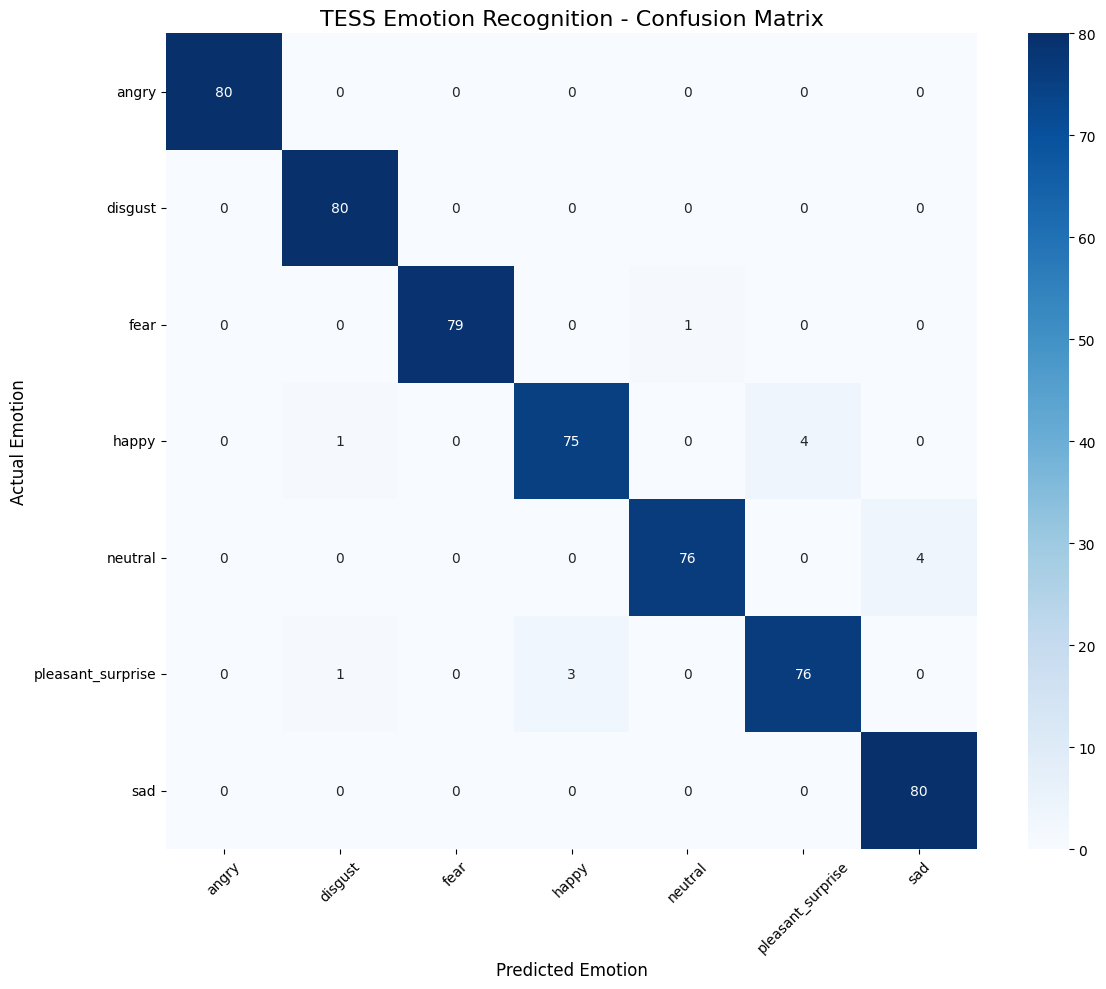


Model trained successfully! Accuracy: 97.50%
Model saved to /content/tess_emotion_model.pkl

Ready for audio emotion recognition

System ready! Choose an option:

Options:
1. Upload and analyze audio file
2. Test with sample files from dataset
3. Batch analyze folder
4. Exit

Audio File Upload & Analysis
Upload your audio file using the file browser below...


Saving 1001_DFA_ANG_XX.wav to 1001_DFA_ANG_XX.wav

Processing uploaded file: 1001_DFA_ANG_XX.wav

Audio File Emotion Analysis
Loading audio file: 1001_DFA_ANG_XX.wav
Resampling from 16000Hz to 22050Hz
Audio duration: 2.28 seconds
Sample rate: 22050Hz
Audio shape: (50177,)
Could not create visualizations: No librosa.feature attribute chroma

Analyzing emotion...
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'

EMOTION ANALYSIS RESULTS
File: 1001_DFA_ANG_XX.wav
Predicted Emotion: ANGRY
Confidence: 0.320 (32.0%)

All Emotion Scores:
--------------------------------------------------
  1.  angry              0.320 |████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░| 32.0%
  2.  pleasant_surprise  0.290 |███████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░| 29.0%
  3.  disgust            0.125 |█████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░| 12.5%
  4.  happy              0.090 |███░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░| 9.0%
  5.  fear               0.085 |█

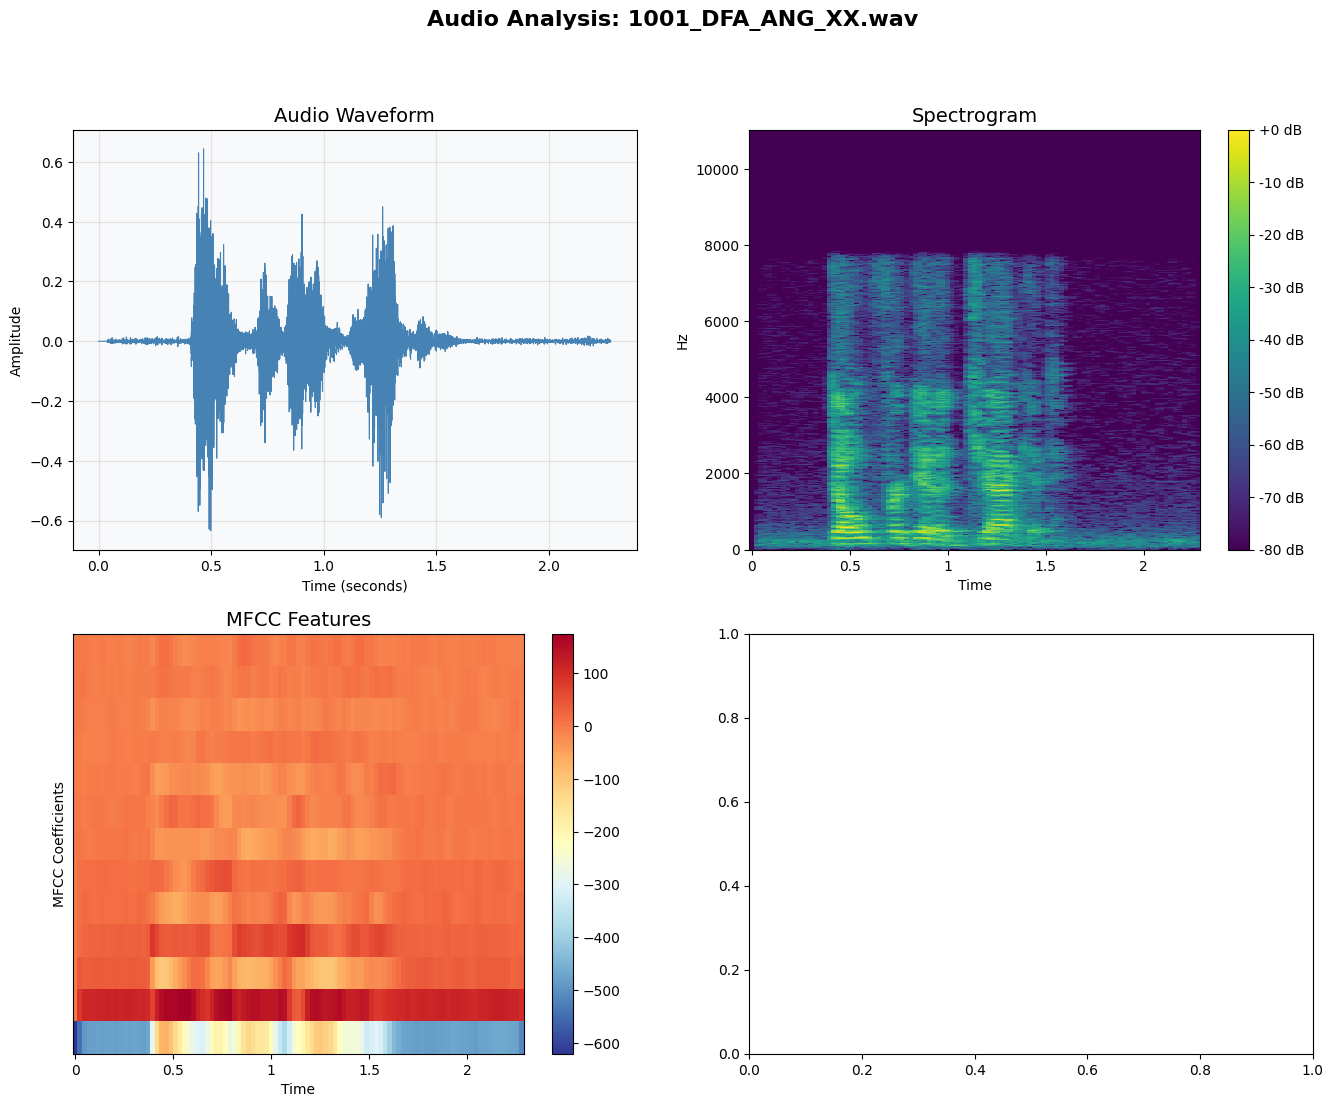

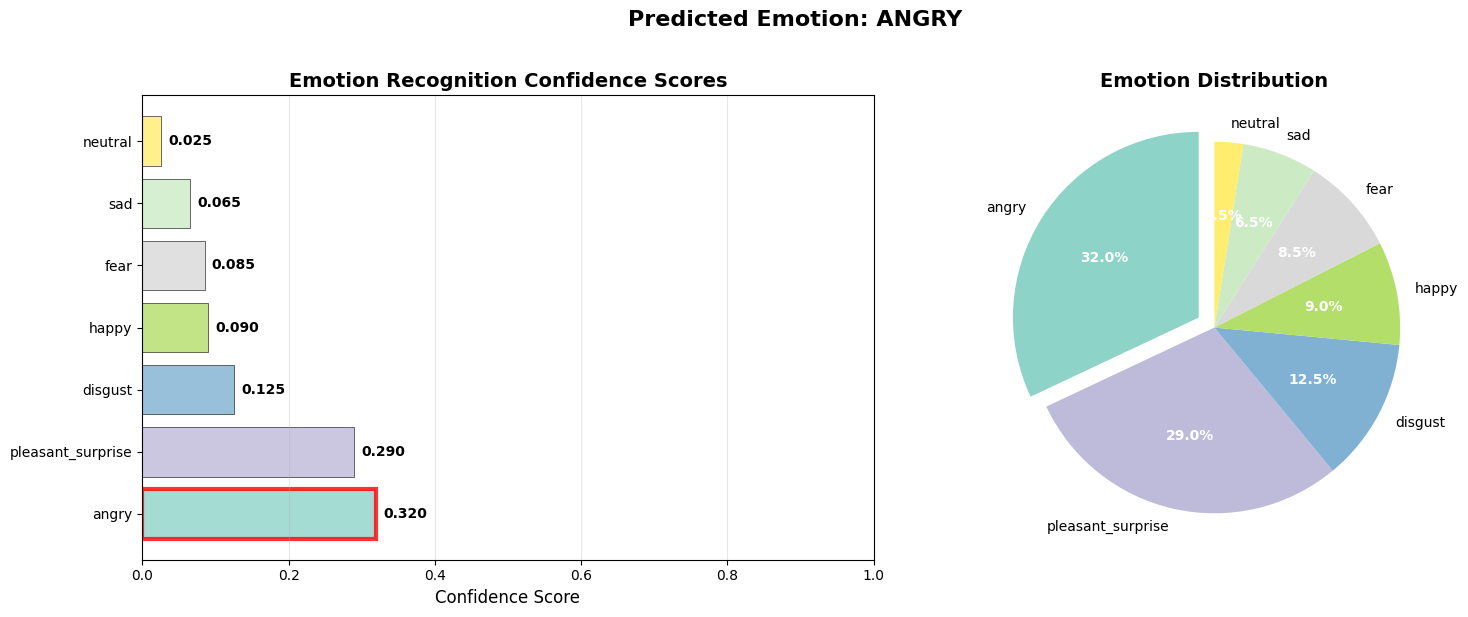


Options:
1. Upload and analyze audio file
2. Test with sample files from dataset
3. Batch analyze folder
4. Exit

Enter your choice (1-4): 1

Audio File Upload & Analysis
Upload your audio file using the file browser below...

Audio File Upload & Analysis
Upload your audio file using the file browser below...


Saving Speaker29_000.wav to Speaker29_000.wav

Processing uploaded file: Speaker29_000.wav

Audio File Emotion Analysis
Loading audio file: Speaker29_000.wav
Audio duration: 60.00 seconds
Sample rate: 22050Hz
Audio shape: (1323008,)
Saving Speaker29_000.wav to Speaker29_000.wav

Processing uploaded file: Speaker29_000.wav

Audio File Emotion Analysis
Loading audio file: Speaker29_000.wav
Audio duration: 60.00 seconds
Sample rate: 22050Hz
Audio shape: (1323008,)
Could not create visualizations: No librosa.feature attribute chroma

Analyzing emotion...
Chroma error: No librosa.feature attribute chroma
Could not create visualizations: No librosa.feature attribute chroma

Analyzing emotion...
Chroma error: No librosa.feature attribute chroma
Tempo error: module 'scipy.signal' has no attribute 'hann'

EMOTION ANALYSIS RESULTS
File: Speaker29_000.wav
Predicted Emotion: SAD
Confidence: 0.335 (33.5%)

All Emotion Scores:
--------------------------------------------------
  1.  sad             

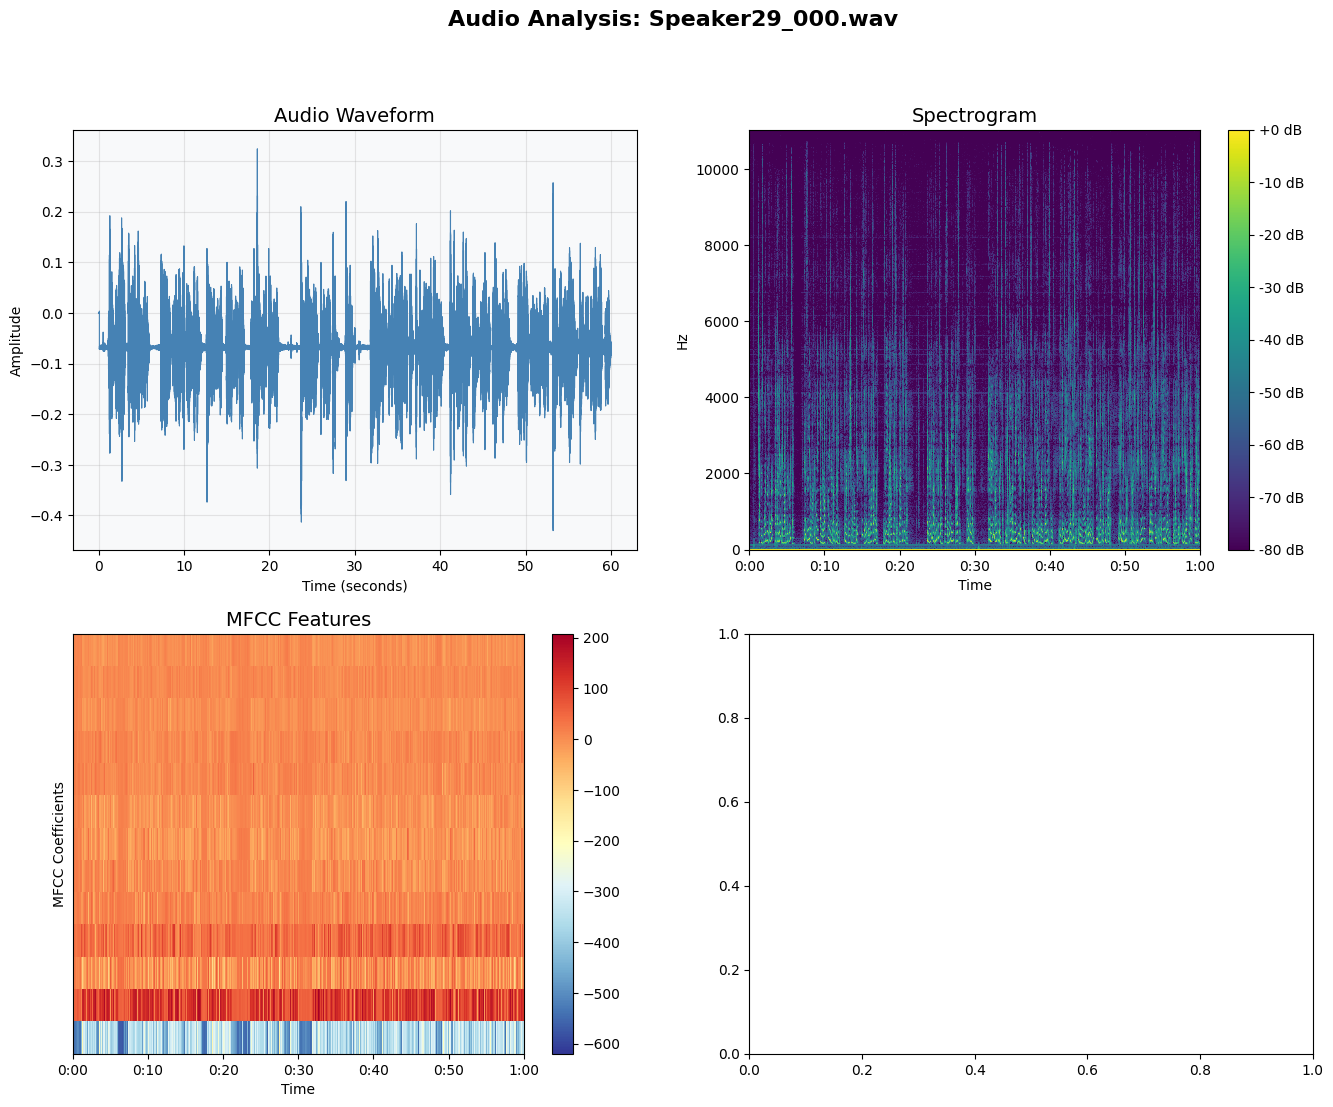

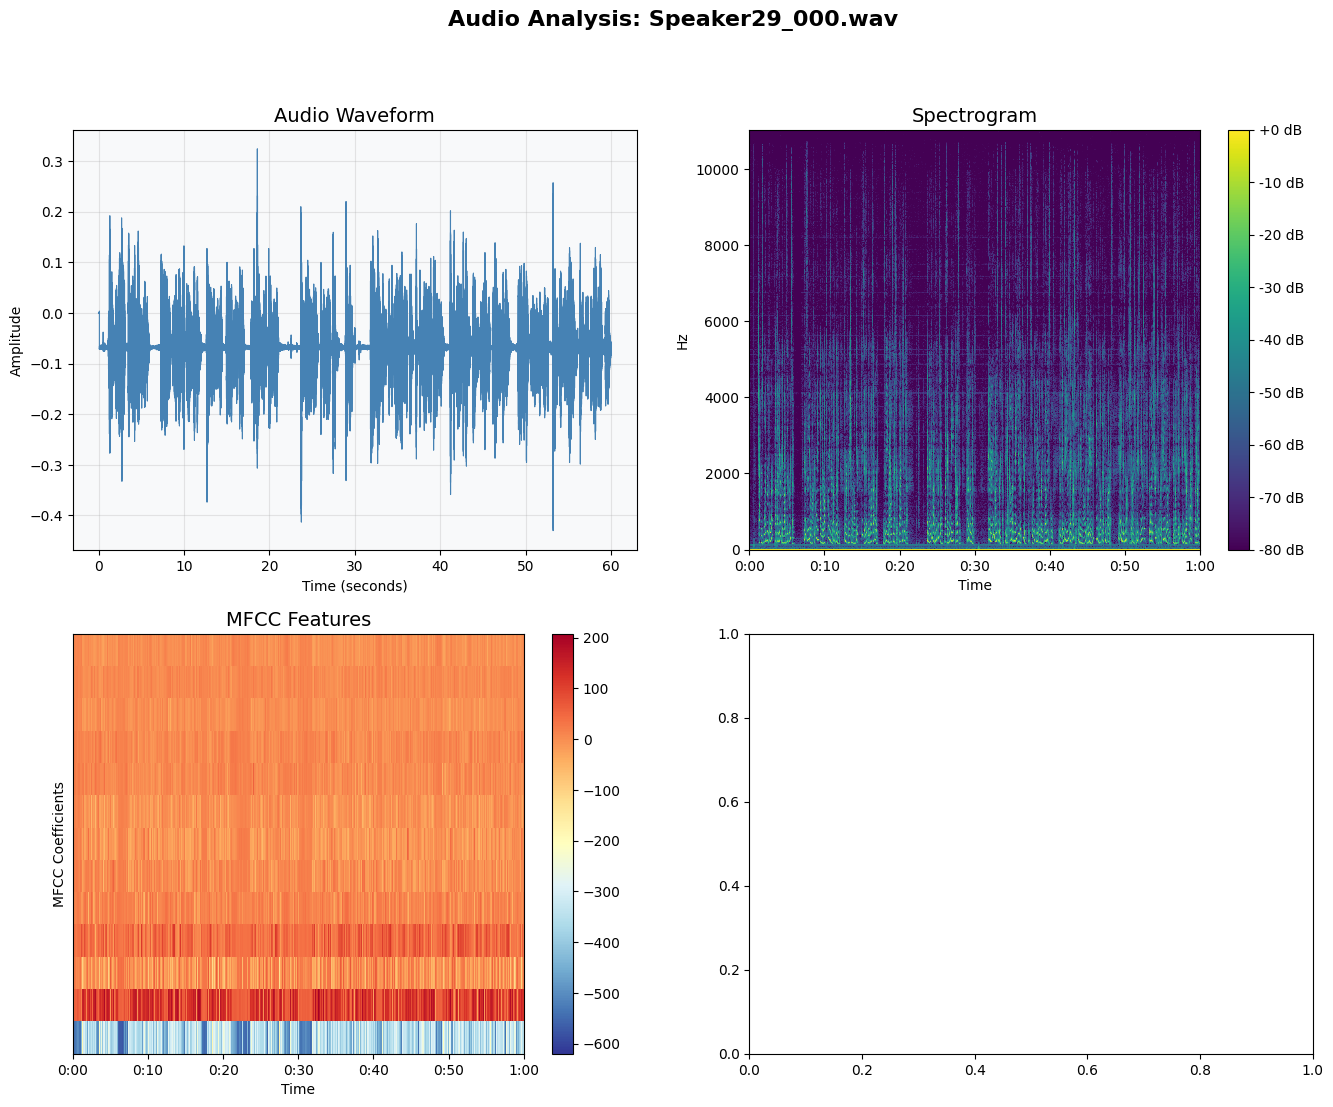

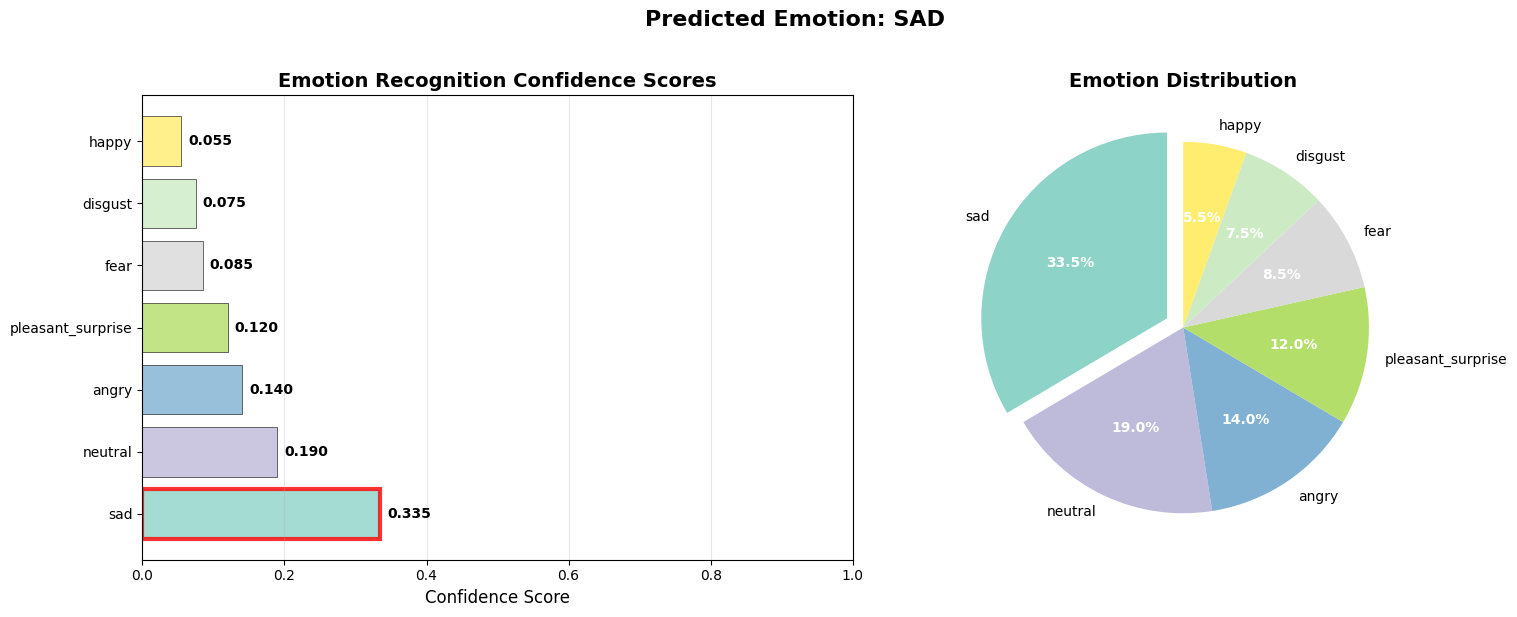

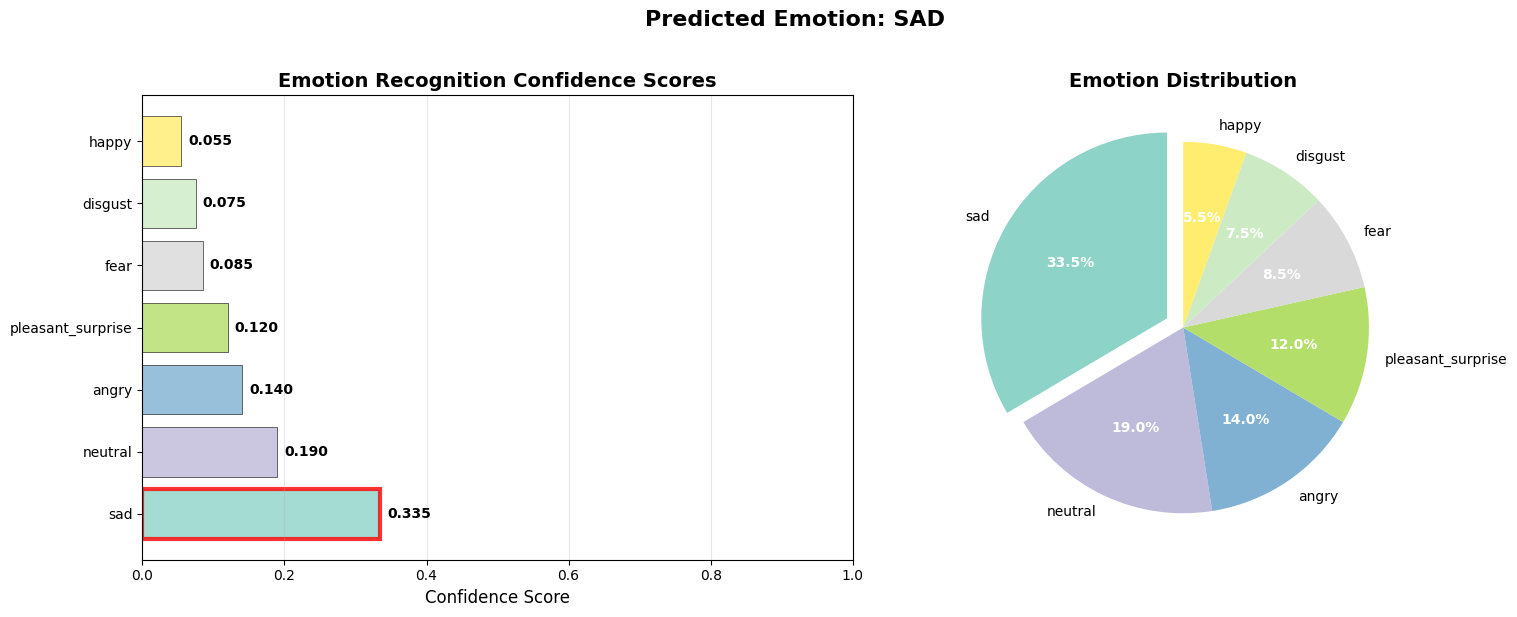


Options:
1. Upload and analyze audio file
2. Test with sample files from dataset
3. Batch analyze folder
4. Exit

Options:
1. Upload and analyze audio file
2. Test with sample files from dataset
3. Batch analyze folder
4. Exit

Enter your choice (1-4): 4
Thank you for using TESS Emotion Recognition System
Thank you for using TESS Emotion Recognition System


In [ ]:
# ==========================================
# BLOCK 7: MAIN EXECUTION FUNCTIONS
# ==========================================

def browse_drive_folders():
    """Helper function to browse Google Drive folders"""
    print("Let's find your TESS dataset folder...")
    print("\nBrowsing your Google Drive structure:")

    drive_root = "/content/drive/MyDrive"

    if not os.path.exists(drive_root):
        print("Google Drive not mounted properly")
        return None

    print(f"\nContents of {drive_root}:")
    try:
        items = os.listdir(drive_root)
        folders = [item for item in items if os.path.isdir(os.path.join(drive_root, item))]
        files = [item for item in items if os.path.isfile(os.path.join(drive_root, item))]

        print("Folders:")
        for i, folder in enumerate(folders, 1):
            print(f"  {i}. {folder}")

        if files:
            print(f"\nFiles: {len(files)} files found")

        if not folders:
            print("No folders found in your Google Drive root")
            return None

        return folders

    except Exception as e:
        print(f"Error browsing drive: {e}")
        return None

def find_tess_folders_recursively(root_path="/content/drive/MyDrive", max_depth=3):
    """Recursively search for TESS-related folders"""
    print(f"\nSearching for TESS-related folders in: {root_path}")
    tess_folders = []

    def search_recursive(path, current_depth=0):
        if current_depth > max_depth:
            return

        try:
            items = os.listdir(path)
            for item in items:
                item_path = os.path.join(path, item)
                if os.path.isdir(item_path):
                    # Check if folder name contains TESS-related keywords
                    if any(keyword.lower() in item.lower() for keyword in ['tess', 'emotion', 'speech', 'audio']):
                        tess_folders.append(item_path)
                        print(f"Found potential TESS folder: {item_path}")

                        # Check if it contains .wav files
                        try:
                            subfiles = os.listdir(item_path)
                            wav_count = sum(1 for f in subfiles if f.lower().endswith('.wav'))
                            if wav_count > 0:
                                print(f"  -> Contains {wav_count} .wav files")
                        except:
                            pass

                    # Continue searching in subdirectories
                    search_recursive(item_path, current_depth + 1)
        except PermissionError:
            pass
        except Exception as e:
            pass

    search_recursive(root_path)
    return tess_folders

def setup_tess_dataset():
    """Interactive setup for TESS dataset"""
    print("TESS Dataset Setup Assistant")
    print("=" * 40)

    # First, check if Drive is mounted
    if not os.path.exists("/content/drive/MyDrive"):
        print("Google Drive not found. Mounting...")
        try:
            drive.mount('/content/drive')
        except Exception as e:
            print(f"Failed to mount Google Drive: {e}")
            return None

    # Browse available folders
    folders = browse_drive_folders()

    if not folders:
        print("\nNo folders found. Please upload your TESS dataset to Google Drive first.")
        return None

    # Search for TESS-related folders
    tess_folders = find_tess_folders_recursively()

    if tess_folders:
        print(f"\nFound {len(tess_folders)} potential TESS dataset folders:")
        for i, folder in enumerate(tess_folders, 1):
            print(f"  {i}. {folder}")

        try:
            choice = int(input(f"\nSelect a folder (1-{len(tess_folders)}): ")) - 1
            if 0 <= choice < len(tess_folders):
                return tess_folders[choice]
        except (ValueError, IndexError):
            print("Invalid selection")

    print("\nManual folder selection:")
    print("Available folders in your Google Drive:")
    for i, folder in enumerate(folders, 1):
        print(f"  {i}. {folder}")

    try:
        choice = int(input(f"\nSelect a folder (1-{len(folders)}): ")) - 1
        if 0 <= choice < len(folders):
            selected_folder = f"/content/drive/MyDrive/{folders[choice]}"

            # Check if selected folder contains .wav files or subfolders
            try:
                contents = os.listdir(selected_folder)
                wav_files = [f for f in contents if f.lower().endswith('.wav')]
                subfolders = [f for f in contents if os.path.isdir(os.path.join(selected_folder, f))]

                print(f"\nSelected folder contains:")
                print(f"  - {len(wav_files)} .wav files")
                print(f"  - {len(subfolders)} subfolders")

                if wav_files or subfolders:
                    return selected_folder
                else:
                    print("No audio files or subfolders found in selected folder")

            except Exception as e:
                print(f"Error examining folder: {e}")

    except (ValueError, IndexError):
        print("Invalid selection")

    # Manual path entry as fallback
    print("\nOr enter the full path manually:")
    manual_path = input("Enter full path to TESS dataset folder: ").strip()
    if manual_path and os.path.exists(manual_path):
        return manual_path

    return None

def quick_start_from_drive():
    print("TESS Emotion Recognition - Quick Start from Google Drive")
    print("=" * 60)

    print("Testing librosa installation...")
    try:
        import librosa
        print(f"Librosa version: {librosa.__version__}")

        test_audio = np.random.randn(22050)
        test_mfcc = librosa.feature.mfcc(y=test_audio, sr=22050, n_mfcc=13)
        print("Librosa MFCC working")

        try:
            test_chroma = librosa.feature.chroma(y=test_audio, sr=22050)
            print("Librosa chroma working")
        except Exception as e:
            print(f"Chroma feature may have issues: {e}")

    except Exception as e:
        print(f"Librosa installation issue: {e}")
        print("Trying to fix librosa installation...")
        import subprocess
        subprocess.run(['pip', 'install', '--upgrade', '--force-reinstall', 'librosa==0.10.1'],
                      capture_output=True)
        try:
            import librosa
            print("Librosa reinstalled successfully")
        except:
            print("Still having librosa issues. Please restart runtime and try again.")
            return None

    if not setup_google_drive():
        print("Could not setup Google Drive")
        return None

    recognizer = TESSEmotionRecognizer()

    model_path = f"/content/{CONFIG['model_filename']}"
    if os.path.exists(model_path):
        print("Found existing trained model")
        use_existing = input("Load existing model? (y/n): ").strip().lower()
        if use_existing == 'y':
            if load_model(recognizer, model_path):
                print("Existing model loaded! Ready for predictions.")
                return recognizer

    print(f"\nLoading dataset from: {DRIVE_FOLDER_PATH}")
    features, labels = load_tess_dataset_from_drive(recognizer, DRIVE_FOLDER_PATH)

    if len(features) > 0:
        print("\nTraining model...")
        accuracy = train_model(recognizer, features, labels)

        if accuracy and accuracy > 0.5:
            print(f"\nModel trained successfully! Accuracy: {accuracy*100:.2f}%")

            save_model(recognizer)

            print("\nReady for audio emotion recognition")
            return recognizer
        else:
            print("Model accuracy is low. Check your dataset.")
            return None
    else:
        print("No data loaded from dataset.")
        return None

def test_with_sample_files(recognizer):
    if recognizer is None or recognizer.model is None:
        print("No trained model available")
        return

    print("\nTesting with sample audio files from training dataset")
    print("=" * 50)

    if not os.path.exists(DRIVE_FOLDER_PATH):
        print("TESS dataset folder not found")
        return

    emotion_files = find_tess_files(DRIVE_FOLDER_PATH)

    for emotion in CONFIG['emotions']:
        if emotion in emotion_files and emotion_files[emotion]:
            sample_file = emotion_files[emotion][0]
            print(f"\nTesting with {emotion} sample:")
            pred_emotion, scores = recognizer.analyze_uploaded_audio(sample_file)
            print("-" * 30)

def main():
    global DRIVE_FOLDER_PATH

    print("TESS Speech Emotion Recognition System")
    print("=" * 50)

    print("Configuration Check:")
    print(f"  Drive folder: {DRIVE_FOLDER_PATH}")
    print(f"  Emotions: {len(CONFIG['emotions'])} configured")

    # Enhanced folder setup
    if not os.path.exists(DRIVE_FOLDER_PATH):
        print(f"\nFolder not found: {DRIVE_FOLDER_PATH}")
        print("Let's help you find your TESS dataset...")

        found_path = setup_tess_dataset()
        if found_path:
            DRIVE_FOLDER_PATH = found_path
            print(f"Updated path to: {DRIVE_FOLDER_PATH}")
        else:
            print("Could not locate TESS dataset. Please check your Google Drive.")
            print("\nTo manually upload TESS dataset:")
            print("1. Download TESS dataset from: https://tspace.library.utoronto.ca/handle/1807/24487")
            print("2. Upload the extracted files to your Google Drive")
            print("3. Update the DRIVE_FOLDER_PATH variable")
            return None

    print("\nStarting Quick Start from Google Drive...")
    recognizer = quick_start_from_drive()

    if recognizer:
        print("\nSystem ready! Choose an option:")
        while True:
            print("\nOptions:")
            print("1. Upload and analyze audio file")
            print("2. Test with sample files from dataset")
            print("3. Batch analyze folder")
            print("4. Exit")

            choice = input("\nEnter your choice (1-4): ").strip()

            if choice == '1':
                upload_and_analyze_audio(recognizer)
            elif choice == '2':
                test_with_sample_files(recognizer)
            elif choice == '3':
                folder_path = input("Enter folder path for batch analysis: ").strip()
                if folder_path:
                    batch_analyze_audio_files(recognizer, folder_path)
            elif choice == '4':
                print("Thank you for using TESS Emotion Recognition System")
                break
            else:
                print("Invalid choice. Please enter 1-4.")
    else:
        print("Failed to setup the system. Please check your configuration and try again.")

print("All functions loaded! Ready to run!")
print("\n" + "="*55)
print("TO START:")
print("1. Update DRIVE_FOLDER_PATH in Block 2 with your actual folder path")
print("2. Run: main()")
print("="*55)

main()